In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_squared_error
import optuna
import lightgbm as lgb

In [2]:
data = pd.read_csv('DB_TIME_HISTORY.csv')
data0 = data.groupby('INST_NAME').get_group('PORTBDB2')

In [3]:
#输入某一个实例的数据data，输出处理后的时间与缺失值datanew
def time_miss_fix(data):
    time = data['SNAP_PERIOD']
    time = [i[:15] for i in time]
    time = pd.to_datetime(time,format = '%Y-%m-%d-%H%M')
    time = list(time)
    
    #时间取整
    for i in range(len(time)):
        if time[i].minute>0 and time[i].minute<30:
            time[i] = time[i] - datetime.timedelta(minutes=time[i].minute) #向下
            if time[i] == time[i-1]:
                time[i] = time[i] + datetime.timedelta(minutes=30) #向上
        elif time[i].minute>30:
            time[i] = time[i] - datetime.timedelta(minutes=(time[i].minute-30))
            if time[i] == time[i-1]:
                time[i] = time[i] + datetime.timedelta(minutes=30)
    
    time_new = pd.date_range(min(time),max(time),freq='1800s')
    datanew = pd.DataFrame(index=time_new,columns=['DB_TIME'])  #生成完整的时间
    datanew.loc[time,'DB_TIME']=list(data['DB_TIME'])                               #根据时间填充取值
    datanew.loc[datanew['DB_TIME']<0,'DB_TIME']=np.nan                     #把负值当成缺失值
    
    #大于每个月（账期可能都比较大，所以不用每天）最大值的75%分位数认为是异常值
    a = np.percentile(datanew.resample('M').max(),75)
    datanew.loc[datanew['DB_TIME']>a,'DB_TIME']=np.nan

    return datanew.DB_TIME

In [4]:
series = time_miss_fix(data0)
#从object转成float64
#series.astype(float)
series.fillna(series.median(),inplace=True)

# 提取特征

In [5]:
holiday = pd.read_csv('holiday.csv')
holiday.index = pd.to_datetime(holiday.time)
holiday.index = holiday.index.date

In [6]:
#提取特征
def get_feature(series, n_in=1):
    cols = list()
    #前48个半小时
    for i in range(n_in, 0, -1):
        cols.append(series.shift(i))
    #转换成数据框格式
    X = pd.concat(cols, axis=1)
    X.columns = range(n_in)
    
    #前3,5,7,10,15,24,48的最大值、最小值、均值、方差、中位数
    for i in [3,5,7,10,15,24,48]:
        X['max'+str(i)] = series.rolling(i).max()
        X['min'+str(i)] = series.rolling(i).min()
        X['mean'+str(i)] = series.rolling(i).mean()
        X['var'+str(i)] = series.rolling(i).var()
        X['median'+str(i)] = series.rolling(i).median()
    
    X['diff1'] = series.diff()  #一阶差分
    X['diff2'] = series.diff().diff()  #二阶差分
    
    #计算每日的均值
    df = pd.DataFrame(series)
    df['date'] = series.index.date #取出每个时间点的日期
    day_mean = df.groupby(['date']).mean().DB_TIME  #每日的均值
    df['daymean'] = [day_mean[i] for i in df['date']] #得到每个时间点对应的每日均值
    
    X['lastweek_day_mean'] = df['daymean'].shift(336)
    X['lastweek_X'] = series.shift(336)
    
    #时间特征
    time = series.index
    X['year'] = time.year-2018          #连续年
    X['quarter'] = time.quarter.astype('category')         #类别季度
    X['quarters'] = [holiday.loc[i,'quarters'] for i in time.date]     #连续季度
    X['month'] = time.month.astype('category')           #类别月
    X['months'] = [holiday.loc[i,'months'] for i in time.date]  #连续月
    X['week'] = time.isocalendar().week.astype('category')   #类别周
    X['weeks'] = [holiday.loc[i,'week'] for i in time.date]      #连续周
    X['how_long_month_end'] = [holiday.loc[i,'how_long_month_end'] for i in time.date]    #连续
    X['day_of_week'] = time.weekday.astype('category')  #类别，每周的第几天
    X['is_holiday'] = [holiday.loc[i,'is_holiday'] for i in time.date]  #类别，是否是假期
    X['is_holiday'] = X['is_holiday'].astype('category')
    X['how_long_holiday_one_weekend'] = [holiday.loc[i,'how_long_holiday_one_weekend'] for i in time.date]
    X['how_long_next_work_day'] = [holiday.loc[i,'how_long_next_work_day'] for i in time.date]
    X['how_long_next_work_holiday'] = [holiday.loc[i,'how_long_next_work_holiday'] for i in time.date]
    X['last_holiday_end_days'] = [holiday.loc[i,'last_holiday_end_days'] for i in time.date]
    X['day'] = np.where(time.day<=10,0,np.where(time.day<=20,1,2))
    X['day'] = X['day'].astype('category')
    X['hour'] = np.where(np.all([time.hour>=9,time.hour<=18],axis=0),0,np.where(np.any([time.hour>18,time.hour<=1],axis=0),1,2))
    X['hour'] = X['hour'].astype('category')
    X['minute'] = time.minute.astype('category')
    
    return X.drop(columns=range(24,48))

In [7]:
X = get_feature(series,48)

In [8]:
#根据缺失值最多的那一列特征删除
#X = X.dropna()
X = X.loc[X['lastweek_X'].dropna().index,:]
y = series[X.index]

# 训练集测试集划分

In [9]:
#测试集6个月
X_train = X[:-1440*6]
X_test = X[-1440*6:]
y_train = y[:-1440*6]
y_test = y[-1440*6:]

# optuna调参

#自定义加权损失函数
def custom_loss(y_pred, dtrain):
    y_true = dtrain.get_label()
    residual = (y_true - y_pred).astype("float")
    grad = np.where(y_true<50, -2*(residual)/(y_true+1), -5*2*(residual)/(y_true+1))#对预估值低于实际值的情况加大惩罚
    hess = np.where(y_true<50, 2/(y_true+1), 5*2/(y_true+1))#对预估值低于实际值的情况加大惩罚
    return grad, hess

#自定义加权评估函数
def custom_metric(y_pred, dtrain):
    y_true = dtrain.get_label()
    residual = (y_true - y_pred).astype("float")
    weight_squared =  np.where(y_true<50, residual**2, 3*residual**2)
    weight_mse = sum(weight_squared) / len(weight_squared)
    weight_rmse = weight_mse**0.5
    return 'weight_rmse', weight_rmse

In [10]:
def objective(trial):
    dtrain = lgb.Dataset(X_train, label=y_train,categorical_feature=['quarter','month','week','day_of_week','is_holiday','day','hour','minute'])
    dvalid = lgb.Dataset(X_test, label=y_test,categorical_feature=['quarter','month','week','day_of_week','is_holiday','day','hour','minute'])
    
    param = {
        "objective": "regression",  #目标函数
        "metric": "rmse",  #评估函数
        "boosting_type": "gbdt",   #提升类型
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),   #叶子节点数
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),   #建树的特征选择比例
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),  #建树的样本采样比例
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),   # k意味着每k次迭代执行bagging
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse") #剪枝
    gbm = lgb.train(param, dtrain, valid_sets=[dvalid],callbacks=[pruning_callback])
    preds = gbm.predict(X_test)
    rmse = mean_squared_error(y_test, preds)**0.5
    return rmse

In [11]:
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="minimize")  #优化方向RMSE最小
study.optimize(objective, n_trials=100, timeout=600) #100个trial或者600秒停止

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-03-29 17:36:07,120] A new study created in memory with name: no-name-8fe238c9-fb49-4164-b4bc-bb1af670f1ad
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.44871
[2]	valid_0's rmse: 7.85262
[3]	valid_0's rmse: 7.47889
[4]	valid_0's rmse: 7.05497
[5]	valid_0's rmse: 6.57388
[6]	valid_0's rmse: 6.12792
[7]	valid_0's rmse: 5.80551
[8]	valid_0's rmse: 5.45858
[9]	valid_0's rmse: 5.15713
[10]	valid_0's rmse: 4.87658
[11]	valid_0's rmse: 4.57645
[12]	valid_0's rmse: 4.36964
[13]	valid_0's rmse: 4.22615
[14]	valid_0's rmse: 3.99506
[15]	valid_0's rmse: 3.85565
[16]	valid_0's rmse: 3.69764
[17]	valid_0's rmse: 3.59362
[18]	valid_0's rmse: 3.45693
[19]	valid_0's rmse: 3.36334
[20]	valid_0's rmse: 3.25157
[21]	valid_0's rmse: 3.16273
[22]	valid_0's rmse: 3.07212
[23]	valid_0's rmse: 3.0

C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:36:07,600] Trial 0 finished with value: 1.7243676297040043 and parameters: {'lambda_l1': 1.3472709297552617e-06, 'lambda_l2': 0.05311234119931986, 'num_leaves': 4, 'feature_fraction': 0.43699719872560544, 'bagging_fraction': 0.7985123627973831, 'bagging_freq': 7, 'min_child_samples': 32}. Best is trial 0 with value: 1.7243676297040043.


[77]	valid_0's rmse: 1.83266
[78]	valid_0's rmse: 1.82826
[79]	valid_0's rmse: 1.82268
[80]	valid_0's rmse: 1.81269
[81]	valid_0's rmse: 1.80349
[82]	valid_0's rmse: 1.79398
[83]	valid_0's rmse: 1.78443
[84]	valid_0's rmse: 1.78465
[85]	valid_0's rmse: 1.78321
[86]	valid_0's rmse: 1.77671
[87]	valid_0's rmse: 1.76707
[88]	valid_0's rmse: 1.76421
[89]	valid_0's rmse: 1.75688
[90]	valid_0's rmse: 1.7527
[91]	valid_0's rmse: 1.75151
[92]	valid_0's rmse: 1.74923
[93]	valid_0's rmse: 1.74809
[94]	valid_0's rmse: 1.74002
[95]	valid_0's rmse: 1.73966
[96]	valid_0's rmse: 1.73832
[97]	valid_0's rmse: 1.72758
[98]	valid_0's rmse: 1.72888
[99]	valid_0's rmse: 1.7224
[100]	valid_0's rmse: 1.72437


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.12292
[2]	valid_0's rmse: 7.34074
[3]	valid_0's rmse: 6.64653
[4]	valid_0's rmse: 6.02336
[5]	valid_0's rmse: 5.48318


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[6]	valid_0's rmse: 5.0063
[7]	valid_0's rmse: 4.57213
[8]	valid_0's rmse: 4.18398
[9]	valid_0's rmse: 3.836
[10]	valid_0's rmse: 3.54069
[11]	valid_0's rmse: 3.27445
[12]	valid_0's rmse: 3.04581
[13]	valid_0's rmse: 2.83429
[14]	valid_0's rmse: 2.64414
[15]	valid_0's rmse: 2.4968
[16]	valid_0's rmse: 2.37056
[17]	valid_0's rmse: 2.25076
[18]	valid_0's rmse: 2.17067
[19]	valid_0's rmse: 2.08563
[20]	valid_0's rmse: 2.02103
[21]	valid_0's rmse: 1.95158
[22]	valid_0's rmse: 1.89189
[23]	valid_0's rmse: 1.85582
[24]	valid_0's rmse: 1.82882
[25]	valid_0's rmse: 1.78221
[26]	valid_0's rmse: 1.75984
[27]	valid_0's rmse: 1.72362
[28]	valid_0's rmse: 1.71231
[29]	valid_0's rmse: 1.68187
[30]	valid_0's rmse: 1.65168
[31]	valid_0's rmse: 1.64242
[32]	valid_0's rmse: 1.62461
[33]	valid_0's rmse: 1.61934
[34]	valid_0's rmse: 1.58514
[35]	valid_0's rmse: 1.56471
[36]	valid_0's rmse: 1.53962
[37]	valid_0's rmse: 1.52284
[38]	valid_0's rmse: 1.5121
[39]	valid_0's rmse: 1.50585
[40]	valid_0's rmse: 1.

[I 2021-03-29 17:36:10,570] Trial 1 finished with value: 1.2904936395791857 and parameters: {'lambda_l1': 7.315002846960115e-05, 'lambda_l2': 0.37573761534321043, 'num_leaves': 212, 'feature_fraction': 0.9361538205651995, 'bagging_fraction': 0.8905919352163812, 'bagging_freq': 7, 'min_child_samples': 38}. Best is trial 1 with value: 1.2904936395791857.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.12191
[2]	valid_0's rmse: 7.44793
[3]	valid_0's rmse: 6.85241
[4]	valid_0's rmse: 6.34152
[5]	valid_0's rmse: 5.83252
[6]	valid_0's rmse: 5.38791
[7]	valid_0's rmse: 4.97664
[8]	valid_0's rmse: 4.61949
[9]	valid_0's rmse: 4.36509
[10]	valid_0's rmse: 4.0914


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[11]	valid_0's rmse: 3.84849
[12]	valid_0's rmse: 3.67469
[13]	valid_0's rmse: 3.53143
[14]	valid_0's rmse: 3.37587
[15]	valid_0's rmse: 3.25799
[16]	valid_0's rmse: 3.14751
[17]	valid_0's rmse: 3.05506
[18]	valid_0's rmse: 2.97076
[19]	valid_0's rmse: 2.9165
[20]	valid_0's rmse: 2.85096
[21]	valid_0's rmse: 2.81117
[22]	valid_0's rmse: 2.76288
[23]	valid_0's rmse: 2.729
[24]	valid_0's rmse: 2.66522
[25]	valid_0's rmse: 2.63008
[26]	valid_0's rmse: 2.60766
[27]	valid_0's rmse: 2.5579
[28]	valid_0's rmse: 2.54509
[29]	valid_0's rmse: 2.53887
[30]	valid_0's rmse: 2.50669
[31]	valid_0's rmse: 2.45568
[32]	valid_0's rmse: 2.42176
[33]	valid_0's rmse: 2.42354
[34]	valid_0's rmse: 2.39607
[35]	valid_0's rmse: 2.37031
[36]	valid_0's rmse: 2.35234
[37]	valid_0's rmse: 2.33433
[38]	valid_0's rmse: 2.31286
[39]	valid_0's rmse: 2.30496
[40]	valid_0's rmse: 2.29072
[41]	valid_0's rmse: 2.26242
[42]	valid_0's rmse: 2.25021
[43]	valid_0's rmse: 2.24777
[44]	valid_0's rmse: 2.2413
[45]	valid_0's rmse

[I 2021-03-29 17:36:12,310] Trial 2 finished with value: 1.7833973375504608 and parameters: {'lambda_l1': 3.518816801217695e-07, 'lambda_l2': 5.7328567925842365e-06, 'num_leaves': 184, 'feature_fraction': 0.5669193492883695, 'bagging_fraction': 0.46920525087331016, 'bagging_freq': 7, 'min_child_samples': 48}. Best is trial 1 with value: 1.2904936395791857.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.10628
[2]	valid_0's rmse: 7.32007
[3]	valid_0's rmse: 6.6098
[4]	valid_0's rmse: 6.00718
[5]	valid_0's rmse: 5.47171
[6]	valid_0's rmse: 5.01398
[7]	valid_0's rmse: 4.62533
[8]	valid_0's rmse: 4.26093
[9]	valid_0's rmse: 3.91357
[10]	valid_0's rmse: 3.60727


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[11]	valid_0's rmse: 3.33653
[12]	valid_0's rmse: 3.12467
[13]	valid_0's rmse: 2.91697
[14]	valid_0's rmse: 2.76057
[15]	valid_0's rmse: 2.60337
[16]	valid_0's rmse: 2.48995
[17]	valid_0's rmse: 2.37828
[18]	valid_0's rmse: 2.28248
[19]	valid_0's rmse: 2.21446
[20]	valid_0's rmse: 2.14875
[21]	valid_0's rmse: 2.08968
[22]	valid_0's rmse: 2.05289
[23]	valid_0's rmse: 2.00953
[24]	valid_0's rmse: 1.98765
[25]	valid_0's rmse: 1.97015
[26]	valid_0's rmse: 1.95367
[27]	valid_0's rmse: 1.9482
[28]	valid_0's rmse: 1.9397
[29]	valid_0's rmse: 1.9314
[30]	valid_0's rmse: 1.88004
[31]	valid_0's rmse: 1.87688
[32]	valid_0's rmse: 1.87574
[33]	valid_0's rmse: 1.87257
[34]	valid_0's rmse: 1.85087
[35]	valid_0's rmse: 1.83547
[36]	valid_0's rmse: 1.82218
[37]	valid_0's rmse: 1.81252
[38]	valid_0's rmse: 1.78482
[39]	valid_0's rmse: 1.77821
[40]	valid_0's rmse: 1.75797
[41]	valid_0's rmse: 1.75388
[42]	valid_0's rmse: 1.7516
[43]	valid_0's rmse: 1.75415
[44]	valid_0's rmse: 1.74897
[45]	valid_0's rms

[I 2021-03-29 17:36:14,084] Trial 3 finished with value: 1.502230769711833 and parameters: {'lambda_l1': 9.170062207427132e-07, 'lambda_l2': 9.176106832496324e-06, 'num_leaves': 102, 'feature_fraction': 0.9432071018077031, 'bagging_fraction': 0.9143222829321433, 'bagging_freq': 4, 'min_child_samples': 72}. Best is trial 1 with value: 1.2904936395791857.


[98]	valid_0's rmse: 1.51131
[99]	valid_0's rmse: 1.5126
[100]	valid_0's rmse: 1.50223


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.1261
[2]	valid_0's rmse: 7.35731
[3]	valid_0's rmse: 6.6893
[4]	valid_0's rmse: 6.08305
[5]	valid_0's rmse: 5.55423
[6]	valid_0's rmse: 5.08658
[7]	valid_0's rmse: 4.67873
[8]	valid_0's rmse: 4.32731


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[9]	valid_0's rmse: 4.01967
[10]	valid_0's rmse: 3.76018
[11]	valid_0's rmse: 3.48313
[12]	valid_0's rmse: 3.23415
[13]	valid_0's rmse: 3.02885
[14]	valid_0's rmse: 2.86555
[15]	valid_0's rmse: 2.73687
[16]	valid_0's rmse: 2.59601
[17]	valid_0's rmse: 2.47674
[18]	valid_0's rmse: 2.38309
[19]	valid_0's rmse: 2.30223
[20]	valid_0's rmse: 2.24364
[21]	valid_0's rmse: 2.19089
[22]	valid_0's rmse: 2.14619
[23]	valid_0's rmse: 2.12043
[24]	valid_0's rmse: 2.09976
[25]	valid_0's rmse: 2.05804
[26]	valid_0's rmse: 2.04437
[27]	valid_0's rmse: 2.03651
[28]	valid_0's rmse: 1.98174
[29]	valid_0's rmse: 1.97859
[30]	valid_0's rmse: 1.93889
[31]	valid_0's rmse: 1.93877
[32]	valid_0's rmse: 1.94214
[33]	valid_0's rmse: 1.9463
[34]	valid_0's rmse: 1.93742
[35]	valid_0's rmse: 1.9059
[36]	valid_0's rmse: 1.87315
[37]	valid_0's rmse: 1.85029
[38]	valid_0's rmse: 1.82657
[39]	valid_0's rmse: 1.81588
[40]	valid_0's rmse: 1.80294
[41]	valid_0's rmse: 1.78713
[42]	valid_0's rmse: 1.77887
[43]	valid_0's rm

[I 2021-03-29 17:36:16,258] Trial 4 finished with value: 1.58323474315001 and parameters: {'lambda_l1': 1.8836238140794706e-05, 'lambda_l2': 1.545370041067272e-07, 'num_leaves': 156, 'feature_fraction': 0.9763633253217313, 'bagging_fraction': 0.6364700191255324, 'bagging_freq': 5, 'min_child_samples': 45}. Best is trial 1 with value: 1.2904936395791857.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:36:16,604] Trial 5 pruned. Trial was pruned at iteration 11.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13026
[2]	valid_0's rmse: 7.40957
[3]	valid_0's rmse: 6.73811
[4]	valid_0's rmse: 6.14348
[5]	valid_0's rmse: 5.59819
[6]	valid_0's rmse: 5.12829
[7]	valid_0's rmse: 4.69046
[8]	valid_0's rmse: 4.31611
[9]	valid_0's rmse: 4.02205
[10]	valid_0's rmse: 3.7439
[11]	valid_0's rmse: 3.47558


[I 2021-03-29 17:36:16,988] Trial 6 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 8.21666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 7.58075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 6.97025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.47764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 5.96564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 5.49147
[LightGBM] [Warning] No further spl

[I 2021-03-29 17:36:17,338] Trial 7 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.11797
[2]	valid_0's rmse: 7.45174
[3]	valid_0's rmse: 6.84616
[4]	valid_0's rmse: 6.3592
[5]	valid_0's rmse: 5.85071
[6]	valid_0's rmse: 5.38776
[7]	valid_0's rmse: 4.9875
[8]	valid_0's rmse: 4.67338
[9]	valid_0's rmse: 4.38861
[10]	valid_0's rmse: 4.10936


[I 2021-03-29 17:36:17,666] Trial 8 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.16089
[2]	valid_0's rmse: 7.44322
[3]	valid_0's rmse: 6.75011
[4]	valid_0's rmse: 6.17611
[5]	valid_0's rmse: 5.7166
[6]	valid_0's rmse: 5.24674
[7]	valid_0's rmse: 4.86138
[8]	valid_0's rmse: 4.50316
[9]	valid_0's rmse: 4.21111
[10]	valid_0's rmse: 3.92558
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.0906

[I 2021-03-29 17:36:18,070] Trial 9 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 8.13494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 7.34777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 6.69442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.12265
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 5.63567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 5.11605
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[87]	valid_0's rmse: 1.14643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[88]	valid_0's rmse: 1.14511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[89]	valid_0's rmse: 1.14526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	valid_0's rmse: 1.14535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	valid_0's rmse: 1.14494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	valid_0's rmse: 1.15045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	valid_0's rmse: 1.15299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	valid_0's rmse: 1.15501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	valid_0's rmse: 1.15669
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2021-03-29 17:36:19,764] Trial 10 finished with value: 1.1623127467876715 and parameters: {'lambda_l1': 7.6834252997880705, 'lambda_l2': 0.15179312547320545, 'num_leaves': 246, 'feature_fraction': 0.7908168996821956, 'bagging_fraction': 0.8033049849669714, 'bagging_freq': 7, 'min_child_samples': 14}. Best is trial 10 with value: 1.1623127467876715.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 8.12438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 7.3533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 6.70849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.15501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 5.65547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 5.16495
[LightGBM] [Warning] No further spli

C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:36:20,213] Trial 11 pruned. Trial was pruned at iteration 10.


[9]	valid_0's rmse: 4.00577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's rmse: 3.69323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.09128
[2]	valid_0's rmse: 7.30987
[3]	valid_0's rmse: 6.66772
[4]	valid_0's rmse: 6.10984
[5]	valid_0's rmse: 5.59658
[6]	valid_0's rmse: 5.06977
[7]	valid_0's rmse: 4.59823
[8]	valid_0's rmse: 4.20142
[9]	valid_0's rmse: 3.89078
[10]	valid_0's rmse: 3.54897
[11]	valid_0's rmse: 3.26707
[12]	valid_0's rmse: 2.99407
[13]	valid_0's rmse: 2.75519
[14]	valid_0's rmse: 2.55376
[15]	valid_0's rmse: 2.38519
[16]	valid_0's rmse:

[I 2021-03-29 17:36:23,096] Trial 12 finished with value: 1.1754756102413848 and parameters: {'lambda_l1': 0.010927410483788081, 'lambda_l2': 0.18990038997535566, 'num_leaves': 252, 'feature_fraction': 0.7737798801772425, 'bagging_fraction': 0.7974728819991411, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 10 with value: 1.1623127467876715.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 8.12361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 7.35085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 6.70724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.17642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 5.6458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 5.15639
[LightGBM] [Warning] No further spli

C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:36:23,511] Trial 13 pruned. Trial was pruned at iteration 10.


[10]	valid_0's rmse: 3.66385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.1163
[2]	valid_0's rmse: 7.3341
[3]	valid_0's rmse: 6.63393
[4]	valid_0's rmse: 6.05905
[5]	valid_0's rmse: 5.55324
[6]	valid_0's rmse: 5.04376
[7]	valid_0's rmse: 4.60172
[8]	valid_0's rmse: 4.21208
[9]	valid_0's rmse: 3.91059
[10]	valid_0's rmse: 3.56985
[11]	valid_0's rmse: 3.26629
[12]	valid_0's rmse: 3.01421
[13]	valid_0's rmse: 2.7824
[14]	valid_0's rmse: 2.57782
[15]	valid_0's rmse: 2.41051
[16]	valid_0's rmse: 2.26417
[17]	valid_0's rmse: 2.14301
[18]	valid_0's rmse: 2.05234
[19]	valid_0's rmse: 1.93808
[20]	valid

[I 2021-03-29 17:36:26,686] Trial 14 finished with value: 1.162497007278228 and parameters: {'lambda_l1': 0.08865612882747484, 'lambda_l2': 0.007617450096496334, 'num_leaves': 254, 'feature_fraction': 0.8362406520235062, 'bagging_fraction': 0.692151190214194, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 10 with value: 1.1623127467876715.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.1327
[2]	valid_0's rmse: 7.35889
[3]	valid_0's rmse: 6.67895
[4]	valid_0's rmse: 6.08844


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[5]	valid_0's rmse: 5.55198
[6]	valid_0's rmse: 5.06658
[7]	valid_0's rmse: 4.62046
[8]	valid_0's rmse: 4.23073
[9]	valid_0's rmse: 3.93818
[10]	valid_0's rmse: 3.60666
[11]	valid_0's rmse: 3.31094
[12]	valid_0's rmse: 3.04971
[13]	valid_0's rmse: 2.81275
[14]	valid_0's rmse: 2.60917
[15]	valid_0's rmse: 2.43269
[16]	valid_0's rmse: 2.25862
[17]	valid_0's rmse: 2.10507
[18]	valid_0's rmse: 1.97116
[19]	valid_0's rmse: 1.87908
[20]	valid_0's rmse: 1.78875
[21]	valid_0's rmse: 1.69441
[22]	valid_0's rmse: 1.62675
[23]	valid_0's rmse: 1.57905
[24]	valid_0's rmse: 1.52542
[25]	valid_0's rmse: 1.47601
[26]	valid_0's rmse: 1.43092
[27]	valid_0's rmse: 1.39551
[28]	valid_0's rmse: 1.37304
[29]	valid_0's rmse: 1.34392
[30]	valid_0's rmse: 1.32199
[31]	valid_0's rmse: 1.30586
[32]	valid_0's rmse: 1.29247
[33]	valid_0's rmse: 1.27379
[34]	valid_0's rmse: 1.26209
[35]	valid_0's rmse: 1.25849
[36]	valid_0's rmse: 1.25157
[37]	valid_0's rmse: 1.24126
[38]	valid_0's rmse: 1.2302
[39]	valid_0's rmse:

[I 2021-03-29 17:36:29,534] Trial 15 finished with value: 1.1545878475448346 and parameters: {'lambda_l1': 0.3021132982060766, 'lambda_l2': 0.0027131663632637224, 'num_leaves': 211, 'feature_fraction': 0.8558642008758577, 'bagging_fraction': 0.6814272370647011, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 15 with value: 1.1545878475448346.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.11012
[2]	valid_0's rmse: 7.3174
[3]	valid_0's rmse: 6.63553
[4]	valid_0's rmse: 6.10538
[5]	valid_0's rmse: 5.60645
[6]	valid_0's rmse: 5.10423
[7]	valid_0's rmse: 4.63018


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[8]	valid_0's rmse: 4.242
[9]	valid_0's rmse: 3.88388
[10]	valid_0's rmse: 3.53758
[11]	valid_0's rmse: 3.1991
[12]	valid_0's rmse: 2.97325
[13]	valid_0's rmse: 2.73534
[14]	valid_0's rmse: 2.52375
[15]	valid_0's rmse: 2.38072
[16]	valid_0's rmse: 2.24489
[17]	valid_0's rmse: 2.1117
[18]	valid_0's rmse: 2.02823
[19]	valid_0's rmse: 1.90308
[20]	valid_0's rmse: 1.80493
[21]	valid_0's rmse: 1.73536
[22]	valid_0's rmse: 1.68092
[23]	valid_0's rmse: 1.62403
[24]	valid_0's rmse: 1.57743
[25]	valid_0's rmse: 1.5445
[26]	valid_0's rmse: 1.53345
[27]	valid_0's rmse: 1.51577
[28]	valid_0's rmse: 1.48288
[29]	valid_0's rmse: 1.46841
[30]	valid_0's rmse: 1.43729
[31]	valid_0's rmse: 1.42056
[32]	valid_0's rmse: 1.39916
[33]	valid_0's rmse: 1.40128
[34]	valid_0's rmse: 1.37306
[35]	valid_0's rmse: 1.34524
[36]	valid_0's rmse: 1.35272
[37]	valid_0's rmse: 1.33846
[38]	valid_0's rmse: 1.33034
[39]	valid_0's rmse: 1.32229
[40]	valid_0's rmse: 1.30132
[41]	valid_0's rmse: 1.28728
[42]	valid_0's rmse: 

[I 2021-03-29 17:36:32,123] Trial 16 finished with value: 1.1995047954906217 and parameters: {'lambda_l1': 0.493177506130558, 'lambda_l2': 0.00030405204624315234, 'num_leaves': 214, 'feature_fraction': 0.6640493512837229, 'bagging_fraction': 0.5717583529482922, 'bagging_freq': 3, 'min_child_samples': 10}. Best is trial 15 with value: 1.1545878475448346.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 8.12298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 7.35409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 6.66987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.14169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 5.64653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 5.17807
[LightGBM] [Warning] No further spl

C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:36:32,532] Trial 17 pruned. Trial was pruned at iteration 10.


[10]	valid_0's rmse: 3.82989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13567
[2]	valid_0's rmse: 7.36813
[3]	valid_0's rmse: 6.69351
[4]	valid_0's rmse: 6.06502
[5]	valid_0's rmse: 5.54265
[6]	valid_0's rmse: 5.03961
[7]	valid_0's rmse: 4.5873
[8]	valid_0's rmse: 4.17581
[9]	valid_0's rmse: 3.8297
[10]	valid_0's rmse: 3.50044
[11]	valid_0's rmse: 3.20117
[12]	valid_0's rmse: 2.93511
[13]	valid_0's rmse: 2.72096
[14]	valid_0's rmse: 2.49947
[15]	valid_0's rmse: 2.31867
[16]	valid_0's rmse: 2.14982
[17]	valid_0's rmse: 1.98811
[18]	valid_0's rmse: 1.87652
[19]	valid_0's rmse: 1.77577
[20]	vali

[I 2021-03-29 17:36:35,827] Trial 18 finished with value: 0.8746700540371297 and parameters: {'lambda_l1': 1.7042278914903395e-08, 'lambda_l2': 1.2712316650491815, 'num_leaves': 226, 'feature_fraction': 0.8790805485278453, 'bagging_fraction': 0.7378532313341383, 'bagging_freq': 1, 'min_child_samples': 7}. Best is trial 18 with value: 0.8746700540371297.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13834
[2]	valid_0's rmse: 7.36886
[3]	valid_0's rmse: 6.69699
[4]	valid_0's rmse: 6.05137
[5]	valid_0's rmse: 5.54733
[6]	valid_0's rmse: 5.04472
[7]	valid_0's rmse: 4.61292
[8]	valid_0's rmse: 4.20474


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[9]	valid_0's rmse: 3.83443
[10]	valid_0's rmse: 3.51172
[11]	valid_0's rmse: 3.2143
[12]	valid_0's rmse: 2.94367
[13]	valid_0's rmse: 2.71658
[14]	valid_0's rmse: 2.50513
[15]	valid_0's rmse: 2.32724
[16]	valid_0's rmse: 2.16745
[17]	valid_0's rmse: 2.02084
[18]	valid_0's rmse: 1.89974
[19]	valid_0's rmse: 1.81979
[20]	valid_0's rmse: 1.73431
[21]	valid_0's rmse: 1.64701
[22]	valid_0's rmse: 1.58045
[23]	valid_0's rmse: 1.51507
[24]	valid_0's rmse: 1.4492
[25]	valid_0's rmse: 1.39052
[26]	valid_0's rmse: 1.33422
[27]	valid_0's rmse: 1.28494
[28]	valid_0's rmse: 1.25738
[29]	valid_0's rmse: 1.22157
[30]	valid_0's rmse: 1.19232
[31]	valid_0's rmse: 1.17141
[32]	valid_0's rmse: 1.18241
[33]	valid_0's rmse: 1.17346
[34]	valid_0's rmse: 1.15812
[35]	valid_0's rmse: 1.14531
[36]	valid_0's rmse: 1.12944
[37]	valid_0's rmse: 1.11186
[38]	valid_0's rmse: 1.11201
[39]	valid_0's rmse: 1.10877
[40]	valid_0's rmse: 1.10042
[41]	valid_0's rmse: 1.09355
[42]	valid_0's rmse: 1.09371
[43]	valid_0's rm

[I 2021-03-29 17:36:38,657] Trial 19 finished with value: 1.0619723603902143 and parameters: {'lambda_l1': 2.478891505473119e-08, 'lambda_l2': 1.873701350735536, 'num_leaves': 182, 'feature_fraction': 0.8708154768568215, 'bagging_fraction': 0.7245467301492802, 'bagging_freq': 1, 'min_child_samples': 6}. Best is trial 18 with value: 0.8746700540371297.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:36:39,066] Trial 20 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 8.13595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 7.40005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 6.75596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.17077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 5.71065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 5.26567
[LightGBM] [Warning] No further spl

[I 2021-03-29 17:36:39,524] Trial 21 pruned. Trial was pruned at iteration 10.


[8]	valid_0's rmse: 4.41106
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9]	valid_0's rmse: 4.04747
[10]	valid_0's rmse: 3.73186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.1285
[2]	valid_0's rmse: 7.35128
[3]	valid_0's rmse: 6.66124
[4]	valid_0's rmse: 6.04379
[5]	valid_0's rmse: 5.51901
[6]	valid_0's rmse: 5.04623
[7]	valid_0's rmse: 4.59594
[8]	valid_0's rmse: 4.18732
[9]	valid_0's rmse: 3.82036
[10]	valid_0's rmse: 3.50066
[11]	valid_0's rmse: 3.22036
[12]	valid_0's rmse: 2.97026
[13]	valid_0's rmse: 2.73921
[14]	valid_0's rmse: 2.54239
[15]	valid_0's rmse: 2.37019
[16]	valid_0's rmse: 2.22656
[17]	valid_0's rmse: 2.08797
[18]	valid

[I 2021-03-29 17:36:42,660] Trial 22 finished with value: 1.1071623691708967 and parameters: {'lambda_l1': 1.6857518897726608e-08, 'lambda_l2': 1.8653067012434597, 'num_leaves': 192, 'feature_fraction': 0.994548178975392, 'bagging_fraction': 0.7298149328414686, 'bagging_freq': 2, 'min_child_samples': 17}. Best is trial 18 with value: 0.8746700540371297.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.12283
[2]	valid_0's rmse: 7.34287
[3]	valid_0's rmse: 6.65381
[4]	valid_0's rmse: 6.05043
[5]	valid_0's rmse: 5.50611
[6]	valid_0's rmse: 5.02559


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[7]	valid_0's rmse: 4.55842
[8]	valid_0's rmse: 4.1788
[9]	valid_0's rmse: 3.82104
[10]	valid_0's rmse: 3.49917
[11]	valid_0's rmse: 3.23945
[12]	valid_0's rmse: 2.97176
[13]	valid_0's rmse: 2.73432
[14]	valid_0's rmse: 2.52565
[15]	valid_0's rmse: 2.35437
[16]	valid_0's rmse: 2.20782
[17]	valid_0's rmse: 2.06554
[18]	valid_0's rmse: 1.93978
[19]	valid_0's rmse: 1.8464
[20]	valid_0's rmse: 1.77623
[21]	valid_0's rmse: 1.70594
[22]	valid_0's rmse: 1.62721
[23]	valid_0's rmse: 1.56908
[24]	valid_0's rmse: 1.52
[25]	valid_0's rmse: 1.48531
[26]	valid_0's rmse: 1.46824
[27]	valid_0's rmse: 1.4145
[28]	valid_0's rmse: 1.39087
[29]	valid_0's rmse: 1.37708
[30]	valid_0's rmse: 1.35405
[31]	valid_0's rmse: 1.30898
[32]	valid_0's rmse: 1.27065
[33]	valid_0's rmse: 1.25919
[34]	valid_0's rmse: 1.25255
[35]	valid_0's rmse: 1.25899
[36]	valid_0's rmse: 1.26845
[37]	valid_0's rmse: 1.25483
[38]	valid_0's rmse: 1.25223
[39]	valid_0's rmse: 1.24565
[40]	valid_0's rmse: 1.22618
[41]	valid_0's rmse: 1.

[I 2021-03-29 17:36:45,204] Trial 23 finished with value: 1.0706676299378457 and parameters: {'lambda_l1': 1.1639612966780529e-08, 'lambda_l2': 1.3421629497948346, 'num_leaves': 125, 'feature_fraction': 0.991186755624778, 'bagging_fraction': 0.7446466147442345, 'bagging_freq': 2, 'min_child_samples': 17}. Best is trial 18 with value: 0.8746700540371297.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13749
[2]	valid_0's rmse: 7.34431
[3]	valid_0's rmse: 6.67148
[4]	valid_0's rmse: 6.09158
[5]	valid_0's rmse: 5.59519
[6]	valid_0's rmse: 5.09201
[7]	valid_0's rmse: 4.643
[8]	valid_0's rmse: 4.23354


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:36:45,686] Trial 24 pruned. Trial was pruned at iteration 10.


[9]	valid_0's rmse: 3.93119
[10]	valid_0's rmse: 3.58906
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.10735
[2]	valid_0's rmse: 7.31705
[3]	valid_0's rmse: 6.62791
[4]	valid_0's rmse: 5.99493
[5]	valid_0's rmse: 5.44184
[6]	valid_0's rmse: 4.94798
[7]	valid_0's rmse: 4.49059
[8]	valid_0's rmse: 4.09309
[9]	valid_0's rmse: 3.73134
[10]	valid_0's rmse: 3.43281
[11]	valid_0's rmse: 3.12645
[12]	valid_0's rmse: 2.86652
[13]	valid_0's rmse: 2.65121
[14]	valid_0's rmse: 2.47916
[15]	valid_0's rmse: 2.32749
[16]	valid_0's rmse: 2.1658
[17]	valid_0's rmse: 2.05748
[18]	valid_0's rmse: 1.93215
[19]	valid_0's rmse: 1.84732
[20]	valid_0's rmse: 1.76682
[21]	valid_0's rmse: 1.719

[I 2021-03-29 17:36:46,518] Trial 25 pruned. Trial was pruned at iteration 23.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.12041
[2]	valid_0's rmse: 7.33584
[3]	valid_0's rmse: 6.62602
[4]	valid_0's rmse: 5.99322
[5]	valid_0's rmse: 5.44819
[6]	valid_0's rmse: 4.94545
[7]	valid_0's rmse: 4.50788
[8]	valid_0's rmse: 4.09222


[I 2021-03-29 17:36:47,123] Trial 26 pruned. Trial was pruned at iteration 18.


[9]	valid_0's rmse: 3.73901
[10]	valid_0's rmse: 3.43144
[11]	valid_0's rmse: 3.1571
[12]	valid_0's rmse: 2.93737
[13]	valid_0's rmse: 2.75089
[14]	valid_0's rmse: 2.56963
[15]	valid_0's rmse: 2.37793
[16]	valid_0's rmse: 2.22158
[17]	valid_0's rmse: 2.10638
[18]	valid_0's rmse: 2.02635
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.11495
[2]	valid_0's rmse: 7.3479
[3]	valid_0's rmse: 6.654
[4]	valid_0's rmse: 6.11301
[5]	valid_0's rmse: 5.57738
[6]	valid_0's rmse: 5.07333
[7]	valid_0's rmse: 4.60877
[8]	valid_0's rmse: 4.18741
[9]	valid_0's rmse: 3.87075
[10]	valid_0's rmse: 3.55349
[11]	valid_0's rmse: 3.26029
[12]	valid_0's rmse: 3.00805


[I 2021-03-29 17:36:47,665] Trial 27 pruned. Trial was pruned at iteration 19.


[13]	valid_0's rmse: 2.77167
[14]	valid_0's rmse: 2.57398
[15]	valid_0's rmse: 2.39922
[16]	valid_0's rmse: 2.25202
[17]	valid_0's rmse: 2.11996
[18]	valid_0's rmse: 2.01065
[19]	valid_0's rmse: 1.92008


[I 2021-03-29 17:36:48,049] Trial 28 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 8.23521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 7.5714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 6.98333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.44411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 5.96467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 5.51821
[LightGBM] [Warning] No further spli

[I 2021-03-29 17:36:48,909] Trial 29 pruned. Trial was pruned at iteration 21.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.09629
[2]	valid_0's rmse: 7.34188
[3]	valid_0's rmse: 6.71279
[4]	valid_0's rmse: 6.14502
[5]	valid_0's rmse: 5.63166
[6]	valid_0's rmse: 5.14403
[7]	valid_0's rmse: 4.69321
[8]	valid_0's rmse: 4.30187


[I 2021-03-29 17:36:49,435] Trial 30 pruned. Trial was pruned at iteration 10.


[9]	valid_0's rmse: 3.97973
[10]	valid_0's rmse: 3.68723
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.11275
[2]	valid_0's rmse: 7.33458
[3]	valid_0's rmse: 6.65538
[4]	valid_0's rmse: 6.03659
[5]	valid_0's rmse: 5.50903
[6]	valid_0's rmse: 5.03622
[7]	valid_0's rmse: 4.57758
[8]	valid_0's rmse: 4.14055
[9]	valid_0's rmse: 3.77011
[10]	valid_0's rmse: 3.44319
[11]	valid_0's rmse: 3.16601
[12]	valid_0's rmse: 2.9233
[13]	valid_0's rmse: 2.67812
[14]	valid_0's rmse: 2.47651
[15]	valid_0's rmse: 2.31524
[16]	valid_0's rmse: 2.17253
[17]	valid_0's rmse: 2.03334
[18]	valid_0's rmse: 1.91167
[19]	valid_0's rmse: 1.80647
[20]	valid_0's rmse: 1.72449
[21]	valid_0's rmse: 1.671

[I 2021-03-29 17:36:52,376] Trial 31 finished with value: 1.1358380717565615 and parameters: {'lambda_l1': 2.10060316874561e-08, 'lambda_l2': 1.01089610199131, 'num_leaves': 196, 'feature_fraction': 0.9867930562570731, 'bagging_fraction': 0.7220080144611281, 'bagging_freq': 2, 'min_child_samples': 17}. Best is trial 18 with value: 0.8746700540371297.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 8.17506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 7.42451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 6.76797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.17014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 5.62745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 5.11835


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:36:52,839] Trial 32 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's rmse: 4.68572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	valid_0's rmse: 4.28289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9]	valid_0's rmse: 3.90125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's rmse: 3.5717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.15668
[2]	valid_0's rmse: 7.39533
[3]	valid_0's rmse: 6.6964
[4]	valid_0's rmse: 6.07286
[5]	valid_0's rmse: 5.48518
[6]	valid_0's rmse: 4.98012

[I 2021-03-29 17:36:54,151] Trial 33 pruned. Trial was pruned at iteration 36.


[29]	valid_0's rmse: 1.33544
[30]	valid_0's rmse: 1.31073
[31]	valid_0's rmse: 1.30147
[32]	valid_0's rmse: 1.29616
[33]	valid_0's rmse: 1.29029
[34]	valid_0's rmse: 1.30754
[35]	valid_0's rmse: 1.32992
[36]	valid_0's rmse: 1.3573
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 8.13883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 7.36061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 6.6728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.07518
[LightGBM] 

[I 2021-03-29 17:36:54,619] Trial 34 pruned. Trial was pruned at iteration 10.


[9]	valid_0's rmse: 3.93561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's rmse: 3.63391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13597
[2]	valid_0's rmse: 7.3668
[3]	valid_0's rmse: 6.69166
[4]	valid_0's rmse: 6.05129
[5]	valid_0's rmse: 5.49017
[6]	valid_0's rmse: 4.9948
[7]	valid_0's rmse: 4.55755
[8]	valid_0's rmse: 4.14598
[9]	valid_0's rmse: 3.76692
[10]	valid_0's rmse: 3.43648
[11]	valid_0's rmse: 3.16378
[12]	valid_0's rmse: 2.93117
[13]	valid_0's rmse: 2.68693
[14]	valid_0's rmse: 2.47882
[15]	valid_0's rmse: 2.32235
[16]	valid_0's rmse: 2

[I 2021-03-29 17:36:56,177] Trial 35 pruned. Trial was pruned at iteration 66.


[61]	valid_0's rmse: 1.21081
[62]	valid_0's rmse: 1.20859
[63]	valid_0's rmse: 1.20369
[64]	valid_0's rmse: 1.19998
[65]	valid_0's rmse: 1.20093
[66]	valid_0's rmse: 1.20869
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.12319
[2]	valid_0's rmse: 7.35914
[3]	valid_0's rmse: 6.65853
[4]	valid_0's rmse: 5.9999
[5]	valid_0's rmse: 5.41718
[6]	valid_0's rmse: 4.95888
[7]	valid_0's rmse: 4.48091
[8]	valid_0's rmse: 4.08094
[9]	valid_0's rmse: 3.74196
[10]	valid_0's rmse: 3.43172
[11]	valid_0's rmse: 3.17077
[12]	valid_0's rmse: 2.91661
[13]	valid_0's rmse: 2.71157
[14]	valid_0's rmse: 2.51588
[15]	valid_0's rmse: 2.3467
[16]	valid_0's rmse: 2.1882
[17]	valid_0's rmse: 2.0722

[I 2021-03-29 17:36:59,102] Trial 36 finished with value: 1.0800573725047806 and parameters: {'lambda_l1': 4.061522937046352e-08, 'lambda_l2': 0.2846508454385766, 'num_leaves': 175, 'feature_fraction': 0.926979770403964, 'bagging_fraction': 0.5987057025816336, 'bagging_freq': 1, 'min_child_samples': 15}. Best is trial 18 with value: 0.8746700540371297.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 8.13463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 7.39733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 6.7868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.18067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 5.70782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 5.24912
[LightGBM] [Warning] No further spli

C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:36:59,570] Trial 37 pruned. Trial was pruned at iteration 10.


[9]	valid_0's rmse: 4.18212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's rmse: 3.91389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.12627
[2]	valid_0's rmse: 7.33319
[3]	valid_0's rmse: 6.61293
[4]	valid_0's rmse: 5.95157
[5]	valid_0's rmse: 5.48074
[6]	valid_0's rmse: 4.99151
[7]	valid_0's rmse: 4.53132
[8]	valid_0's rmse: 4.1261
[9]	valid_0's rmse: 3.78858
[10]	valid_0's rmse: 3.47502
[11]	valid_0's rmse: 3.20123
[12]	valid_0's rmse: 2.93148
[13]	valid_0's rmse: 2.71766
[14]	valid_0's rmse: 2.508
[15]	valid_0's rmse: 2.33521
[16]	valid_0's rmse: 2.

[I 2021-03-29 17:37:02,205] Trial 38 finished with value: 0.9302778137663129 and parameters: {'lambda_l1': 4.5535688384405943e-07, 'lambda_l2': 0.01922183514250043, 'num_leaves': 134, 'feature_fraction': 0.879803803427392, 'bagging_fraction': 0.5434749481755331, 'bagging_freq': 1, 'min_child_samples': 9}. Best is trial 18 with value: 0.8746700540371297.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.09953
[2]	valid_0's rmse: 7.30491
[3]	valid_0's rmse: 6.61846
[4]	valid_0's rmse: 5.99484
[5]	valid_0's rmse: 5.53273
[6]	valid_0's rmse: 5.06822
[7]	valid_0's rmse: 4.61278
[8]	valid_0's rmse: 4.20901
[9]	valid_0's rmse: 3.84449


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:37:02,652] Trial 39 pruned. Trial was pruned at iteration 12.


[10]	valid_0's rmse: 3.5043
[11]	valid_0's rmse: 3.21462
[12]	valid_0's rmse: 2.95402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.12035
[2]	valid_0's rmse: 7.35282
[3]	valid_0's rmse: 6.64939
[4]	valid_0's rmse: 5.97702
[5]	valid_0's rmse: 5.42076
[6]	valid_0's rmse: 4.91523
[7]	valid_0's rmse: 4.46749
[8]	valid_0's rmse: 4.06193
[9]	valid_0's rmse: 3.70501
[10]	valid_0's rmse: 3.38974
[11]	valid_0's rmse: 3.13506
[12]	valid_0's rmse: 2.90975
[13]	valid_0's rmse: 2.67136
[14]	valid_0's rmse: 2.48955
[15]	valid_0's rmse: 2.31997
[16]	valid_0's rmse: 2.16422
[17]	valid_0's rmse: 2.03542
[18]	valid_0's rmse: 1.91932
[19]	valid_0's rmse: 1.80087
[20]	valid_0's rmse: 1.70

[I 2021-03-29 17:37:05,102] Trial 40 finished with value: 0.9811602151430836 and parameters: {'lambda_l1': 2.9450691821774903e-07, 'lambda_l2': 1.8813710873012345e-05, 'num_leaves': 134, 'feature_fraction': 0.9550126585755303, 'bagging_fraction': 0.518353623119241, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 18 with value: 0.8746700540371297.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.09963
[2]	valid_0's rmse: 7.29417
[3]	valid_0's rmse: 6.58595
[4]	valid_0's rmse: 5.96568
[5]	valid_0's rmse: 5.37569
[6]	valid_0's rmse: 4.85619

C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))



[7]	valid_0's rmse: 4.40545
[8]	valid_0's rmse: 3.97688
[9]	valid_0's rmse: 3.61162
[10]	valid_0's rmse: 3.27007
[11]	valid_0's rmse: 3.02059
[12]	valid_0's rmse: 2.80893
[13]	valid_0's rmse: 2.57975
[14]	valid_0's rmse: 2.35263
[15]	valid_0's rmse: 2.17578
[16]	valid_0's rmse: 2.02137
[17]	valid_0's rmse: 1.88766
[18]	valid_0's rmse: 1.77619
[19]	valid_0's rmse: 1.67258
[20]	valid_0's rmse: 1.58272
[21]	valid_0's rmse: 1.5225
[22]	valid_0's rmse: 1.45056
[23]	valid_0's rmse: 1.39392
[24]	valid_0's rmse: 1.34443
[25]	valid_0's rmse: 1.30607
[26]	valid_0's rmse: 1.25944
[27]	valid_0's rmse: 1.2309
[28]	valid_0's rmse: 1.21332
[29]	valid_0's rmse: 1.18585
[30]	valid_0's rmse: 1.17021
[31]	valid_0's rmse: 1.14877
[32]	valid_0's rmse: 1.13545
[33]	valid_0's rmse: 1.13306
[34]	valid_0's rmse: 1.13517
[35]	valid_0's rmse: 1.12195
[36]	valid_0's rmse: 1.11153
[37]	valid_0's rmse: 1.10796
[38]	valid_0's rmse: 1.10558
[39]	valid_0's rmse: 1.09925
[40]	valid_0's rmse: 1.09911
[41]	valid_0's rms

[I 2021-03-29 17:37:07,629] Trial 41 finished with value: 1.0981147131218705 and parameters: {'lambda_l1': 3.379443503269884e-07, 'lambda_l2': 9.405084489759753e-06, 'num_leaves': 136, 'feature_fraction': 0.9549594150214673, 'bagging_fraction': 0.5612436639338714, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 18 with value: 0.8746700540371297.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.11936
[2]	valid_0's rmse: 7.32221
[3]	valid_0's rmse: 6.62508
[4]	valid_0's rmse: 5.99982
[5]	valid_0's rmse: 5.48849
[6]	valid_0's rmse: 4.97768
[7]	valid_0's rmse: 4.51575


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[8]	valid_0's rmse: 4.12202
[9]	valid_0's rmse: 3.76372
[10]	valid_0's rmse: 3.41993
[11]	valid_0's rmse: 3.12011
[12]	valid_0's rmse: 2.8507
[13]	valid_0's rmse: 2.6064
[14]	valid_0's rmse: 2.39451
[15]	valid_0's rmse: 2.22176
[16]	valid_0's rmse: 2.07306
[17]	valid_0's rmse: 1.93146
[18]	valid_0's rmse: 1.82161
[19]	valid_0's rmse: 1.7247
[20]	valid_0's rmse: 1.65947
[21]	valid_0's rmse: 1.58237
[22]	valid_0's rmse: 1.51782
[23]	valid_0's rmse: 1.48774
[24]	valid_0's rmse: 1.44911
[25]	valid_0's rmse: 1.3921
[26]	valid_0's rmse: 1.36147
[27]	valid_0's rmse: 1.31671
[28]	valid_0's rmse: 1.29655
[29]	valid_0's rmse: 1.2781
[30]	valid_0's rmse: 1.25151
[31]	valid_0's rmse: 1.23222
[32]	valid_0's rmse: 1.21695
[33]	valid_0's rmse: 1.2146
[34]	valid_0's rmse: 1.20018
[35]	valid_0's rmse: 1.19122
[36]	valid_0's rmse: 1.18535
[37]	valid_0's rmse: 1.17218
[38]	valid_0's rmse: 1.16437
[39]	valid_0's rmse: 1.15456
[40]	valid_0's rmse: 1.15173
[41]	valid_0's rmse: 1.15695
[42]	valid_0's rmse: 1

[I 2021-03-29 17:37:09,712] Trial 42 finished with value: 1.0315303389123915 and parameters: {'lambda_l1': 2.4483812514993183e-06, 'lambda_l2': 2.437366134456916e-06, 'num_leaves': 107, 'feature_fraction': 0.8873295015074119, 'bagging_fraction': 0.6722303591651327, 'bagging_freq': 3, 'min_child_samples': 9}. Best is trial 18 with value: 0.8746700540371297.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.12145
[2]	valid_0's rmse: 7.33555
[3]	valid_0's rmse: 6.62496
[4]	valid_0's rmse: 6.11714
[5]	valid_0's rmse: 5.60944
[6]	valid_0's rmse: 5.06801
[7]	valid_0's rmse: 4.60557
[8]	valid_0's rmse: 4.21539
[9]	valid_0's rmse: 3.86935
[10]	valid_0's rmse: 3.50457


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[11]	valid_0's rmse: 3.18912
[12]	valid_0's rmse: 2.90494
[13]	valid_0's rmse: 2.65653
[14]	valid_0's rmse: 2.44078
[15]	valid_0's rmse: 2.24876
[16]	valid_0's rmse: 2.11646
[17]	valid_0's rmse: 1.99932
[18]	valid_0's rmse: 1.89783
[19]	valid_0's rmse: 1.77706
[20]	valid_0's rmse: 1.68442
[21]	valid_0's rmse: 1.61393
[22]	valid_0's rmse: 1.54316
[23]	valid_0's rmse: 1.47789
[24]	valid_0's rmse: 1.41838
[25]	valid_0's rmse: 1.38208
[26]	valid_0's rmse: 1.32212
[27]	valid_0's rmse: 1.2817
[28]	valid_0's rmse: 1.24909
[29]	valid_0's rmse: 1.22425
[30]	valid_0's rmse: 1.20595
[31]	valid_0's rmse: 1.18267
[32]	valid_0's rmse: 1.17355
[33]	valid_0's rmse: 1.16988
[34]	valid_0's rmse: 1.15345
[35]	valid_0's rmse: 1.13006
[36]	valid_0's rmse: 1.1207
[37]	valid_0's rmse: 1.10352
[38]	valid_0's rmse: 1.08922
[39]	valid_0's rmse: 1.07349
[40]	valid_0's rmse: 1.06459
[41]	valid_0's rmse: 1.05069
[42]	valid_0's rmse: 1.03666
[43]	valid_0's rmse: 1.02764
[44]	valid_0's rmse: 1.03467
[45]	valid_0's r

[I 2021-03-29 17:37:11,470] Trial 43 finished with value: 0.9980887421627564 and parameters: {'lambda_l1': 4.188942912687535e-06, 'lambda_l2': 6.85111935395099e-07, 'num_leaves': 109, 'feature_fraction': 0.8107532977335877, 'bagging_fraction': 0.5052774969433791, 'bagging_freq': 3, 'min_child_samples': 9}. Best is trial 18 with value: 0.8746700540371297.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.11487
[2]	valid_0's rmse: 7.31503
[3]	valid_0's rmse: 6.65186
[4]	valid_0's rmse: 6.10601
[5]	valid_0's rmse: 5.64784
[6]	valid_0's rmse: 5.12386
[7]	valid_0's rmse: 4.63818
[8]	valid_0's rmse: 4.25707


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:37:11,879] Trial 44 pruned. Trial was pruned at iteration 10.


[9]	valid_0's rmse: 3.91008
[10]	valid_0's rmse: 3.59152
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.11237
[2]	valid_0's rmse: 7.35883
[3]	valid_0's rmse: 6.69228
[4]	valid_0's rmse: 6.1786
[5]	valid_0's rmse: 5.70693
[6]	valid_0's rmse: 5.21039
[7]	valid_0's rmse: 4.78776
[8]	valid_0's rmse: 4.40018
[9]	valid_0's rmse: 4.07369
[10]	valid_0's rmse: 3.75179


[I 2021-03-29 17:37:12,299] Trial 45 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.09906
[2]	valid_0's rmse: 7.29795
[3]	valid_0's rmse: 6.57897
[4]	valid_0's rmse: 5.92376
[5]	valid_0's rmse: 5.42181
[6]	valid_0's rmse: 4.91201
[7]	valid_0's rmse: 4.44695
[8]	valid_0's rmse: 4.02707
[9]	valid_0's rmse: 3.69097
[10]	valid_0's rmse: 3.38454
[11]	valid_0's rmse: 3.09777
[12]	valid_0's rmse: 2.85706
[13]	valid_0's rmse: 2.61227
[14]	valid_0's rmse: 2.38634
[15]	valid_0's rmse: 2.19249
[16]	valid_0's rmse: 2.02997
[17]	valid_0's rmse: 1.90541
[18]	valid_0's rmse: 1.81044
[19]	valid_0's rmse: 1.69756
[20]	valid_0's rmse: 1.62781
[21]	valid_0's rmse: 1.57456
[22]	valid_0's rmse: 1.52705
[23]	valid_0's rmse: 1.4

[I 2021-03-29 17:37:14,084] Trial 46 finished with value: 1.033111719383943 and parameters: {'lambda_l1': 0.00010071277803746068, 'lambda_l2': 2.245913937612442e-07, 'num_leaves': 111, 'feature_fraction': 0.8952043691971556, 'bagging_fraction': 0.5135926309977072, 'bagging_freq': 4, 'min_child_samples': 12}. Best is trial 18 with value: 0.8746700540371297.


[96]	valid_0's rmse: 1.04011
[97]	valid_0's rmse: 1.03498
[98]	valid_0's rmse: 1.03758
[99]	valid_0's rmse: 1.03576
[100]	valid_0's rmse: 1.03311


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:37:14,419] Trial 47 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.1083
[2]	valid_0's rmse: 7.33252
[3]	valid_0's rmse: 6.68607
[4]	valid_0's rmse: 6.17275
[5]	valid_0's rmse: 5.67363
[6]	valid_0's rmse: 5.16904
[7]	valid_0's rmse: 4.7533
[8]	valid_0's rmse: 4.38721
[9]	valid_0's rmse: 4.0689
[10]	valid_0's rmse: 3.75696


[I 2021-03-29 17:37:14,705] Trial 48 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.16293
[2]	valid_0's rmse: 7.43366
[3]	valid_0's rmse: 6.84393
[4]	valid_0's rmse: 6.30546
[5]	valid_0's rmse: 5.87568
[6]	valid_0's rmse: 5.43257
[7]	valid_0's rmse: 5.08151
[8]	valid_0's rmse: 4.67112
[9]	valid_0's rmse: 4.37019
[10]	valid_0's rmse: 4.03466


[I 2021-03-29 17:37:15,093] Trial 49 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.08374
[2]	valid_0's rmse: 7.28548
[3]	valid_0's rmse: 6.63043
[4]	valid_0's rmse: 6.1133
[5]	valid_0's rmse: 5.60513
[6]	valid_0's rmse: 5.11252
[7]	valid_0's rmse: 4.65354
[8]	valid_0's rmse: 4.24801
[9]	valid_0's rmse: 3.92759
[10]	valid_0's rmse: 3.55817
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.1087

[I 2021-03-29 17:37:15,552] Trial 50 pruned. Trial was pruned at iteration 10.


[10]	valid_0's rmse: 3.64928
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.09144
[2]	valid_0's rmse: 7.2947
[3]	valid_0's rmse: 6.5745
[4]	valid_0's rmse: 5.93181
[5]	valid_0's rmse: 5.45085
[6]	valid_0's rmse: 4.94551
[7]	valid_0's rmse: 4.48799
[8]	valid_0's rmse: 4.10459
[9]	valid_0's rmse: 3.74333
[10]	valid_0's rmse: 3.43427
[11]	valid_0's rmse: 3.16087
[12]	valid_0's rmse: 2.91858
[13]	valid_0's rmse: 2.65981
[14]	valid_0's rmse: 2.44105
[15]	valid_0's rmse: 2.24361
[16]	valid_0's rmse: 2.08111
[17]	valid_0's rmse: 1.96403
[18]	valid_0's rmse: 1.86633
[19]	valid_0's rmse: 1.77737
[20]	valid_0's rmse: 1.70289
[21]	valid_0's rmse: 1.64114
[22]	valid_0's rmse: 1.580

[I 2021-03-29 17:37:17,497] Trial 51 finished with value: 1.0476222165251747 and parameters: {'lambda_l1': 9.676067824927876e-05, 'lambda_l2': 1.1156528250008933e-07, 'num_leaves': 111, 'feature_fraction': 0.8828297082106842, 'bagging_fraction': 0.5233036476163473, 'bagging_freq': 4, 'min_child_samples': 9}. Best is trial 18 with value: 0.8746700540371297.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.10585
[2]	valid_0's rmse: 7.30257
[3]	valid_0's rmse: 6.59021
[4]	valid_0's rmse: 5.95693
[5]	valid_0's rmse: 5.51278
[6]	valid_0's rmse: 4.99976
[7]	valid_0's rmse: 4.56648
[8]	valid_0's rmse: 4.20133
[9]	valid_0's rmse: 3.85916
[10]	valid_0's rmse: 3.53075

C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:37:17,913] Trial 52 pruned. Trial was pruned at iteration 10.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.10273
[2]	valid_0's rmse: 7.31406
[3]	valid_0's rmse: 6.61046
[4]	valid_0's rmse: 6.02862
[5]	valid_0's rmse: 5.57016
[6]	valid_0's rmse: 5.02467
[7]	valid_0's rmse: 4.57071
[8]	valid_0's rmse: 4.14214
[9]	valid_0's rmse: 3.77324
[10]	valid_0's rmse: 3.46319
[11]	valid_0's rmse: 3.19104
[12]	valid_0's rmse: 2.93807
[13]	valid_0's rmse: 2.67358
[14]	valid_0's rmse: 2.44433
[15]	valid_0's rmse: 2.25228
[16]	valid_0's rmse: 2.07014
[17]	valid_0's rmse: 1.92188
[18]	valid_0's rmse: 1.79517
[19]	valid_0's rmse: 1.68712
[20]	valid_0's rmse: 1.59411
[21]	valid_0's rmse: 1.52968
[22]	valid_0's rmse: 1.46608
[23]	valid_0's rmse: 1.

[I 2021-03-29 17:37:19,340] Trial 53 finished with value: 0.9682518302500093 and parameters: {'lambda_l1': 0.001028413554951155, 'lambda_l2': 9.296873038463114e-08, 'num_leaves': 71, 'feature_fraction': 0.8528838239720304, 'bagging_fraction': 0.4672387155412982, 'bagging_freq': 4, 'min_child_samples': 7}. Best is trial 18 with value: 0.8746700540371297.


[89]	valid_0's rmse: 0.976992
[90]	valid_0's rmse: 0.973308
[91]	valid_0's rmse: 0.96938
[92]	valid_0's rmse: 0.968487
[93]	valid_0's rmse: 0.967298
[94]	valid_0's rmse: 0.969042
[95]	valid_0's rmse: 0.970782
[96]	valid_0's rmse: 0.974427
[97]	valid_0's rmse: 0.973486
[98]	valid_0's rmse: 0.967862
[99]	valid_0's rmse: 0.970581
[100]	valid_0's rmse: 0.968252


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:37:19,674] Trial 54 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.31654
[2]	valid_0's rmse: 7.6393
[3]	valid_0's rmse: 6.97155
[4]	valid_0's rmse: 6.45041
[5]	valid_0's rmse: 5.95901
[6]	valid_0's rmse: 5.41161
[7]	valid_0's rmse: 4.91505
[8]	valid_0's rmse: 4.60936
[9]	valid_0's rmse: 4.26912
[10]	valid_0's rmse: 3.99115


[I 2021-03-29 17:37:20,040] Trial 55 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.08154
[2]	valid_0's rmse: 7.28834
[3]	valid_0's rmse: 6.59478
[4]	valid_0's rmse: 6.01665
[5]	valid_0's rmse: 5.58549
[6]	valid_0's rmse: 5.08543
[7]	valid_0's rmse: 4.65157
[8]	valid_0's rmse: 4.25132
[9]	valid_0's rmse: 3.94434
[10]	valid_0's rmse: 3.63075


[I 2021-03-29 17:37:20,469] Trial 56 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.10333
[2]	valid_0's rmse: 7.30953
[3]	valid_0's rmse: 6.58853
[4]	valid_0's rmse: 5.95272
[5]	valid_0's rmse: 5.41274
[6]	valid_0's rmse: 4.91693
[7]	valid_0's rmse: 4.47929
[8]	valid_0's rmse: 4.094
[9]	valid_0's rmse: 3.79036
[10]	valid_0's rmse: 3.49124
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.12387

[I 2021-03-29 17:37:20,955] Trial 57 pruned. Trial was pruned at iteration 20.


[13]	valid_0's rmse: 2.62648
[14]	valid_0's rmse: 2.43439
[15]	valid_0's rmse: 2.27993
[16]	valid_0's rmse: 2.13579
[17]	valid_0's rmse: 2.0072
[18]	valid_0's rmse: 1.90534
[19]	valid_0's rmse: 1.81955
[20]	valid_0's rmse: 1.74903
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.09817
[2]	valid_0's rmse: 7.30047
[3]	valid_0's rmse: 6.58327
[4]	valid_0's rmse: 5.94368
[5]	valid_0's rmse: 5.36251
[6]	valid_0's rmse: 4.828
[7]	valid_0's rmse: 4.34502
[8]	valid_0's rmse: 3.92926
[9]	valid_0's rmse: 3.5704
[10]	valid_0's rmse: 3.2346
[11]	valid_0's rmse: 2.92785
[12]	valid_0's rmse: 2.64931
[13]	valid_0's rmse: 2.4237
[14]	valid_0's rmse: 2.22889
[15]	valid_0's rmse: 2.05639
[

[I 2021-03-29 17:37:23,416] Trial 58 finished with value: 1.0359388258736666 and parameters: {'lambda_l1': 1.8438896657031031e-06, 'lambda_l2': 0.0003857414357623609, 'num_leaves': 153, 'feature_fraction': 0.9670769614795282, 'bagging_fraction': 0.46983351453508915, 'bagging_freq': 3, 'min_child_samples': 8}. Best is trial 18 with value: 0.8746700540371297.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:37:23,758] Trial 59 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.15476
[2]	valid_0's rmse: 7.37379
[3]	valid_0's rmse: 6.71149
[4]	valid_0's rmse: 6.12852
[5]	valid_0's rmse: 5.61565
[6]	valid_0's rmse: 5.10073
[7]	valid_0's rmse: 4.65215
[8]	valid_0's rmse: 4.25196
[9]	valid_0's rmse: 3.95576
[10]	valid_0's rmse: 3.66333


[I 2021-03-29 17:37:24,187] Trial 60 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.09341
[2]	valid_0's rmse: 7.3162
[3]	valid_0's rmse: 6.66916
[4]	valid_0's rmse: 6.11958
[5]	valid_0's rmse: 5.59687
[6]	valid_0's rmse: 5.10984
[7]	valid_0's rmse: 4.67171
[8]	valid_0's rmse: 4.24567
[9]	valid_0's rmse: 3.96751
[10]	valid_0's rmse: 3.62927
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.0991

[I 2021-03-29 17:37:26,521] Trial 61 finished with value: 1.003661715053079 and parameters: {'lambda_l1': 0.00143643601779831, 'lambda_l2': 7.11008582120042e-08, 'num_leaves': 108, 'feature_fraction': 0.8962945513787283, 'bagging_fraction': 0.5135734940290935, 'bagging_freq': 4, 'min_child_samples': 12}. Best is trial 18 with value: 0.8746700540371297.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13077
[2]	valid_0's rmse: 7.33189
[3]	valid_0's rmse: 6.62783
[4]	valid_0's rmse: 5.95728
[5]	valid_0's rmse: 5.49983
[6]	valid_0's rmse: 4.98237
[7]	valid_0's rmse: 4.54209


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[8]	valid_0's rmse: 4.11101
[9]	valid_0's rmse: 3.75428
[10]	valid_0's rmse: 3.42178
[11]	valid_0's rmse: 3.13742
[12]	valid_0's rmse: 2.89389
[13]	valid_0's rmse: 2.65097
[14]	valid_0's rmse: 2.44137
[15]	valid_0's rmse: 2.25584
[16]	valid_0's rmse: 2.09756
[17]	valid_0's rmse: 1.96754
[18]	valid_0's rmse: 1.85468
[19]	valid_0's rmse: 1.75543
[20]	valid_0's rmse: 1.6686
[21]	valid_0's rmse: 1.58006
[22]	valid_0's rmse: 1.49682
[23]	valid_0's rmse: 1.43534
[24]	valid_0's rmse: 1.37717
[25]	valid_0's rmse: 1.3319
[26]	valid_0's rmse: 1.29569
[27]	valid_0's rmse: 1.26314
[28]	valid_0's rmse: 1.25054
[29]	valid_0's rmse: 1.23191
[30]	valid_0's rmse: 1.21216
[31]	valid_0's rmse: 1.19867
[32]	valid_0's rmse: 1.17795
[33]	valid_0's rmse: 1.15922
[34]	valid_0's rmse: 1.12934
[35]	valid_0's rmse: 1.10926
[36]	valid_0's rmse: 1.09357
[37]	valid_0's rmse: 1.08331
[38]	valid_0's rmse: 1.07514
[39]	valid_0's rmse: 1.07043
[40]	valid_0's rmse: 1.06631
[41]	valid_0's rmse: 1.05698
[42]	valid_0's rms

[I 2021-03-29 17:37:28,826] Trial 62 finished with value: 1.0387721739030928 and parameters: {'lambda_l1': 0.001778590171832715, 'lambda_l2': 2.80316538059109e-08, 'num_leaves': 131, 'feature_fraction': 0.8642177641018935, 'bagging_fraction': 0.4395007888711172, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 18 with value: 0.8746700540371297.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.10628
[2]	valid_0's rmse: 7.38815
[3]	valid_0's rmse: 6.72297
[4]	valid_0's rmse: 6.1746
[5]	valid_0's rmse: 5.63485
[6]	valid_0's rmse: 5.13209
[7]	valid_0's rmse: 4.68469
[8]	valid_0's rmse: 4.31152
[9]	valid_0's rmse: 4.05013
[10]	valid_0's rmse: 3.72988


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:37:29,231] Trial 63 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.11959
[2]	valid_0's rmse: 7.33807
[3]	valid_0's rmse: 6.63649
[4]	valid_0's rmse: 5.97474
[5]	valid_0's rmse: 5.48543
[6]	valid_0's rmse: 4.97284


[I 2021-03-29 17:37:29,807] Trial 64 pruned. Trial was pruned at iteration 11.


[7]	valid_0's rmse: 4.5207
[8]	valid_0's rmse: 4.13559
[9]	valid_0's rmse: 3.79402
[10]	valid_0's rmse: 3.47208
[11]	valid_0's rmse: 3.19303
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.09583
[2]	valid_0's rmse: 7.2986
[3]	valid_0's rmse: 6.64076
[4]	valid_0's rmse: 6.12352
[5]	valid_0's rmse: 5.66483
[6]	valid_0's rmse: 5.17413
[7]	valid_0's rmse: 4.72654
[8]	valid_0's rmse: 4.31658


[I 2021-03-29 17:37:30,261] Trial 65 pruned. Trial was pruned at iteration 10.


[9]	valid_0's rmse: 3.96291
[10]	valid_0's rmse: 3.58356


[I 2021-03-29 17:37:30,671] Trial 66 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.12322
[2]	valid_0's rmse: 7.35338
[3]	valid_0's rmse: 6.70126
[4]	valid_0's rmse: 6.16386
[5]	valid_0's rmse: 5.66767
[6]	valid_0's rmse: 5.19345
[7]	valid_0's rmse: 4.7706
[8]	valid_0's rmse: 4.40505
[9]	valid_0's rmse: 4.09361
[10]	valid_0's rmse: 3.77973
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.1006

[I 2021-03-29 17:37:31,277] Trial 67 pruned. Trial was pruned at iteration 20.


[9]	valid_0's rmse: 3.70537
[10]	valid_0's rmse: 3.39538
[11]	valid_0's rmse: 3.10776
[12]	valid_0's rmse: 2.86223
[13]	valid_0's rmse: 2.61986
[14]	valid_0's rmse: 2.41872
[15]	valid_0's rmse: 2.25392
[16]	valid_0's rmse: 2.10703
[17]	valid_0's rmse: 1.98767
[18]	valid_0's rmse: 1.8761
[19]	valid_0's rmse: 1.7911
[20]	valid_0's rmse: 1.72037
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.1272
[2]	valid_0's rmse: 7.34782
[3]	valid_0's rmse: 6.65229
[4]	valid_0's rmse: 5.99685
[5]	valid_0's rmse: 5.45278
[6]	valid_0's rmse: 4.95985
[7]	valid_0's rmse: 4.51703


[I 2021-03-29 17:37:31,872] Trial 68 pruned. Trial was pruned at iteration 15.


[8]	valid_0's rmse: 4.13039
[9]	valid_0's rmse: 3.78234
[10]	valid_0's rmse: 3.43948
[11]	valid_0's rmse: 3.12591
[12]	valid_0's rmse: 2.86014
[13]	valid_0's rmse: 2.65022
[14]	valid_0's rmse: 2.46234
[15]	valid_0's rmse: 2.33134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.11274
[2]	valid_0's rmse: 7.31915
[3]	valid_0's rmse: 6.63332
[4]	valid_0's rmse: 6.02852
[5]	valid_0's rmse: 5.53328
[6]	valid_0's rmse: 5.01115
[7]	valid_0's rmse: 4.54699


[I 2021-03-29 17:37:32,396] Trial 69 pruned. Trial was pruned at iteration 10.


[8]	valid_0's rmse: 4.16893
[9]	valid_0's rmse: 3.82945
[10]	valid_0's rmse: 3.54376
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 8.12897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 7.42004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 6.78911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.2145
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 5.70402
[LightGBM] [Warning] No further splits with positive g

[I 2021-03-29 17:37:32,852] Trial 70 pruned. Trial was pruned at iteration 10.



[9]	valid_0's rmse: 4.21257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's rmse: 3.98389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.0992
[2]	valid_0's rmse: 7.29814
[3]	valid_0's rmse: 6.57919
[4]	valid_0's rmse: 5.92395
[5]	valid_0's rmse: 5.42121
[6]	valid_0's rmse: 4.91117
[7]	valid_0's rmse: 4.44346
[8]	valid_0's rmse: 4.02152
[9]	valid_0's rmse: 3.68484
[10]	valid_0's rmse: 3.37711
[11]	valid_0's rmse: 3.09551
[12]	valid_0's rmse: 2.84858
[13]	valid_0's rmse: 2.60405
[14]	valid_0's rmse: 2.38388
[15]	valid_0's rmse: 2.20011
[16]	valid_0's rmse:

[I 2021-03-29 17:37:34,861] Trial 71 finished with value: 1.0128381774226287 and parameters: {'lambda_l1': 2.750758971804642e-05, 'lambda_l2': 2.377031336291126e-07, 'num_leaves': 112, 'feature_fraction': 0.8984877105169143, 'bagging_fraction': 0.5147833708347767, 'bagging_freq': 4, 'min_child_samples': 12}. Best is trial 18 with value: 0.8746700540371297.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.11971
[2]	valid_0's rmse: 7.33908
[3]	valid_0's rmse: 6.63941
[4]	valid_0's rmse: 5.97717
[5]	valid_0's rmse: 5.42391
[6]	valid_0's rmse: 4.91421


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[7]	valid_0's rmse: 4.46227
[8]	valid_0's rmse: 4.08065
[9]	valid_0's rmse: 3.72459
[10]	valid_0's rmse: 3.43661
[11]	valid_0's rmse: 3.15095
[12]	valid_0's rmse: 2.89647
[13]	valid_0's rmse: 2.67359
[14]	valid_0's rmse: 2.4718
[15]	valid_0's rmse: 2.32042
[16]	valid_0's rmse: 2.14324
[17]	valid_0's rmse: 1.9872
[18]	valid_0's rmse: 1.85751
[19]	valid_0's rmse: 1.72976
[20]	valid_0's rmse: 1.62151
[21]	valid_0's rmse: 1.55734
[22]	valid_0's rmse: 1.49849
[23]	valid_0's rmse: 1.45782
[24]	valid_0's rmse: 1.41241
[25]	valid_0's rmse: 1.38509
[26]	valid_0's rmse: 1.36127
[27]	valid_0's rmse: 1.34173
[28]	valid_0's rmse: 1.32543


[I 2021-03-29 17:37:35,798] Trial 72 pruned. Trial was pruned at iteration 32.


[29]	valid_0's rmse: 1.29831
[30]	valid_0's rmse: 1.28492
[31]	valid_0's rmse: 1.27319
[32]	valid_0's rmse: 1.26184
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.10402
[2]	valid_0's rmse: 7.30378
[3]	valid_0's rmse: 6.58178
[4]	valid_0's rmse: 5.95121
[5]	valid_0's rmse: 5.432
[6]	valid_0's rmse: 4.97934
[7]	valid_0's rmse: 4.56267


[I 2021-03-29 17:37:36,300] Trial 73 pruned. Trial was pruned at iteration 10.


[8]	valid_0's rmse: 4.19653
[9]	valid_0's rmse: 3.83348
[10]	valid_0's rmse: 3.51498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13584
[2]	valid_0's rmse: 7.36858
[3]	valid_0's rmse: 6.68316
[4]	valid_0's rmse: 6.06879
[5]	valid_0's rmse: 5.50616
[6]	valid_0's rmse: 5.00757
[7]	valid_0's rmse: 4.55146
[8]	valid_0's rmse: 4.1445
[9]	valid_0's rmse: 3.75857


[I 2021-03-29 17:37:36,879] Trial 74 pruned. Trial was pruned at iteration 20.


[10]	valid_0's rmse: 3.42604
[11]	valid_0's rmse: 3.12475
[12]	valid_0's rmse: 2.86794
[13]	valid_0's rmse: 2.63825
[14]	valid_0's rmse: 2.44858
[15]	valid_0's rmse: 2.28455
[16]	valid_0's rmse: 2.13384
[17]	valid_0's rmse: 2.0033
[18]	valid_0's rmse: 1.88735
[19]	valid_0's rmse: 1.79431
[20]	valid_0's rmse: 1.72009
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.10681
[2]	valid_0's rmse: 7.30578
[3]	valid_0's rmse: 6.57728
[4]	valid_0's rmse: 5.96001
[5]	valid_0's rmse: 5.4916
[6]	valid_0's rmse: 4.98322
[7]	valid_0's rmse: 4.52748
[8]	valid_0's rmse: 4.14764
[9]	valid_0's rmse: 3.80331
[10]	valid_0's rmse: 3.4816


[I 2021-03-29 17:37:37,274] Trial 75 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.11708
[2]	valid_0's rmse: 7.33758
[3]	valid_0's rmse: 6.6525
[4]	valid_0's rmse: 6.02246
[5]	valid_0's rmse: 5.482
[6]	valid_0's rmse: 4.98453
[7]	valid_0's rmse: 4.53073
[8]	valid_0's rmse: 4.11793


[I 2021-03-29 17:37:37,733] Trial 76 pruned. Trial was pruned at iteration 10.


[9]	valid_0's rmse: 3.8193
[10]	valid_0's rmse: 3.48913
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.12496
[2]	valid_0's rmse: 7.32224
[3]	valid_0's rmse: 6.62761
[4]	valid_0's rmse: 6.02591
[5]	valid_0's rmse: 5.507
[6]	valid_0's rmse: 5.01717
[7]	valid_0's rmse: 4.58861
[8]	valid_0's rmse: 4.20876
[9]	valid_0's rmse: 3.92727
[10]	valid_0's rmse: 3.60332


[I 2021-03-29 17:37:38,154] Trial 77 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.08409
[2]	valid_0's rmse: 7.31969
[3]	valid_0's rmse: 6.63551
[4]	valid_0's rmse: 5.99398
[5]	valid_0's rmse: 5.43051
[6]	valid_0's rmse: 4.90719
[7]	valid_0's rmse: 4.46411
[8]	valid_0's rmse: 4.07629
[9]	valid_0's rmse: 3.70532
[10]	valid_0's rmse: 3.38347
[11]	valid_0's rmse: 3.09719
[12]	valid_0's rmse: 2.83159
[13]	valid_0's rmse: 2.60649
[14]	valid_0's rmse: 2.41219
[15]	valid_0's rmse: 2.24409
[16]	valid_0's rmse: 2.09052
[17]	valid_0's rmse: 1.96329
[18]	valid_0's rmse: 1.86214
[19]	valid_0's rmse: 1.74615
[20]	valid_0's rmse: 1.65238
[21]	valid_0's rmse: 1.57413
[22]	valid_0's rmse: 1.49917
[23]	valid_0's rmse: 1.4

[I 2021-03-29 17:37:39,017] Trial 78 finished with value: 0.9570452465079363 and parameters: {'lambda_l1': 5.274234501461296e-05, 'lambda_l2': 4.9082285210802066e-08, 'num_leaves': 26, 'feature_fraction': 0.9519115417318061, 'bagging_fraction': 0.5357599735485468, 'bagging_freq': 3, 'min_child_samples': 10}. Best is trial 18 with value: 0.8746700540371297.


[97]	valid_0's rmse: 0.9562
[98]	valid_0's rmse: 0.957942
[99]	valid_0's rmse: 0.959443
[100]	valid_0's rmse: 0.957045


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:37:39,329] Trial 79 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.16013
[2]	valid_0's rmse: 7.39627
[3]	valid_0's rmse: 6.66634
[4]	valid_0's rmse: 6.01263
[5]	valid_0's rmse: 5.45822
[6]	valid_0's rmse: 4.98634
[7]	valid_0's rmse: 4.5747
[8]	valid_0's rmse: 4.21426
[9]	valid_0's rmse: 3.83314
[10]	valid_0's rmse: 3.53184


[I 2021-03-29 17:37:39,623] Trial 80 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.61274
[2]	valid_0's rmse: 8.30735
[3]	valid_0's rmse: 7.90039
[4]	valid_0's rmse: 7.54203
[5]	valid_0's rmse: 7.32469
[6]	valid_0's rmse: 7.08661
[7]	valid_0's rmse: 6.85576
[8]	valid_0's rmse: 6.74752
[9]	valid_0's rmse: 6.48352
[10]	valid_0's rmse: 6.3264


[I 2021-03-29 17:37:39,906] Trial 81 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.14993
[2]	valid_0's rmse: 7.42473
[3]	valid_0's rmse: 6.81349
[4]	valid_0's rmse: 6.25533
[5]	valid_0's rmse: 5.85468
[6]	valid_0's rmse: 5.38973
[7]	valid_0's rmse: 5.01829
[8]	valid_0's rmse: 4.617
[9]	valid_0's rmse: 4.23819
[10]	valid_0's rmse: 3.87584
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.09602

[I 2021-03-29 17:37:42,120] Trial 82 finished with value: 0.96367292919686 and parameters: {'lambda_l1': 1.166212303329877e-05, 'lambda_l2': 1.2249091676208165e-07, 'num_leaves': 131, 'feature_fraction': 0.9247970509767642, 'bagging_fraction': 0.4568872275544436, 'bagging_freq': 2, 'min_child_samples': 7}. Best is trial 18 with value: 0.8746700540371297.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13063
[2]	valid_0's rmse: 7.34398
[3]	valid_0's rmse: 6.63368
[4]	valid_0's rmse: 5.98666
[5]	valid_0's rmse: 5.41582


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[6]	valid_0's rmse: 4.90855
[7]	valid_0's rmse: 4.44577
[8]	valid_0's rmse: 4.04767
[9]	valid_0's rmse: 3.69624
[10]	valid_0's rmse: 3.37204
[11]	valid_0's rmse: 3.07202
[12]	valid_0's rmse: 2.85105
[13]	valid_0's rmse: 2.61118
[14]	valid_0's rmse: 2.40703
[15]	valid_0's rmse: 2.2179
[16]	valid_0's rmse: 2.05788
[17]	valid_0's rmse: 1.92887
[18]	valid_0's rmse: 1.81493
[19]	valid_0's rmse: 1.7232
[20]	valid_0's rmse: 1.63605
[21]	valid_0's rmse: 1.54536
[22]	valid_0's rmse: 1.47095
[23]	valid_0's rmse: 1.399
[24]	valid_0's rmse: 1.33992
[25]	valid_0's rmse: 1.30783
[26]	valid_0's rmse: 1.25157
[27]	valid_0's rmse: 1.22435
[28]	valid_0's rmse: 1.2042
[29]	valid_0's rmse: 1.17312
[30]	valid_0's rmse: 1.14669
[31]	valid_0's rmse: 1.11543
[32]	valid_0's rmse: 1.09376
[33]	valid_0's rmse: 1.08933
[34]	valid_0's rmse: 1.09971
[35]	valid_0's rmse: 1.08952
[36]	valid_0's rmse: 1.08291
[37]	valid_0's rmse: 1.09118
[38]	valid_0's rmse: 1.1054
[39]	valid_0's rmse: 1.11738
[40]	valid_0's rmse: 1.1

[I 2021-03-29 17:37:43,747] Trial 83 pruned. Trial was pruned at iteration 63.


[57]	valid_0's rmse: 1.14698
[58]	valid_0's rmse: 1.14516
[59]	valid_0's rmse: 1.14554
[60]	valid_0's rmse: 1.13922
[61]	valid_0's rmse: 1.13496
[62]	valid_0's rmse: 1.12978
[63]	valid_0's rmse: 1.13145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.11416
[2]	valid_0's rmse: 7.32452
[3]	valid_0's rmse: 6.60599
[4]	valid_0's rmse: 5.96376
[5]	valid_0's rmse: 5.38905
[6]	valid_0's rmse: 4.9317
[7]	valid_0's rmse: 4.45314
[8]	valid_0's rmse: 4.02978
[9]	valid_0's rmse: 3.66603
[10]	valid_0's rmse: 3.34724
[11]	valid_0's rmse: 3.0729
[12]	valid_0's rmse: 2.81388
[13]	valid_0's rmse: 2.5736
[14]	valid_0's rmse: 2.36988
[15]	valid_0's rmse: 2.20473
[16]	valid_0's rmse: 2.0383

[I 2021-03-29 17:37:46,518] Trial 84 finished with value: 0.9966792507728663 and parameters: {'lambda_l1': 7.177704494432248e-05, 'lambda_l2': 1.4566939666037873e-08, 'num_leaves': 131, 'feature_fraction': 0.9560261127195795, 'bagging_fraction': 0.47911774587800093, 'bagging_freq': 2, 'min_child_samples': 7}. Best is trial 18 with value: 0.8746700540371297.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.09906
[2]	valid_0's rmse: 7.30971
[3]	valid_0's rmse: 6.58144
[4]	valid_0's rmse: 5.93739
[5]	valid_0's rmse: 5.36702
[6]	valid_0's rmse: 4.90043


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[7]	valid_0's rmse: 4.41177
[8]	valid_0's rmse: 3.98803
[9]	valid_0's rmse: 3.6196
[10]	valid_0's rmse: 3.29792
[11]	valid_0's rmse: 3.02017
[12]	valid_0's rmse: 2.77811
[13]	valid_0's rmse: 2.54742
[14]	valid_0's rmse: 2.35211
[15]	valid_0's rmse: 2.19033
[16]	valid_0's rmse: 2.04301
[17]	valid_0's rmse: 1.92385
[18]	valid_0's rmse: 1.83206
[19]	valid_0's rmse: 1.72489
[20]	valid_0's rmse: 1.63019
[21]	valid_0's rmse: 1.54293
[22]	valid_0's rmse: 1.47232
[23]	valid_0's rmse: 1.40049
[24]	valid_0's rmse: 1.33757
[25]	valid_0's rmse: 1.30138
[26]	valid_0's rmse: 1.26318
[27]	valid_0's rmse: 1.24453
[28]	valid_0's rmse: 1.23047
[29]	valid_0's rmse: 1.18697
[30]	valid_0's rmse: 1.14577
[31]	valid_0's rmse: 1.1184
[32]	valid_0's rmse: 1.0894
[33]	valid_0's rmse: 1.08165
[34]	valid_0's rmse: 1.07122
[35]	valid_0's rmse: 1.04658
[36]	valid_0's rmse: 1.03761
[37]	valid_0's rmse: 1.03476
[38]	valid_0's rmse: 1.02461
[39]	valid_0's rmse: 1.02088
[40]	valid_0's rmse: 1.0186
[41]	valid_0's rmse: 

[I 2021-03-29 17:37:48,995] Trial 85 finished with value: 0.9783963626648354 and parameters: {'lambda_l1': 0.00014080051833449586, 'lambda_l2': 2.066608158601541e-08, 'num_leaves': 137, 'feature_fraction': 0.9656798638420131, 'bagging_fraction': 0.4811155103581186, 'bagging_freq': 2, 'min_child_samples': 7}. Best is trial 18 with value: 0.8746700540371297.


[100]	valid_0's rmse: 0.978396


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.10321
[2]	valid_0's rmse: 7.32095
[3]	valid_0's rmse: 6.60696
[4]	valid_0's rmse: 5.98581
[5]	valid_0's rmse: 5.41466
[6]	valid_0's rmse: 4.94217


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[7]	valid_0's rmse: 4.45337
[8]	valid_0's rmse: 4.0561
[9]	valid_0's rmse: 3.68564
[10]	valid_0's rmse: 3.35879
[11]	valid_0's rmse: 3.06336
[12]	valid_0's rmse: 2.82369
[13]	valid_0's rmse: 2.56986
[14]	valid_0's rmse: 2.36573
[15]	valid_0's rmse: 2.18798
[16]	valid_0's rmse: 2.03207
[17]	valid_0's rmse: 1.89611
[18]	valid_0's rmse: 1.79655
[19]	valid_0's rmse: 1.69174
[20]	valid_0's rmse: 1.60063
[21]	valid_0's rmse: 1.51169
[22]	valid_0's rmse: 1.43668
[23]	valid_0's rmse: 1.35598
[24]	valid_0's rmse: 1.28778
[25]	valid_0's rmse: 1.25175
[26]	valid_0's rmse: 1.20852
[27]	valid_0's rmse: 1.18249
[28]	valid_0's rmse: 1.16866
[29]	valid_0's rmse: 1.14023
[30]	valid_0's rmse: 1.10559
[31]	valid_0's rmse: 1.07835
[32]	valid_0's rmse: 1.05352
[33]	valid_0's rmse: 1.04682
[34]	valid_0's rmse: 1.03905
[35]	valid_0's rmse: 1.02828
[36]	valid_0's rmse: 1.02423
[37]	valid_0's rmse: 1.03654
[38]	valid_0's rmse: 1.04596
[39]	valid_0's rmse: 1.03699
[40]	valid_0's rmse: 1.03022
[41]	valid_0's rms

[I 2021-03-29 17:37:51,313] Trial 86 finished with value: 0.9389724824477789 and parameters: {'lambda_l1': 6.066393887057735e-05, 'lambda_l2': 1.4138308841150691e-07, 'num_leaves': 148, 'feature_fraction': 0.9500354121330801, 'bagging_fraction': 0.4835257099695093, 'bagging_freq': 2, 'min_child_samples': 6}. Best is trial 18 with value: 0.8746700540371297.


[97]	valid_0's rmse: 0.9393
[98]	valid_0's rmse: 0.937836
[99]	valid_0's rmse: 0.938296
[100]	valid_0's rmse: 0.938972


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.09536
[2]	valid_0's rmse: 7.28358
[3]	valid_0's rmse: 6.56873
[4]	valid_0's rmse: 5.93845
[5]	valid_0's rmse: 5.38837
[6]	valid_0's rmse: 4.88283


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[7]	valid_0's rmse: 4.42479
[8]	valid_0's rmse: 4.01885
[9]	valid_0's rmse: 3.6652
[10]	valid_0's rmse: 3.34223
[11]	valid_0's rmse: 3.06137
[12]	valid_0's rmse: 2.79812
[13]	valid_0's rmse: 2.55141
[14]	valid_0's rmse: 2.3338
[15]	valid_0's rmse: 2.13929
[16]	valid_0's rmse: 1.96616
[17]	valid_0's rmse: 1.8213
[18]	valid_0's rmse: 1.70358
[19]	valid_0's rmse: 1.58424
[20]	valid_0's rmse: 1.4949
[21]	valid_0's rmse: 1.39832
[22]	valid_0's rmse: 1.33063
[23]	valid_0's rmse: 1.25944
[24]	valid_0's rmse: 1.20376
[25]	valid_0's rmse: 1.17798
[26]	valid_0's rmse: 1.17273
[27]	valid_0's rmse: 1.15106
[28]	valid_0's rmse: 1.13499
[29]	valid_0's rmse: 1.12088
[30]	valid_0's rmse: 1.09208
[31]	valid_0's rmse: 1.06266
[32]	valid_0's rmse: 1.04331
[33]	valid_0's rmse: 1.034
[34]	valid_0's rmse: 1.02569
[35]	valid_0's rmse: 1.05023
[36]	valid_0's rmse: 1.03962
[37]	valid_0's rmse: 1.01707
[38]	valid_0's rmse: 1.00345
[39]	valid_0's rmse: 1.00731
[40]	valid_0's rmse: 1.01922
[41]	valid_0's rmse: 1.

[I 2021-03-29 17:37:53,760] Trial 87 finished with value: 1.0444460959950577 and parameters: {'lambda_l1': 5.426435332403907e-05, 'lambda_l2': 1.7435120230472277e-08, 'num_leaves': 149, 'feature_fraction': 0.9660887422917102, 'bagging_fraction': 0.40421222322716543, 'bagging_freq': 2, 'min_child_samples': 7}. Best is trial 18 with value: 0.8746700540371297.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.12957
[2]	valid_0's rmse: 7.34252
[3]	valid_0's rmse: 6.6531
[4]	valid_0's rmse: 6.04028
[5]	valid_0's rmse: 5.49928
[6]	valid_0's rmse: 4.96597
[7]	valid_0's rmse: 4.47115
[8]	valid_0's rmse: 4.04865


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[9]	valid_0's rmse: 3.70287
[10]	valid_0's rmse: 3.38904
[11]	valid_0's rmse: 3.09152
[12]	valid_0's rmse: 2.84877
[13]	valid_0's rmse: 2.59718
[14]	valid_0's rmse: 2.38448
[15]	valid_0's rmse: 2.21365
[16]	valid_0's rmse: 2.0675
[17]	valid_0's rmse: 1.94764
[18]	valid_0's rmse: 1.84921
[19]	valid_0's rmse: 1.74777
[20]	valid_0's rmse: 1.651
[21]	valid_0's rmse: 1.57242
[22]	valid_0's rmse: 1.50598
[23]	valid_0's rmse: 1.44335
[24]	valid_0's rmse: 1.38149
[25]	valid_0's rmse: 1.33745
[26]	valid_0's rmse: 1.29963
[27]	valid_0's rmse: 1.27396
[28]	valid_0's rmse: 1.25622
[29]	valid_0's rmse: 1.23403
[30]	valid_0's rmse: 1.22086
[31]	valid_0's rmse: 1.19481
[32]	valid_0's rmse: 1.17336
[33]	valid_0's rmse: 1.16002
[34]	valid_0's rmse: 1.1509
[35]	valid_0's rmse: 1.15
[36]	valid_0's rmse: 1.14384
[37]	valid_0's rmse: 1.14439
[38]	valid_0's rmse: 1.14569
[39]	valid_0's rmse: 1.15039
[40]	valid_0's rmse: 1.15131


[I 2021-03-29 17:37:54,895] Trial 88 pruned. Trial was pruned at iteration 45.


[41]	valid_0's rmse: 1.13936
[42]	valid_0's rmse: 1.12505
[43]	valid_0's rmse: 1.13721
[44]	valid_0's rmse: 1.15321
[45]	valid_0's rmse: 1.15212
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.11197
[2]	valid_0's rmse: 7.33591
[3]	valid_0's rmse: 6.63214
[4]	valid_0's rmse: 5.99269
[5]	valid_0's rmse: 5.41513
[6]	valid_0's rmse: 4.91774
[7]	valid_0's rmse: 4.42838
[8]	valid_0's rmse: 4.02411
[9]	valid_0's rmse: 3.6845
[10]	valid_0's rmse: 3.36834
[11]	valid_0's rmse: 3.07243
[12]	valid_0's rmse: 2.80376
[13]	valid_0's rmse: 2.57775
[14]	valid_0's rmse: 2.37833
[15]	valid_0's rmse: 2.20768
[16]	valid_0's rmse: 2.04516
[17]	valid_0's rmse: 1.90199
[18]	valid_0's rmse: 1.79

[I 2021-03-29 17:37:57,580] Trial 89 finished with value: 0.9783712611434691 and parameters: {'lambda_l1': 0.0001289439863747978, 'lambda_l2': 0.012644127641757996, 'num_leaves': 166, 'feature_fraction': 0.9808393281882846, 'bagging_fraction': 0.4619430636679853, 'bagging_freq': 2, 'min_child_samples': 7}. Best is trial 18 with value: 0.8746700540371297.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:37:58,000] Trial 90 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 8.12841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 7.39193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 6.74045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.16115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 5.62089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 5.14821
[LightGBM] [Warning] No further spl

[I 2021-03-29 17:37:59,740] Trial 91 pruned. Trial was pruned at iteration 56.


[49]	valid_0's rmse: 1.08834
[50]	valid_0's rmse: 1.08997
[51]	valid_0's rmse: 1.09616
[52]	valid_0's rmse: 1.10537
[53]	valid_0's rmse: 1.12324
[54]	valid_0's rmse: 1.14102
[55]	valid_0's rmse: 1.1406
[56]	valid_0's rmse: 1.14228
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.10047
[2]	valid_0's rmse: 7.28092
[3]	valid_0's rmse: 6.55555
[4]	valid_0's rmse: 5.90299
[5]	valid_0's rmse: 5.32933
[6]	valid_0's rmse: 4.83656
[7]	valid_0's rmse: 4.38702
[8]	valid_0's rmse: 3.9655
[9]	valid_0's rmse: 3.64705
[10]	valid_0's rmse: 3.34363
[11]	valid_0's rmse: 3.08548
[12]	valid_0's rmse: 2.86167
[13]	valid_0's rmse: 2.6324
[14]	valid_0's rmse: 2.41383
[15]	valid_0's rmse: 2.2376

[I 2021-03-29 17:38:00,401] Trial 92 pruned. Trial was pruned at iteration 20.


[20]	valid_0's rmse: 1.6969
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.09901
[2]	valid_0's rmse: 7.31389
[3]	valid_0's rmse: 6.56691
[4]	valid_0's rmse: 5.93827
[5]	valid_0's rmse: 5.37366
[6]	valid_0's rmse: 4.87453
[7]	valid_0's rmse: 4.43327
[8]	valid_0's rmse: 4.02162
[9]	valid_0's rmse: 3.6584
[10]	valid_0's rmse: 3.34713
[11]	valid_0's rmse: 3.06669
[12]	valid_0's rmse: 2.8052
[13]	valid_0's rmse: 2.55418
[14]	valid_0's rmse: 2.34533
[15]	valid_0's rmse: 2.18129
[16]	valid_0's rmse: 2.04658
[17]	valid_0's rmse: 1.90857
[18]	valid_0's rmse: 1.80345
[19]	valid_0's rmse: 1.68805
[20]	valid_0's rmse: 1.58916
[21]	valid_0's rmse: 1.51726
[22]	valid_0's rmse: 1.4498

[I 2021-03-29 17:38:01,783] Trial 93 pruned. Trial was pruned at iteration 62.


[55]	valid_0's rmse: 1.11097
[56]	valid_0's rmse: 1.10344
[57]	valid_0's rmse: 1.09699
[58]	valid_0's rmse: 1.08891
[59]	valid_0's rmse: 1.08738
[60]	valid_0's rmse: 1.09544
[61]	valid_0's rmse: 1.09674
[62]	valid_0's rmse: 1.1022
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13835
[2]	valid_0's rmse: 7.38992
[3]	valid_0's rmse: 6.76786
[4]	valid_0's rmse: 6.18368
[5]	valid_0's rmse: 5.66662
[6]	valid_0's rmse: 5.20105
[7]	valid_0's rmse: 4.79431
[8]	valid_0's rmse: 4.42606
[9]	valid_0's rmse: 4.09542
[10]	valid_0's rmse: 3.8312


[I 2021-03-29 17:38:02,192] Trial 94 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.09678
[2]	valid_0's rmse: 7.31985
[3]	valid_0's rmse: 6.62057
[4]	valid_0's rmse: 5.97877
[5]	valid_0's rmse: 5.40322
[6]	valid_0's rmse: 4.88162
[7]	valid_0's rmse: 4.40938
[8]	valid_0's rmse: 4.00182
[9]	valid_0's rmse: 3.66399
[10]	valid_0's rmse: 3.33881
[11]	valid_0's rmse: 3.06804
[12]	valid_0's rmse: 2.83
[13]	valid_0's rmse: 2.60365
[14]	valid_0's rmse: 2.40034
[15]	valid_0's rmse: 2.23308
[16]	valid_0's rmse: 2.07472
[17]	valid_0's rmse: 1.95965
[18]	valid_0's rmse: 1.85933
[19]	valid_0's rmse: 1.75929
[20]	valid_0's rmse: 1.62681
[21]	valid_0's rmse: 1.52482
[22]	valid_0's rmse: 1.45038
[23]	valid_0's rmse: 1.3855

[I 2021-03-29 17:38:04,407] Trial 95 finished with value: 0.9959662376255725 and parameters: {'lambda_l1': 7.070215771665652e-05, 'lambda_l2': 2.35412619113188e-08, 'num_leaves': 151, 'feature_fraction': 0.9196473842031454, 'bagging_fraction': 0.4688875133047865, 'bagging_freq': 2, 'min_child_samples': 7}. Best is trial 18 with value: 0.8746700540371297.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.11477
[2]	valid_0's rmse: 7.35529
[3]	valid_0's rmse: 6.61279
[4]	valid_0's rmse: 5.96495
[5]	valid_0's rmse: 5.42803
[6]	valid_0's rmse: 4.92691


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[7]	valid_0's rmse: 4.44941
[8]	valid_0's rmse: 4.05189
[9]	valid_0's rmse: 3.699
[10]	valid_0's rmse: 3.37837
[11]	valid_0's rmse: 3.11898
[12]	valid_0's rmse: 2.87371
[13]	valid_0's rmse: 2.63793
[14]	valid_0's rmse: 2.44339
[15]	valid_0's rmse: 2.25268
[16]	valid_0's rmse: 2.09646


[I 2021-03-29 17:38:05,053] Trial 96 pruned. Trial was pruned at iteration 16.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.09567
[2]	valid_0's rmse: 7.29574
[3]	valid_0's rmse: 6.60635
[4]	valid_0's rmse: 5.98241
[5]	valid_0's rmse: 5.42979


[I 2021-03-29 17:38:05,574] Trial 97 pruned. Trial was pruned at iteration 10.


[6]	valid_0's rmse: 4.96326
[7]	valid_0's rmse: 4.51034
[8]	valid_0's rmse: 4.117
[9]	valid_0's rmse: 3.76229
[10]	valid_0's rmse: 3.46504
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.09782
[2]	valid_0's rmse: 7.28293
[3]	valid_0's rmse: 6.55186
[4]	valid_0's rmse: 5.89942
[5]	valid_0's rmse: 5.33048
[6]	valid_0's rmse: 4.83119
[7]	valid_0's rmse: 4.3817
[8]	valid_0's rmse: 3.96958
[9]	valid_0's rmse: 3.63675
[10]	valid_0's rmse: 3.34322
[11]	valid_0's rmse: 3.09946
[12]	valid_0's rmse: 2.86931
[13]	valid_0's rmse: 2.62923
[14]	valid_0's rmse: 2.41573
[15]	valid_0's rmse: 2.23026


[I 2021-03-29 17:38:06,282] Trial 98 pruned. Trial was pruned at iteration 19.


[16]	valid_0's rmse: 2.09276
[17]	valid_0's rmse: 1.96644
[18]	valid_0's rmse: 1.8625
[19]	valid_0's rmse: 1.77392
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.11078
[2]	valid_0's rmse: 7.34303
[3]	valid_0's rmse: 6.64731
[4]	valid_0's rmse: 6.01305
[5]	valid_0's rmse: 5.49133
[6]	valid_0's rmse: 5.01824
[7]	valid_0's rmse: 4.53259
[8]	valid_0's rmse: 4.12795


[I 2021-03-29 17:38:06,777] Trial 99 pruned. Trial was pruned at iteration 12.


[9]	valid_0's rmse: 3.78022
[10]	valid_0's rmse: 3.44693
[11]	valid_0's rmse: 3.15761
[12]	valid_0's rmse: 2.91087
Number of finished trials:  100
Best trial:
  Value: 0.8746700540371297
  Params: 
    lambda_l1: 1.7042278914903395e-08
    lambda_l2: 1.2712316650491815
    num_leaves: 226
    feature_fraction: 0.8790805485278453
    bagging_fraction: 0.7378532313341383
    bagging_freq: 1
    min_child_samples: 7


# Xgboost预测

In [12]:
param = study.best_trial.params
param['objective'] = "regression"
param['metric'] = "rmse"
param['boosting_type'] = "gbdt"

In [13]:
dtrain = lgb.Dataset(X_train, label=y_train,categorical_feature=['quarter','month','week','day_of_week','is_holiday','day','hour','minute'],free_raw_data=False)
dvalid = lgb.Dataset(X_test, label=y_test,categorical_feature=['quarter','month','week','day_of_week','is_holiday','day','hour','minute'],free_raw_data=False)

In [14]:
gbm = lgb.train(param, dtrain, num_boost_round=500, valid_sets=[dvalid], early_stopping_rounds=20)
preds = gbm.predict(X_test)
trainpre = gbm.predict(X_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16323
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 80
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13567
Training until validation scores don't improve for 20 rounds
[2]	valid_0's rmse: 7.36813
[3]	valid_0's rmse: 6.69351
[4]	valid_0's rmse: 6.06502
[5]	valid_0's rmse: 5.54265
[6]	valid_0's rmse: 5.03961
[7]	valid_0's rmse: 4.5873
[8]	valid_0's rmse: 4.17581
[9]	valid_0's rmse: 3.8297
[10]	valid_0's rmse: 3.50044
[11]	valid_0's rmse: 3.20117
[12]	valid_0's rmse: 2.93511
[13]	valid_0's rmse: 2.72096
[14]	valid_0's rmse: 2.49947
[15]	valid_0's rmse: 2.31867
[16]	valid_0's rmse: 2.14982
[17]	valid_0's rmse: 1.98811
[18]	valid_0's rmse: 1.87652
[19]	valid_0's rmse: 1.77577
[20]	valid_0's rmse: 1.67971
[21]	valid_0's rmse: 1.

C:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


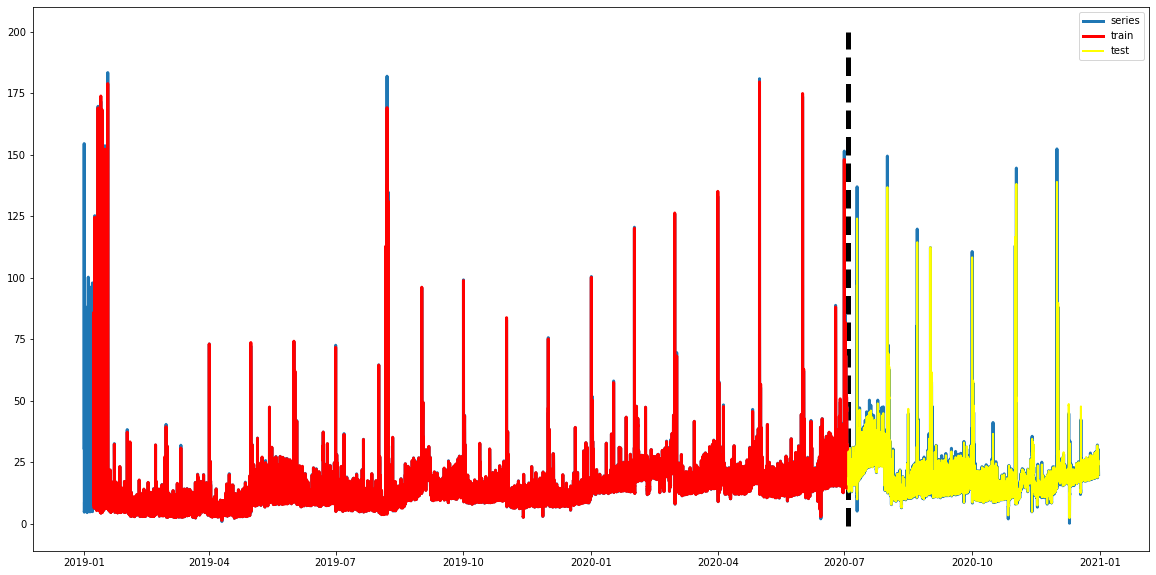

In [15]:
plt.figure(figsize=(20,10))
plt.plot(series,linewidth=3,label='series')
plt.vlines(X.index[-1440*6],-1,200,linestyles = "dashed",linewidth=5)
plt.plot(X.index[:-1440*6],trainpre,color='red',label='train',linewidth=3)
plt.plot(X.index[-1440*6:],preds,color='yellow',label='test', linewidth=2)
plt.legend()
plt.show()

# 特征筛选

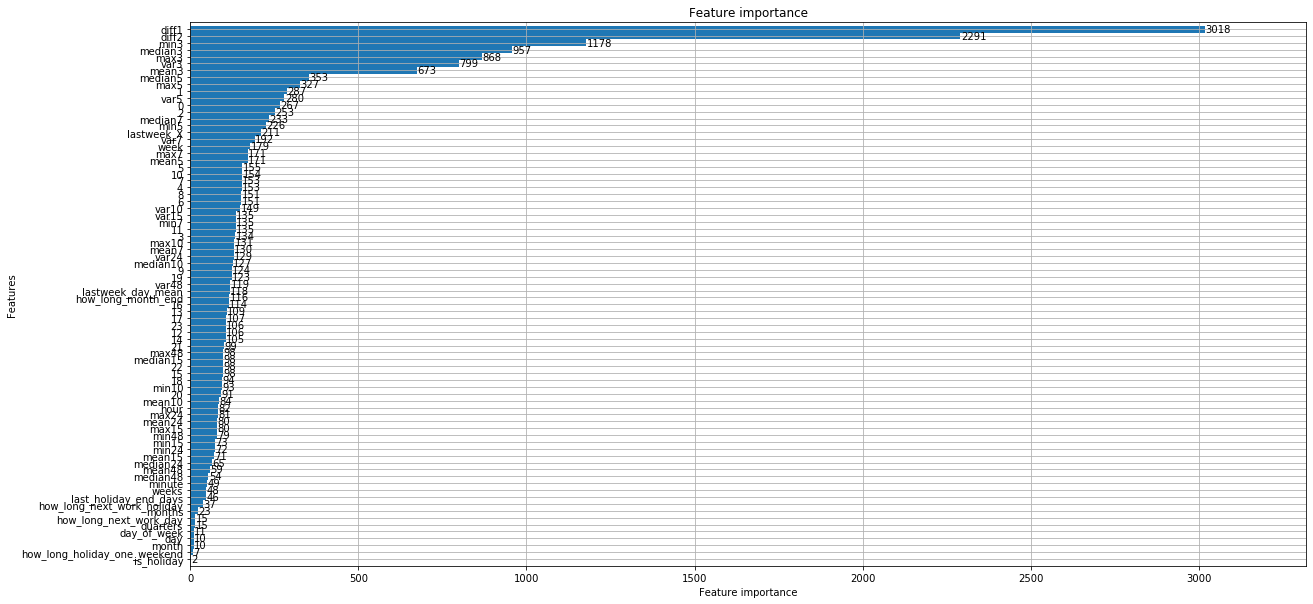

In [16]:
lgb.plot_importance(gbm,height=1,figsize=(20,10))
plt.show()

In [17]:
#取重要性大于70分位数的特征
percent = np.percentile(gbm.feature_importance(),70)
features = [gbm.feature_name()[i] for i in np.where(gbm.feature_importance()>=percent)[0]]
features

['0',
 '1',
 '2',
 '4',
 '5',
 '7',
 '10',
 'max3',
 'min3',
 'mean3',
 'var3',
 'median3',
 'max5',
 'min5',
 'mean5',
 'var5',
 'median5',
 'max7',
 'var7',
 'median7',
 'diff1',
 'diff2',
 'lastweek_X',
 'week']

# 使用筛选后的特征建模

In [18]:
X1 = X.iloc[:,np.where(gbm.feature_importance()>=percent)[0]]
#测试集6个月
X_train1 = X1[:-1440*6]
X_test1 = X1[-1440*6:]

In [19]:
def objective1(trial):
    dtrain1 = lgb.Dataset(X_train1, label=y_train,categorical_feature=['week'])
    dvalid1 = lgb.Dataset(X_test1, label=y_test,categorical_feature=['week'])
    
    param1 = {
        "objective": "regression",  #目标函数
        "metric": "rmse",  #评估函数
        "boosting_type": "gbdt",   #提升类型
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),   #叶子节点数
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),   #建树的特征选择比例
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),  #建树的样本采样比例
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),   # k意味着每k次迭代执行bagging
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse") #剪枝
    gbm1 = lgb.train(param1, dtrain1, valid_sets=[dvalid1],callbacks=[pruning_callback])
    preds1 = gbm1.predict(X_test1)
    rmse = mean_squared_error(y_test, preds1)**0.5
    return rmse

In [20]:
study1 = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="minimize")  #优化方向RMSE最小
study1.optimize(objective1, n_trials=100, timeout=600) #100个trial或者600秒停止

print("Number of finished trials: ", len(study1.trials))
print("Best trial:")
trial1 = study1.best_trial

print("  Value: {}".format(trial1.value))
print("  Params: ")
for key, value in trial1.params.items():
    print("    {}: {}".format(key, value))

[I 2021-03-29 17:38:11,523] A new study created in memory with name: no-name-1e13489c-8876-4289-a357-078442cc85b1


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13659
[2]	valid_0's rmse: 7.38792
[3]	valid_0's rmse: 6.72072
[4]	valid_0's rmse: 6.17659
[5]	valid_0's rmse: 5.68663
[6]	valid_0's rmse: 5.21808
[7]	valid_0's rmse: 4.79789
[8]	valid_0's rmse: 4.45345
[9]	valid_0's rmse: 4.1365
[10]	valid_0's rmse: 3.85324
[11]	valid_0's rmse: 3.61284
[12]	valid_0's rmse: 3.41126
[13]	valid_0's rmse: 3.24039
[14]	valid_0's rmse: 3.09006
[15]	valid_0's rmse: 2.97534
[16]	valid_0's rmse: 2.84748
[17]	valid_0's rmse: 2.74425
[18]	valid_0's rmse: 2.66075
[19]	valid_0's rmse: 2.58797
[20]	valid_0's rmse: 2.53685
[21]	valid_0's rmse: 2.49098
[22]	valid_0's rmse: 2.44456
[23]	valid_0's rmse: 2.406

[I 2021-03-29 17:38:11,917] Trial 0 finished with value: 1.5696232400545767 and parameters: {'lambda_l1': 0.008640665881382611, 'lambda_l2': 0.00023210121384526806, 'num_leaves': 26, 'feature_fraction': 0.9063299339771915, 'bagging_fraction': 0.5341421781872615, 'bagging_freq': 3, 'min_child_samples': 49}. Best is trial 0 with value: 1.5696232400545767.


[59]	valid_0's rmse: 1.79295
[60]	valid_0's rmse: 1.78813
[61]	valid_0's rmse: 1.77869
[62]	valid_0's rmse: 1.76866
[63]	valid_0's rmse: 1.76084
[64]	valid_0's rmse: 1.7602
[65]	valid_0's rmse: 1.76098
[66]	valid_0's rmse: 1.76088
[67]	valid_0's rmse: 1.75599
[68]	valid_0's rmse: 1.75336
[69]	valid_0's rmse: 1.74961
[70]	valid_0's rmse: 1.74387
[71]	valid_0's rmse: 1.73844
[72]	valid_0's rmse: 1.73519
[73]	valid_0's rmse: 1.71209
[74]	valid_0's rmse: 1.69872
[75]	valid_0's rmse: 1.68015
[76]	valid_0's rmse: 1.67028
[77]	valid_0's rmse: 1.66246
[78]	valid_0's rmse: 1.65808
[79]	valid_0's rmse: 1.64475
[80]	valid_0's rmse: 1.64685
[81]	valid_0's rmse: 1.63346
[82]	valid_0's rmse: 1.62995
[83]	valid_0's rmse: 1.62822
[84]	valid_0's rmse: 1.62786
[85]	valid_0's rmse: 1.62232
[86]	valid_0's rmse: 1.61803
[87]	valid_0's rmse: 1.61713
[88]	valid_0's rmse: 1.60643
[89]	valid_0's rmse: 1.58651
[90]	valid_0's rmse: 1.57989
[91]	valid_0's rmse: 1.57818
[92]	valid_0's rmse: 1.57547
[93]	valid_0's 

C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.12705
[2]	valid_0's rmse: 7.33969
[3]	valid_0's rmse: 6.63787
[4]	valid_0's rmse: 6.06154
[5]	valid_0's rmse: 5.5023
[6]	valid_0's rmse: 5.02905
[7]	valid_0's rmse: 4.62428
[8]	valid_0's rmse: 4.22905
[9]	valid_0's rmse: 3.90169
[10]	valid_0's rmse: 3.63559
[11]	valid_0's rmse: 3.36308
[12]	valid_0's rmse: 3.17645
[13]	valid_0's rmse: 2.97771
[14]	valid_0's rmse: 2.8123
[15]	valid_0's rmse: 2.65991
[16]	valid_0's rmse: 2.53559
[17]	valid_0's rmse: 2.43582
[18]	valid_0's rmse: 2.34362
[19]	valid_0's rmse: 2.27031
[20]	valid_0's rmse: 2.1972
[21]	valid_0's rmse: 2.14727
[22]	valid_0's rmse: 2.09346
[23]	valid_0's rmse: 2.05079

[I 2021-03-29 17:38:13,147] Trial 1 finished with value: 1.539875248702466 and parameters: {'lambda_l1': 0.15189873161304462, 'lambda_l2': 0.002908730264906284, 'num_leaves': 227, 'feature_fraction': 0.8076068611405625, 'bagging_fraction': 0.41812123497027426, 'bagging_freq': 7, 'min_child_samples': 22}. Best is trial 1 with value: 1.539875248702466.



[94]	valid_0's rmse: 1.55889
[95]	valid_0's rmse: 1.55168
[96]	valid_0's rmse: 1.56044
[97]	valid_0's rmse: 1.5584
[98]	valid_0's rmse: 1.5409
[99]	valid_0's rmse: 1.54147
[100]	valid_0's rmse: 1.53988


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 8.07962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 7.30933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 6.62366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.05533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 5.5116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 5.03134
[LightGBM] [Warning] No further split

[82]	valid_0's rmse: 1.63863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[83]	valid_0's rmse: 1.63495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[84]	valid_0's rmse: 1.62839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[85]	valid_0's rmse: 1.61657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[86]	valid_0's rmse: 1.61265
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[87]	valid_0's rmse: 1.61024
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[88]	valid_0's rmse: 1.60832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[89]	valid_0's rmse: 1.60573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	valid_0's rmse: 1.60582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	valid_0's rmse: 1.6043
[LightGBM] [Warning] No further spli

[I 2021-03-29 17:38:14,000] Trial 2 finished with value: 1.572390338616519 and parameters: {'lambda_l1': 2.4909679570894463, 'lambda_l2': 0.4467167717707575, 'num_leaves': 163, 'feature_fraction': 0.8669409528883185, 'bagging_fraction': 0.8813751186907638, 'bagging_freq': 1, 'min_child_samples': 64}. Best is trial 1 with value: 1.539875248702466.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.22255
[2]	valid_0's rmse: 7.516
[3]	valid_0's rmse: 6.89036
[4]	valid_0's rmse: 6.30574
[5]	valid_0's rmse: 5.79289
[6]	valid_0's rmse: 5.36795
[7]	valid_0's rmse: 4.95862
[8]	valid_0's rmse: 4.62883
[9]	valid_0's rmse: 4.31961
[10]	valid_0's rmse: 4.04237
[11]	valid_0's rmse: 3.80311
[12]	valid_0's rmse: 3.60133
[13]	valid_0's rmse: 3.46009
[14]	valid_0's rmse: 3.33878
[15]	valid_0's rmse: 3.2411
[16]	valid_0's rmse: 3.14925
[17]	valid_0's rmse: 3.0709
[18]	valid_0's rmse: 3.01081
[19]	valid_0's rmse: 2.94924
[20]	valid_0's rmse: 2.90796
[21]	valid_0's rmse: 2.87855
[22]	valid_0's rmse: 2.85265
[23]	valid_0's rmse: 2.83388


[I 2021-03-29 17:38:14,762] Trial 3 finished with value: 2.2013232662198945 and parameters: {'lambda_l1': 0.007856956439860919, 'lambda_l2': 0.004003813012613294, 'num_leaves': 81, 'feature_fraction': 0.9712261583790712, 'bagging_fraction': 0.4673833697791545, 'bagging_freq': 3, 'min_child_samples': 89}. Best is trial 1 with value: 1.539875248702466.


[91]	valid_0's rmse: 2.18586
[92]	valid_0's rmse: 2.18739
[93]	valid_0's rmse: 2.18495
[94]	valid_0's rmse: 2.18119
[95]	valid_0's rmse: 2.17915
[96]	valid_0's rmse: 2.17774
[97]	valid_0's rmse: 2.19229
[98]	valid_0's rmse: 2.20807
[99]	valid_0's rmse: 2.21289
[100]	valid_0's rmse: 2.20132


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 8.12885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 7.40046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 6.80811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.28546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 5.85626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 5.42053
[LightGBM] [Warning] No further spli

[80]	valid_0's rmse: 2.27531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[81]	valid_0's rmse: 2.28191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[82]	valid_0's rmse: 2.27935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[83]	valid_0's rmse: 2.27544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[84]	valid_0's rmse: 2.26918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[85]	valid_0's rmse: 2.26819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[86]	valid_0's rmse: 2.26341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[87]	valid_0's rmse: 2.25825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[88]	valid_0's rmse: 2.25504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[89]	valid_0's rmse: 2.2579
[LightGBM] [Warning] No further spli

[I 2021-03-29 17:38:15,675] Trial 4 finished with value: 2.2371303983230115 and parameters: {'lambda_l1': 0.028130630918651946, 'lambda_l2': 5.195164497446594e-05, 'num_leaves': 153, 'feature_fraction': 0.49953514623336975, 'bagging_fraction': 0.5973944029663683, 'bagging_freq': 3, 'min_child_samples': 100}. Best is trial 1 with value: 1.539875248702466.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13882
[2]	valid_0's rmse: 7.36892
[3]	valid_0's rmse: 6.70354
[4]	valid_0's rmse: 6.18208
[5]	valid_0's rmse: 5.72367
[6]	valid_0's rmse: 5.23236
[7]	valid_0's rmse: 4.80731
[8]	valid_0's rmse: 4.4227
[9]	valid_0's rmse: 4.08758
[10]	valid_0's rmse: 3.84091
[11]	valid_0's rmse: 3.53166
[12]	valid_0's rmse: 3.3201
[13]	valid_0's rmse: 3.13636
[14]	valid_0's rmse: 2.97788
[15]	valid_0's rmse: 2.776
[16]	valid_0's rmse: 2.658
[17]	valid_0's rmse: 2.56181
[18]	valid_0's rmse: 2.40077
[19]	valid_0's rmse: 2.33682
[20]	valid_0's rmse: 2.21554
[21]	valid_0's rmse: 2.1161
[22]	valid_0's rmse: 2.08492
[23]	valid_0's rmse: 2.04318
[24

[I 2021-03-29 17:38:16,258] Trial 5 finished with value: 1.338186957427354 and parameters: {'lambda_l1': 3.557180977352601e-05, 'lambda_l2': 4.074748538207114e-06, 'num_leaves': 28, 'feature_fraction': 0.43255984107491907, 'bagging_fraction': 0.9004448460724727, 'bagging_freq': 3, 'min_child_samples': 15}. Best is trial 5 with value: 1.338186957427354.


[83]	valid_0's rmse: 1.37434
[84]	valid_0's rmse: 1.371
[85]	valid_0's rmse: 1.37194
[86]	valid_0's rmse: 1.36921
[87]	valid_0's rmse: 1.35614
[88]	valid_0's rmse: 1.35754
[89]	valid_0's rmse: 1.35584
[90]	valid_0's rmse: 1.36103
[91]	valid_0's rmse: 1.34905
[92]	valid_0's rmse: 1.35267
[93]	valid_0's rmse: 1.35247
[94]	valid_0's rmse: 1.3489
[95]	valid_0's rmse: 1.3499
[96]	valid_0's rmse: 1.34952
[97]	valid_0's rmse: 1.34772
[98]	valid_0's rmse: 1.34442
[99]	valid_0's rmse: 1.34085
[100]	valid_0's rmse: 1.33819
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002565 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.12374
[2]	valid_0's rmse: 7.3129
[3]	valid_0's rmse: 6.60795
[4]	valid_0's rmse: 5.99425
[5]	valid_0's rmse: 5.4546
[6]	valid_0's rmse: 4.96648
[7]	valid_0's rmse: 4.57553
[8]	valid_0's rmse: 4.23733
[9]	valid_0's rmse: 3.94392
[10]	valid_0's rmse: 3.636
[11]	valid_0's rmse: 3.38502
[12]	valid_0's rmse: 3.19087
[13]	valid_0's rmse: 2.99364
[14]	valid_0's rmse: 2.82529
[15]	valid_0's rmse: 2.68639
[16]	valid_0's rmse: 2.57199
[17]	valid_0's rmse: 2.46237
[18]	valid_0's rmse: 2.383
[19]	valid_0's rmse: 2.27958
[20]	valid_0's rmse: 2.19823
[21]	valid_0's rmse: 2.12967
[22]	valid_0's rmse: 2.07187
[23]	valid_0's rmse: 2.03111
[24]	valid_0's rmse: 2.00079
[25]	valid_0's rmse: 1.96397
[26]	valid_0's rmse: 1.93395
[27]	valid_0's rmse: 1.9174
[28]	valid_0's rmse: 1.89296
[29]	valid_0's rmse: 1.

[I 2021-03-29 17:38:17,554] Trial 6 finished with value: 1.4881576114425146 and parameters: {'lambda_l1': 1.2490102753146468e-06, 'lambda_l2': 8.189424517012477e-05, 'num_leaves': 155, 'feature_fraction': 0.9670822143267537, 'bagging_fraction': 0.4836372146119782, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 5 with value: 1.338186957427354.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:38:17,706] Trial 7 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.1547
[2]	valid_0's rmse: 7.42776
[3]	valid_0's rmse: 6.8165
[4]	valid_0's rmse: 6.26833
[5]	valid_0's rmse: 5.82823
[6]	valid_0's rmse: 5.35578
[7]	valid_0's rmse: 4.91089
[8]	valid_0's rmse: 4.56822
[9]	valid_0's rmse: 4.25489
[10]	valid_0's rmse: 4.02145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[LightGBM] [Warning] No furth

[I 2021-03-29 17:38:18,896] Trial 8 finished with value: 1.306320997827134 and parameters: {'lambda_l1': 1.1317144336181696e-06, 'lambda_l2': 6.567284944960521, 'num_leaves': 149, 'feature_fraction': 0.9660105250673549, 'bagging_fraction': 0.8433653829034713, 'bagging_freq': 7, 'min_child_samples': 36}. Best is trial 8 with value: 1.306320997827134.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:38:19,067] Trial 9 pruned. Trial was pruned at iteration 12.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13033
[2]	valid_0's rmse: 7.40588
[3]	valid_0's rmse: 6.71261
[4]	valid_0's rmse: 6.14214
[5]	valid_0's rmse: 5.61227
[6]	valid_0's rmse: 5.1369
[7]	valid_0's rmse: 4.72129
[8]	valid_0's rmse: 4.31084
[9]	valid_0's rmse: 3.97341
[10]	valid_0's rmse: 3.714
[11]	valid_0's rmse: 3.46301
[12]	valid_0's rmse: 3.27167
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002781 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2021-03-29 17:38:19,265] Trial 10 pruned. Trial was pruned at iteration 10.


[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 8.07589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 7.29893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 6.63869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.11556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 5.63094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 5.15991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's rmse: 4.77018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	valid_0's rmse: 4.4

[I 2021-03-29 17:38:19,391] Trial 11 pruned. Trial was pruned at iteration 10.


[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.1481
[2]	valid_0's rmse: 7.37081
[3]	valid_0's rmse: 6.71859
[4]	valid_0's rmse: 6.19584
[5]	valid_0's rmse: 5.73951
[6]	valid_0's rmse: 5.27669
[7]	valid_0's rmse: 4.87108
[8]	valid_0's rmse: 4.4719
[9]	valid_0's rmse: 4.13032
[10]	valid_0's rmse: 3.87517
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.11935
[2]	valid_0's rmse: 7.30729
[3]	valid_0's rmse: 6.61349
[4]	valid_0's rmse: 6.02959
[5]	valid_0's rmse: 5.50655
[6]	valid_0's rmse: 4.98639
[7]	valid_0's rmse: 4.5201

[I 2021-03-29 17:38:20,823] Trial 12 finished with value: 1.3275730608853202 and parameters: {'lambda_l1': 2.950257371459425e-08, 'lambda_l2': 9.690210633702972e-07, 'num_leaves': 201, 'feature_fraction': 0.6703127323150366, 'bagging_fraction': 0.9900257355617502, 'bagging_freq': 2, 'min_child_samples': 7}. Best is trial 8 with value: 1.306320997827134.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.08887
[2]	valid_0's rmse: 7.29169
[3]	valid_0's rmse: 6.59195
[4]	valid_0's rmse: 5.99708
[5]	valid_0's rmse: 5.48845
[6]	valid_0's rmse: 4.99564
[7]	valid_0's rmse: 4.52708
[8]	valid_0's rmse: 4.11722
[9]	valid_0's rmse: 3.80395
[10]	valid_0's rmse: 3.56168
[11]	valid_0's rmse: 3.28283
[12]	valid_0's rmse: 3.0978
[13]	valid_0's rmse: 2.8812
[14]	valid_0's rmse: 2.6999
[15]	valid_0's rmse: 2.53467
[16]	valid_0's rmse: 2.37839
[17]	valid_0's rmse: 2.25049
[18]	valid_0's rmse: 2.14682
[19]	valid_0's rmse: 2.05998
[20]	valid_0's rmse: 1.98676
[21]	valid_0's rmse: 1.93132
[22]	valid_0's rmse: 1.88405
[23]	valid_0's rmse: 1.84074

[I 2021-03-29 17:38:22,391] Trial 13 finished with value: 1.3596987890853696 and parameters: {'lambda_l1': 1.3524781746511665e-08, 'lambda_l2': 1.8906906111800724e-08, 'num_leaves': 218, 'feature_fraction': 0.6814400142264133, 'bagging_fraction': 0.9988586719773695, 'bagging_freq': 2, 'min_child_samples': 40}. Best is trial 8 with value: 1.306320997827134.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.12455
[2]	valid_0's rmse: 7.32347
[3]	valid_0's rmse: 6.64095
[4]	valid_0's rmse: 6.08185
[5]	valid_0's rmse: 5.58289
[6]	valid_0's rmse: 5.05698
[7]	valid_0's rmse: 4.60579
[8]	valid_0's rmse: 4.18261
[9]	valid_0's rmse: 3.88353
[10]	valid_0's rmse: 3.60476
[11]	valid_0's rmse: 3.29597
[12]	valid_0's rmse: 3.07206
[13]	valid_0's rmse: 2.8352
[14]	valid_0's rmse: 2.62895
[15]	valid_0's rmse: 2.46486
[16]	valid_0's rmse: 2.29552
[17]	valid_0's rmse: 2.15456
[18]	valid_0's rmse: 2.02534
[19]	valid_0's rmse: 1.90878
[20]	valid_0's rmse: 1.81978
[21]	valid_0's rmse: 1.7361
[22]	valid_0's rmse: 1.67146
[23]	valid_0's rmse: 1.6048

[I 2021-03-29 17:38:23,696] Trial 14 finished with value: 1.3089849389622858 and parameters: {'lambda_l1': 1.8627809280629134e-07, 'lambda_l2': 0.10661751573843084, 'num_leaves': 185, 'feature_fraction': 0.6040990683407651, 'bagging_fraction': 0.8273406614712433, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 8 with value: 1.306320997827134.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:38:23,886] Trial 15 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.08138
[2]	valid_0's rmse: 7.30447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 6.69417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.16377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 5.71232
[6]	valid_0's rmse: 5.26912
[7]	valid_0's rmse: 4.85339
[8]	valid_0's rmse: 4.5203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9]	valid_0's rmse: 4.23263
[10]	valid_0's rmse: 4.01219
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead 

[I 2021-03-29 17:38:24,065] Trial 16 pruned. Trial was pruned at iteration 10.


[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 8.19598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 7.46013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 6.79794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.24856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 5.73493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 5.24638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's rmse: 4.79917
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	valid_0's rmse: 4.4

[I 2021-03-29 17:38:24,223] Trial 17 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 8.13529
[2]	valid_0's rmse: 7.34196
[3]	valid_0's rmse: 6.66126
[4]	valid_0's rmse: 6.15164
[5]	valid_0's rmse: 5.63303
[6]	valid_0's rmse: 5.11094
[7]	valid_0's rmse: 4.67697
[8]	valid_0's rmse: 4.26144
[9]	valid_0's rmse: 3.94535
[10]	valid_0's rmse: 3.68302
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.095
[2]	valid_0's rmse: 7.32169
[3]	valid_0's rmse: 6.61938
[4]	valid_0's rmse: 6.03418
[5]	valid_0's rmse: 5.46926
[6]	valid_0's rmse: 4.96549
[7]	valid_0's rmse: 4.50696
[8]	valid_0's rmse: 4.11322
[9]	valid_0's rmse: 3.76575
[10]	valid_0's rmse: 3.46007
[11]	valid_0's rmse: 3.16697
[12]	valid_0's rmse: 2.95749
[13]	valid_0's rmse: 2.73596
[14]	va

[I 2021-03-29 17:38:25,489] Trial 18 finished with value: 1.1855659597128265 and parameters: {'lambda_l1': 3.2060891776919363e-06, 'lambda_l2': 0.0230498029154647, 'num_leaves': 179, 'feature_fraction': 0.7664979419312484, 'bagging_fraction': 0.8085263011149502, 'bagging_freq': 5, 'min_child_samples': 27}. Best is trial 18 with value: 1.1855659597128265.


[94]	valid_0's rmse: 1.20545
[95]	valid_0's rmse: 1.19838
[96]	valid_0's rmse: 1.19686
[97]	valid_0's rmse: 1.19478
[98]	valid_0's rmse: 1.19007
[99]	valid_0's rmse: 1.18756
[100]	valid_0's rmse: 1.18557


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.1276
[2]	valid_0's rmse: 7.34193
[3]	valid_0's rmse: 6.65232
[4]	valid_0's rmse: 6.05419
[5]	valid_0's rmse: 5.48631
[6]	valid_0's rmse: 4.98637
[7]	valid_0's rmse: 4.54842
[8]	valid_0's rmse: 4.16128
[9]	valid_0's rmse: 3.81638
[10]	valid_0's rmse: 3.52774
[11]	valid_0's rmse: 3.22885
[12]	valid_0's rmse: 3.03116
[13]	valid_0's rmse: 2.79046
[14]	valid_0's rmse: 2.56768
[15]	valid_0's rmse: 2.39397
[16]	valid_0's rmse: 2.23407
[17]	valid_0's rmse: 2.108
[18]	valid_0's rmse: 1.98856
[19]	valid_0's rmse: 1.88363
[20]	valid_0's rmse: 1.81828
[21]	valid_0's rmse: 1.74493
[22]	valid_0's rmse: 1.6566
[23]	valid_0's rmse: 1.60616


[I 2021-03-29 17:38:26,634] Trial 19 finished with value: 1.1228394192394335 and parameters: {'lambda_l1': 4.843044794780819e-06, 'lambda_l2': 0.01575448500961237, 'num_leaves': 142, 'feature_fraction': 0.7906458435526805, 'bagging_fraction': 0.9120220793426369, 'bagging_freq': 7, 'min_child_samples': 30}. Best is trial 19 with value: 1.1228394192394335.


[99]	valid_0's rmse: 1.12592
[100]	valid_0's rmse: 1.12284
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001935 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.12037
[2]	valid_0's rmse: 7.33495
[3]	valid_0's rmse: 6.62052
[4]	valid_0's rmse: 6.0549
[5]	valid_0's rmse: 5.49249
[6]	valid_0's rmse: 4.97697
[7]	valid_0's rmse: 4.52087
[8]	valid_0's rmse: 4.12101
[9]	valid_0's rmse: 3.76782
[10]	valid_0's rmse: 3.46503
[11]	valid_0's rmse: 3.18818
[12]	valid_0's rmse: 2.96068
[13]	valid_0's rmse: 2.73974
[14]	valid_0's rmse: 2.54112
[15]	valid_0's rmse: 2.37498
[16]	valid_0's rmse: 2.23045
[17]	valid_0's rmse: 2.11382
[18]	valid_0's rmse: 2.00665
[19]	valid_0's rmse: 1.88842
[20]	valid_0's rmse: 1.8266
[21]	valid_0's rmse: 1.74823
[22]	valid_0's rmse: 1.70768
[23]	valid_0's rmse: 1.65469
[24]	valid_0's rmse: 1.59759
[25]	valid_0's rmse: 1.55845
[26]	valid_0's rmse: 1.54267
[27]	valid_0's rmse: 1.5187
[28]	valid_0's rmse: 1.50912
[29]	valid_0's rmse

[I 2021-03-29 17:38:27,356] Trial 20 finished with value: 1.2298239074417476 and parameters: {'lambda_l1': 9.986086770236438e-06, 'lambda_l2': 0.029485315880898068, 'num_leaves': 62, 'feature_fraction': 0.7677386590928776, 'bagging_fraction': 0.9302712072615684, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 19 with value: 1.1228394192394335.


[96]	valid_0's rmse: 1.21489
[97]	valid_0's rmse: 1.21737
[98]	valid_0's rmse: 1.22213
[99]	valid_0's rmse: 1.22525
[100]	valid_0's rmse: 1.22982
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13083


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[2]	valid_0's rmse: 7.35064
[3]	valid_0's rmse: 6.63323
[4]	valid_0's rmse: 6.05905
[5]	valid_0's rmse: 5.49816
[6]	valid_0's rmse: 4.97825
[7]	valid_0's rmse: 4.52692
[8]	valid_0's rmse: 4.11744
[9]	valid_0's rmse: 3.77588
[10]	valid_0's rmse: 3.49028
[11]	valid_0's rmse: 3.19608
[12]	valid_0's rmse: 2.97432
[13]	valid_0's rmse: 2.74055
[14]	valid_0's rmse: 2.5312
[15]	valid_0's rmse: 2.35349
[16]	valid_0's rmse: 2.20344
[17]	valid_0's rmse: 2.084
[18]	valid_0's rmse: 1.97748
[19]	valid_0's rmse: 1.90178
[20]	valid_0's rmse: 1.79794
[21]	valid_0's rmse: 1.71438
[22]	valid_0's rmse: 1.66745
[23]	valid_0's rmse: 1.61416
[24]	valid_0's rmse: 1.57028
[25]	valid_0's rmse: 1.53037
[26]	valid_0's rmse: 1.49822
[27]	valid_0's rmse: 1.48662
[28]	valid_0's rmse: 1.47155
[29]	valid_0's rmse: 1.45865
[30]	valid_0's rmse: 1.4353
[31]	valid_0's rmse: 1.42388
[32]	valid_0's rmse: 1.40243
[33]	valid_0's rmse: 1.38966
[34]	valid_0's rmse: 1.38298
[35]	valid_0's rmse: 1.36485
[36]	valid_0's rmse: 1.362

[I 2021-03-29 17:38:28,189] Trial 21 finished with value: 1.1848198108411174 and parameters: {'lambda_l1': 1.2279653647350663e-05, 'lambda_l2': 0.016219100560103908, 'num_leaves': 71, 'feature_fraction': 0.7842267223038939, 'bagging_fraction': 0.932585861844721, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 19 with value: 1.1228394192394335.


[87]	valid_0's rmse: 1.18899
[88]	valid_0's rmse: 1.18806
[89]	valid_0's rmse: 1.1908
[90]	valid_0's rmse: 1.19756
[91]	valid_0's rmse: 1.19615
[92]	valid_0's rmse: 1.18865
[93]	valid_0's rmse: 1.18686
[94]	valid_0's rmse: 1.1855
[95]	valid_0's rmse: 1.17937
[96]	valid_0's rmse: 1.17427
[97]	valid_0's rmse: 1.17734
[98]	valid_0's rmse: 1.17804
[99]	valid_0's rmse: 1.18125
[100]	valid_0's rmse: 1.18482


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.11499
[2]	valid_0's rmse: 7.32269
[3]	valid_0's rmse: 6.62995
[4]	valid_0's rmse: 6.03549
[5]	valid_0's rmse: 5.45997
[6]	valid_0's rmse: 4.94957
[7]	valid_0's rmse: 4.49194
[8]	valid_0's rmse: 4.09741
[9]	valid_0's rmse: 3.72682
[10]	valid_0's rmse: 3.40419
[11]	valid_0's rmse: 3.11988
[12]	valid_0's rmse: 2.91111
[13]	valid_0's rmse: 2.67977
[14]	valid_0's rmse: 2.49777
[15]	valid_0's rmse: 2.3259
[16]	valid_0's rmse: 2.15271
[17]	valid_0's rmse: 2.00212
[18]	valid_0's rmse: 1.86848
[19]	valid_0's rmse: 1.75198
[20]	valid_0's rmse: 1.68246
[21]	valid_0's rmse: 1.60897
[22]	valid_0's rmse: 1.54631
[23]	valid_0's rmse: 1.498

[I 2021-03-29 17:38:29,248] Trial 22 finished with value: 1.125725121786932 and parameters: {'lambda_l1': 0.0005586623385166497, 'lambda_l2': 0.00865221142408227, 'num_leaves': 128, 'feature_fraction': 0.8329498781420879, 'bagging_fraction': 0.7726722710345891, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 19 with value: 1.1228394192394335.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.11452
[2]	valid_0's rmse: 7.31255
[3]	valid_0's rmse: 6.58585
[4]	valid_0's rmse: 5.98184
[5]	valid_0's rmse: 5.42084
[6]	valid_0's rmse: 4.90061
[7]	valid_0's rmse: 4.44743
[8]	valid_0's rmse: 4.0335
[9]	valid_0's rmse: 3.6542
[10]	valid_0's rmse: 3.34923
[11]	valid_0's rmse: 3.06894
[12]	valid_0's rmse: 2.86127
[13]	valid_0's rmse: 2.64329
[14]	valid_0's rmse: 2.44732
[15]	valid_0's rmse: 2.26832
[16]	valid_0's rmse: 2.11356
[17]	valid_0's rmse: 1.99225
[18]	valid_0's rmse: 1.88864
[19]	valid_0's rmse: 1.8032
[20]	valid_0's rmse: 1.7076
[21]	valid_0's rmse: 1.65784
[22]	valid_0's rmse: 1.59289
[23]	valid_0's rmse: 1.53575


[I 2021-03-29 17:38:30,397] Trial 23 finished with value: 1.097284425364432 and parameters: {'lambda_l1': 0.0007255213213943345, 'lambda_l2': 0.0034240314094571987, 'num_leaves': 128, 'feature_fraction': 0.8380636940075044, 'bagging_fraction': 0.9284511978231103, 'bagging_freq': 7, 'min_child_samples': 16}. Best is trial 23 with value: 1.097284425364432.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.11381
[2]	valid_0's rmse: 7.32561
[3]	valid_0's rmse: 6.6257
[4]	valid_0's rmse: 6.02919
[5]	valid_0's rmse: 5.47235
[6]	valid_0's rmse: 4.94415
[7]	valid_0's rmse: 4.49761
[8]	valid_0's rmse: 4.07711
[9]	valid_0's rmse: 3.71454
[10]	valid_0's rmse: 3.39546
[11]	valid_0's rmse: 3.10718
[12]	valid_0's rmse: 2.90235
[13]	valid_0's rmse: 2.68129
[14]	valid_0's rmse: 2.50282
[15]	valid_0's rmse: 2.32205
[16]	valid_0's rmse: 2.17377
[17]	valid_0's rmse: 2.05486
[18]	valid_0's rmse: 1.9463
[19]	valid_0's rmse: 1.86674
[20]	valid_0's rmse: 1.79701
[21]	valid_0's rmse: 1.74177
[22]	valid_0's rmse: 1.67572
[23]	valid_0's rmse: 1.6167

[I 2021-03-29 17:38:31,577] Trial 24 finished with value: 1.1599761183075372 and parameters: {'lambda_l1': 0.0007868264046289159, 'lambda_l2': 0.0015208736531924926, 'num_leaves': 128, 'feature_fraction': 0.8473732573686327, 'bagging_fraction': 0.7586473689738792, 'bagging_freq': 7, 'min_child_samples': 15}. Best is trial 23 with value: 1.097284425364432.



[97]	valid_0's rmse: 1.16227
[98]	valid_0's rmse: 1.16472
[99]	valid_0's rmse: 1.16236
[100]	valid_0's rmse: 1.15998


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.1263
[2]	valid_0's rmse: 7.32925
[3]	valid_0's rmse: 6.60733
[4]	valid_0's rmse: 5.99034
[5]	valid_0's rmse: 5.38733
[6]	valid_0's rmse: 4.87372
[7]	valid_0's rmse: 4.41017
[8]	valid_0's rmse: 4.00562
[9]	valid_0's rmse: 3.64924
[10]	valid_0's rmse: 3.3421
[11]	valid_0's rmse: 3.06211
[12]	valid_0's rmse: 2.83246
[13]	valid_0's rmse: 2.60228
[14]	valid_0's rmse: 2.40021
[15]	valid_0's rmse: 2.21543
[16]	valid_0's rmse: 2.07093
[17]	valid_0's rmse: 1.93873
[18]	valid_0's rmse: 1.82753
[19]	valid_0's rmse: 1.73387
[20]	valid_0's rmse: 1.65976
[21]	valid_0's rmse: 1.59449
[22]	valid_0's rmse: 1.52144
[23]	valid_0's rmse: 1.4629

[I 2021-03-29 17:38:32,574] Trial 25 finished with value: 1.1538681486739155 and parameters: {'lambda_l1': 0.0010662864007178786, 'lambda_l2': 0.007208819618021407, 'num_leaves': 105, 'feature_fraction': 0.8401296759967511, 'bagging_fraction': 0.9474605748361198, 'bagging_freq': 4, 'min_child_samples': 16}. Best is trial 23 with value: 1.097284425364432.


[92]	valid_0's rmse: 1.13779
[93]	valid_0's rmse: 1.13796
[94]	valid_0's rmse: 1.13763
[95]	valid_0's rmse: 1.14144
[96]	valid_0's rmse: 1.14383
[97]	valid_0's rmse: 1.14906
[98]	valid_0's rmse: 1.1502
[99]	valid_0's rmse: 1.15105
[100]	valid_0's rmse: 1.15387


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:38:32,768] Trial 26 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.07853
[2]	valid_0's rmse: 7.30537
[3]	valid_0's rmse: 6.62129
[4]	valid_0's rmse: 6.09163
[5]	valid_0's rmse: 5.54356
[6]	valid_0's rmse: 5.06209
[7]	valid_0's rmse: 4.64984
[8]	valid_0's rmse: 4.28675
[9]	valid_0's rmse: 3.97808
[10]	valid_0's rmse: 3.6749
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003201 seconds.
You can set `force_col_wise=true` to remove the overhead.

[I 2021-03-29 17:38:33,015] Trial 27 pruned. Trial was pruned at iteration 16.



[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13823
[2]	valid_0's rmse: 7.37838
[3]	valid_0's rmse: 6.66987
[4]	valid_0's rmse: 6.08167
[5]	valid_0's rmse: 5.51787
[6]	valid_0's rmse: 5.01983
[7]	valid_0's rmse: 4.57269
[8]	valid_0's rmse: 4.17877
[9]	valid_0's rmse: 3.83586
[10]	valid_0's rmse: 3.53513
[11]	valid_0's rmse: 3.25703
[12]	valid_0's rmse: 3.01379
[13]	valid_0's rmse: 2.79432
[14]	valid_0's rmse: 2.59602
[15]	valid_0's rmse: 2.42875
[16]	valid_0's rmse: 2.29448


[I 2021-03-29 17:38:33,215] Trial 28 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.09687
[2]	valid_0's rmse: 7.30674
[3]	valid_0's rmse: 6.61702
[4]	valid_0's rmse: 6.05858
[5]	valid_0's rmse: 5.49236
[6]	valid_0's rmse: 4.99067
[7]	valid_0's rmse: 4.56379
[8]	valid_0's rmse: 4.18425
[9]	valid_0's rmse: 3.83842
[10]	valid_0's rmse: 3.56578
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009057 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2021-03-29 17:38:33,339] Trial 29 pruned. Trial was pruned at iteration 10.


[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.39924
[2]	valid_0's rmse: 7.8516
[3]	valid_0's rmse: 7.3414
[4]	valid_0's rmse: 6.89172
[5]	valid_0's rmse: 6.439
[6]	valid_0's rmse: 5.99227
[7]	valid_0's rmse: 5.54159
[8]	valid_0's rmse: 5.23458
[9]	valid_0's rmse: 4.87999
[10]	valid_0's rmse: 4.58669
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.12935
[2]	valid_0's rmse: 7.32787
[3]	valid_0's rmse: 6.63268
[4]	valid_0's rmse: 6.04444
[5]	valid_0's rmse: 5.45381
[6]	valid_0's rmse: 4.93286
[7]	valid_0's rmse: 4.47865


[I 2021-03-29 17:38:34,053] Trial 30 finished with value: 1.0426701640383638 and parameters: {'lambda_l1': 3.7809482782874344, 'lambda_l2': 0.04635490352014406, 'num_leaves': 51, 'feature_fraction': 0.8106530841723845, 'bagging_fraction': 0.9569500021889148, 'bagging_freq': 4, 'min_child_samples': 19}. Best is trial 30 with value: 1.0426701640383638.


[72]	valid_0's rmse: 1.01788
[73]	valid_0's rmse: 1.01423
[74]	valid_0's rmse: 1.0114
[75]	valid_0's rmse: 1.01558
[76]	valid_0's rmse: 1.01025
[77]	valid_0's rmse: 1.0113
[78]	valid_0's rmse: 1.00964
[79]	valid_0's rmse: 1.01476
[80]	valid_0's rmse: 1.01372
[81]	valid_0's rmse: 1.01425
[82]	valid_0's rmse: 1.01783
[83]	valid_0's rmse: 1.02007
[84]	valid_0's rmse: 1.02704
[85]	valid_0's rmse: 1.03029
[86]	valid_0's rmse: 1.02833
[87]	valid_0's rmse: 1.02671
[88]	valid_0's rmse: 1.02823
[89]	valid_0's rmse: 1.03334
[90]	valid_0's rmse: 1.03418
[91]	valid_0's rmse: 1.03981
[92]	valid_0's rmse: 1.04428
[93]	valid_0's rmse: 1.03985
[94]	valid_0's rmse: 1.04009
[95]	valid_0's rmse: 1.03822
[96]	valid_0's rmse: 1.0347
[97]	valid_0's rmse: 1.03657
[98]	valid_0's rmse: 1.0357
[99]	valid_0's rmse: 1.04099
[100]	valid_0's rmse: 1.04267


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.12787
[2]	valid_0's rmse: 7.34059
[3]	valid_0's rmse: 6.62024
[4]	valid_0's rmse: 6.01908
[5]	valid_0's rmse: 5.40859
[6]	valid_0's rmse: 4.89062
[7]	valid_0's rmse: 4.44731
[8]	valid_0's rmse: 4.04788
[9]	valid_0's rmse: 3.68427
[10]	valid_0's rmse: 3.37934
[11]	valid_0's rmse: 3.1033
[12]	valid_0's rmse: 2.88895
[13]	valid_0's rmse: 2.6568
[14]	valid_0's rmse: 2.46406
[15]	valid_0's rmse: 2.28812
[16]	valid_0's rmse: 2.14297
[17]	valid_0's rmse: 2.00758
[18]	valid_0's rmse: 1.89475
[19]	valid_0's rmse: 1.79222
[20]	valid_0's rmse: 1.71256
[21]	valid_0's rmse: 1.64591
[22]	valid_0's rmse: 1.5694
[23]	valid_0's rmse: 1.50426

[I 2021-03-29 17:38:34,750] Trial 31 finished with value: 1.1679526040585015 and parameters: {'lambda_l1': 1.1751852588707186, 'lambda_l2': 0.0424541440019819, 'num_leaves': 60, 'feature_fraction': 0.8283675056124777, 'bagging_fraction': 0.9549986204489209, 'bagging_freq': 4, 'min_child_samples': 14}. Best is trial 30 with value: 1.0426701640383638.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13212
[2]	valid_0's rmse: 7.34695
[3]	valid_0's rmse: 6.63537
[4]	valid_0's rmse: 6.03439
[5]	valid_0's rmse: 5.4416
[6]	valid_0's rmse: 4.91812
[7]	valid_0's rmse: 4.43885
[8]	valid_0's rmse: 4.02652
[9]	valid_0's rmse: 3.65874
[10]	valid_0's rmse: 3.33587
[11]	valid_0's rmse: 3.04744
[12]	valid_0's rmse: 2.78934
[13]	valid_0's rmse: 2.56391
[14]	valid_0's rmse: 2.36828
[15]	valid_0's rmse: 2.21028
[16]	valid_0's rmse: 2.06599
[17]	valid_0's rmse: 1.93381
[18]	valid_0's rmse: 1.83556
[19]	valid_0's rmse: 1.75064
[20]	valid_0's rmse: 1.66419
[21]	valid_0's rmse: 1.57315
[22]	valid_0's rmse: 1.49778
[23]	valid_0's rmse: 1.432

[I 2021-03-29 17:38:36,099] Trial 32 finished with value: 1.1342898301842013 and parameters: {'lambda_l1': 0.17702141324852305, 'lambda_l2': 0.007365771542106327, 'num_leaves': 140, 'feature_fraction': 0.87266981299673, 'bagging_fraction': 0.8993354690560815, 'bagging_freq': 4, 'min_child_samples': 19}. Best is trial 30 with value: 1.0426701640383638.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:38:36,249] Trial 33 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13777
[2]	valid_0's rmse: 7.37299
[3]	valid_0's rmse: 6.66197
[4]	valid_0's rmse: 6.09117
[5]	valid_0's rmse: 5.53766
[6]	valid_0's rmse: 5.01839
[7]	valid_0's rmse: 4.56183
[8]	valid_0's rmse: 4.15888
[9]	valid_0's rmse: 3.81329
[10]	valid_0's rmse: 3.50686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.12183

[I 2021-03-29 17:38:37,213] Trial 34 finished with value: 1.0982409372921356 and parameters: {'lambda_l1': 0.01993561355963803, 'lambda_l2': 0.002913021554187856, 'num_leaves': 91, 'feature_fraction': 0.9270362364879783, 'bagging_fraction': 0.8778789627772159, 'bagging_freq': 5, 'min_child_samples': 21}. Best is trial 30 with value: 1.0426701640383638.


[100]	valid_0's rmse: 1.09824
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.11649


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[2]	valid_0's rmse: 7.33906
[3]	valid_0's rmse: 6.63714
[4]	valid_0's rmse: 6.03504
[5]	valid_0's rmse: 5.44503
[6]	valid_0's rmse: 4.95462
[7]	valid_0's rmse: 4.495
[8]	valid_0's rmse: 4.08907
[9]	valid_0's rmse: 3.72537
[10]	valid_0's rmse: 3.37751
[11]	valid_0's rmse: 3.09585
[12]	valid_0's rmse: 2.85677
[13]	valid_0's rmse: 2.61341
[14]	valid_0's rmse: 2.39858
[15]	valid_0's rmse: 2.21895
[16]	valid_0's rmse: 2.06211
[17]	valid_0's rmse: 1.92453
[18]	valid_0's rmse: 1.80393
[19]	valid_0's rmse: 1.72204
[20]	valid_0's rmse: 1.64747
[21]	valid_0's rmse: 1.58827
[22]	valid_0's rmse: 1.53808
[23]	valid_0's rmse: 1.48929
[24]	valid_0's rmse: 1.47363
[25]	valid_0's rmse: 1.43296
[26]	valid_0's rmse: 1.39805
[27]	valid_0's rmse: 1.35987
[28]	valid_0's rmse: 1.3181
[29]	valid_0's rmse: 1.28698
[30]	valid_0's rmse: 1.27187
[31]	valid_0's rmse: 1.26195
[32]	valid_0's rmse: 1.24645
[33]	valid_0's rmse: 1.24598
[34]	valid_0's rmse: 1.23421
[35]	valid_0's rmse: 1.2277
[36]	valid_0's rmse: 1.227

[I 2021-03-29 17:38:38,212] Trial 35 finished with value: 1.12565925387857 and parameters: {'lambda_l1': 0.7147004576697569, 'lambda_l2': 0.001743110311538743, 'num_leaves': 92, 'feature_fraction': 0.9367603968154419, 'bagging_fraction': 0.865496309146779, 'bagging_freq': 3, 'min_child_samples': 29}. Best is trial 30 with value: 1.0426701640383638.


[96]	valid_0's rmse: 1.13176
[97]	valid_0's rmse: 1.12866
[98]	valid_0's rmse: 1.13349
[99]	valid_0's rmse: 1.13174
[100]	valid_0's rmse: 1.12566


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:38:38,382] Trial 36 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.14974
[2]	valid_0's rmse: 7.38262
[3]	valid_0's rmse: 6.71642
[4]	valid_0's rmse: 6.1554
[5]	valid_0's rmse: 5.6183
[6]	valid_0's rmse: 5.12716
[7]	valid_0's rmse: 4.70554
[8]	valid_0's rmse: 4.33048
[9]	valid_0's rmse: 3.99508
[10]	valid_0's rmse: 3.7117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955


[I 2021-03-29 17:38:38,519] Trial 37 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 8.2389
[2]	valid_0's rmse: 7.58224
[3]	valid_0's rmse: 6.95609
[4]	valid_0's rmse: 6.47752
[5]	valid_0's rmse: 5.9992
[6]	valid_0's rmse: 5.49087
[7]	valid_0's rmse: 5.09054
[8]	valid_0's rmse: 4.75289
[9]	valid_0's rmse: 4.4775
[10]	valid_0's rmse: 4.21849
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.11685
[2]	valid_0's rmse: 7.333
[3]	valid_0's rmse: 6.62696
[4]	valid_0's rmse: 5.98887
[5]	valid_0's rmse: 5.42682
[6]	valid_0's rmse: 4.90905
[7]	valid_0's rmse: 4.44783


[I 2021-03-29 17:38:38,778] Trial 38 pruned. Trial was pruned at iteration 18.


[8]	valid_0's rmse: 4.05647
[9]	valid_0's rmse: 3.71317
[10]	valid_0's rmse: 3.39139
[11]	valid_0's rmse: 3.11155
[12]	valid_0's rmse: 2.87172
[13]	valid_0's rmse: 2.6622
[14]	valid_0's rmse: 2.4824
[15]	valid_0's rmse: 2.34287
[16]	valid_0's rmse: 2.20612
[17]	valid_0's rmse: 2.09162
[18]	valid_0's rmse: 1.98182
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13763
[2]	valid_0's rmse: 7.36909
[3]	valid_0's rmse: 6.68074
[4]	valid_0's rmse: 6.06893
[5]	valid_0's rmse: 5.50451
[6]	valid_0's rmse: 5.00809
[7]	valid_0's rmse: 4.55545
[8]	valid_0's rmse: 4.1493
[9]	valid_0's rmse: 3.79291
[10]	valid_0's rmse: 3.46308
[11]	valid_0's rmse: 3.16706
[12]	valid_0's rmse: 2.90713
[

[I 2021-03-29 17:38:39,967] Trial 39 finished with value: 1.1074992156009116 and parameters: {'lambda_l1': 0.003594193611861699, 'lambda_l2': 0.00031776756945267663, 'num_leaves': 115, 'feature_fraction': 0.9511605434571173, 'bagging_fraction': 0.8685134449092362, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 30 with value: 1.0426701640383638.


[98]	valid_0's rmse: 1.09947
[99]	valid_0's rmse: 1.10561
[100]	valid_0's rmse: 1.1075
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002865 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13815
[2]	valid_0's rmse: 7.37224
[3]	valid_0's rmse: 6.6845
[4]	valid_0's rmse: 6.07139
[5]	valid_0's rmse: 5.50279
[6]	valid_0's rmse: 5.0108
[7]	valid_0's rmse: 4.55946
[8]	valid_0's rmse: 4.15863
[9]	valid_0's rmse: 3.78645
[10]	valid_0's rmse: 3.4657
[11]	valid_0's rmse: 3.17161
[12]	valid_0's rmse: 2.9045
[13]	valid_0's rmse: 2.67406
[14]	valid_0's rmse: 2.49537
[15]	valid_0's rmse: 2.30999
[16]	valid_0's rmse: 2.1676
[17]	valid_0's rmse: 2.01683
[18]	valid_0's rmse: 1.88612
[19]	valid_0's rmse: 1.77762
[20]	valid_0's rmse: 1.692
[21]	valid_0's rmse: 1.61462
[22]	valid_0's rmse: 1.55141
[23]	valid_0's rmse: 1.48279
[24]	valid_0's rmse: 1.43624
[25]	valid_0's rmse: 1.38144
[26]	valid_0's rmse: 1.33614
[27]	valid_0's rmse: 1.29876
[28]	valid_0's rmse: 1.25339
[29]	valid_0's rmse: 1.

[I 2021-03-29 17:38:41,066] Trial 40 finished with value: 1.0120617072466807 and parameters: {'lambda_l1': 0.0035937214014117673, 'lambda_l2': 1.0179158658774173e-05, 'num_leaves': 96, 'feature_fraction': 0.939179045355968, 'bagging_fraction': 0.8691219255747591, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 40 with value: 1.0120617072466807.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13872
[2]	valid_0's rmse: 7.37646
[3]	valid_0's rmse: 6.69261
[4]	valid_0's rmse: 6.11738
[5]	valid_0's rmse: 5.56458
[6]	valid_0's rmse: 5.06051
[7]	valid_0's rmse: 4.60708
[8]	valid_0's rmse: 4.18658
[9]	valid_0's rmse: 3.82232
[10]	valid_0's rmse: 3.48905
[11]	valid_0's rmse: 3.18908
[12]	valid_0's rmse: 2.93255
[13]	valid_0's rmse: 2.68647
[14]	valid_0's rmse: 2.46473
[15]	valid_0's rmse: 2.28517
[16]	valid_0's rmse: 2.12463
[17]	valid_0's rmse: 1.9777
[18]	valid_0's rmse: 1.85172
[19]	valid_0's rmse: 1.73386
[20]	valid_0's rmse: 1.63458
[21]	valid_0's rmse: 1.55275
[22]	valid_0's rmse: 1.48342
[23]	valid_0's rmse: 1.427

[I 2021-03-29 17:38:42,131] Trial 41 finished with value: 0.9751048919037312 and parameters: {'lambda_l1': 0.0028773689994396334, 'lambda_l2': 6.993043271262788e-06, 'num_leaves': 98, 'feature_fraction': 0.9364692484365527, 'bagging_fraction': 0.8601306222021655, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 41 with value: 0.9751048919037312.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.11586
[2]	valid_0's rmse: 7.32412
[3]	valid_0's rmse: 6.61655
[4]	valid_0's rmse: 5.98709
[5]	valid_0's rmse: 5.42293
[6]	valid_0's rmse: 4.91864
[7]	valid_0's rmse: 4.48251
[8]	valid_0's rmse: 4.09128
[9]	valid_0's rmse: 3.70821
[10]	valid_0's rmse: 3.3771
[11]	valid_0's rmse: 3.10036
[12]	valid_0's rmse: 2.83731
[13]	valid_0's rmse: 2.60885
[14]	valid_0's rmse: 2.39453
[15]	valid_0's rmse: 2.21737
[16]	valid_0's rmse: 2.06145
[17]	valid_0's rmse: 1.92539
[18]	valid_0's rmse: 1.81124
[19]	valid_0's rmse: 1.71229
[20]	valid_0's rmse: 1.62695
[21]	valid_0's rmse: 1.54967
[22]	valid_0's rmse: 1.48078
[23]	valid_0's rmse: 1.428

[I 2021-03-29 17:38:43,117] Trial 42 finished with value: 1.064446344144852 and parameters: {'lambda_l1': 0.016561590474073466, 'lambda_l2': 1.3487229454134837e-05, 'num_leaves': 95, 'feature_fraction': 0.9929094291047671, 'bagging_fraction': 0.8483890333807272, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 41 with value: 0.9751048919037312.


[91]	valid_0's rmse: 1.06325
[92]	valid_0's rmse: 1.06426
[93]	valid_0's rmse: 1.06377
[94]	valid_0's rmse: 1.06354
[95]	valid_0's rmse: 1.06355
[96]	valid_0's rmse: 1.06336
[97]	valid_0's rmse: 1.0653
[98]	valid_0's rmse: 1.06514
[99]	valid_0's rmse: 1.06461
[100]	valid_0's rmse: 1.06445


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:38:43,297] Trial 43 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13239
[2]	valid_0's rmse: 7.37579
[3]	valid_0's rmse: 6.68941
[4]	valid_0's rmse: 6.05346
[5]	valid_0's rmse: 5.5174
[6]	valid_0's rmse: 5.04147
[7]	valid_0's rmse: 4.59052
[8]	valid_0's rmse: 4.18674
[9]	valid_0's rmse: 3.81657
[10]	valid_0's rmse: 3.50773
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.14223


[I 2021-03-29 17:38:44,137] Trial 44 finished with value: 1.0058941366483583 and parameters: {'lambda_l1': 0.0030447638976699347, 'lambda_l2': 9.267249360601588e-07, 'num_leaves': 75, 'feature_fraction': 0.9744758374122189, 'bagging_fraction': 0.9666063848366407, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 41 with value: 0.9751048919037312.


[81]	valid_0's rmse: 0.99936
[82]	valid_0's rmse: 0.998053
[83]	valid_0's rmse: 0.998016
[84]	valid_0's rmse: 0.997705
[85]	valid_0's rmse: 0.996476
[86]	valid_0's rmse: 0.995905
[87]	valid_0's rmse: 0.997993
[88]	valid_0's rmse: 0.999017
[89]	valid_0's rmse: 1.00308
[90]	valid_0's rmse: 1.00254
[91]	valid_0's rmse: 1.0042
[92]	valid_0's rmse: 1.00617
[93]	valid_0's rmse: 1.00443
[94]	valid_0's rmse: 1.00334
[95]	valid_0's rmse: 1.00655
[96]	valid_0's rmse: 1.00581
[97]	valid_0's rmse: 1.00692
[98]	valid_0's rmse: 1.00878
[99]	valid_0's rmse: 1.00681
[100]	valid_0's rmse: 1.00589


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:38:44,289] Trial 45 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.15105
[2]	valid_0's rmse: 7.40559
[3]	valid_0's rmse: 6.71183
[4]	valid_0's rmse: 6.09086
[5]	valid_0's rmse: 5.55447
[6]	valid_0's rmse: 5.06376
[7]	valid_0's rmse: 4.6257
[8]	valid_0's rmse: 4.26107
[9]	valid_0's rmse: 3.90241
[10]	valid_0's rmse: 3.60664
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.12728


[I 2021-03-29 17:38:44,456] Trial 46 pruned. Trial was pruned at iteration 10.


[5]	valid_0's rmse: 5.64274
[6]	valid_0's rmse: 5.20622
[7]	valid_0's rmse: 4.80572
[8]	valid_0's rmse: 4.48857
[9]	valid_0's rmse: 4.18314
[10]	valid_0's rmse: 3.93547
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.15331
[2]	valid_0's rmse: 7.37011
[3]	valid_0's rmse: 6.66099
[4]	valid_0's rmse: 6.05497
[5]	valid_0's rmse: 5.49235
[6]	valid_0's rmse: 5.00752
[7]	valid_0's rmse: 4.54509
[8]	valid_0's rmse: 4.13617
[9]	valid_0's rmse: 3.78881
[10]	valid_0's rmse: 3.46974
[11]	valid_0's rmse: 3.16365
[12]	valid_0's rmse: 2.8914
[13]	valid_0's rmse: 2.66351
[14]	valid_0's rmse: 2.4431
[15]	valid_0's rmse: 2.26167
[16]	valid_0's rmse: 2.1121
[17]	valid_0's rmse: 1.97351
[18]

[I 2021-03-29 17:38:45,151] Trial 47 finished with value: 1.0753522542442868 and parameters: {'lambda_l1': 0.014388671912356411, 'lambda_l2': 1.5816527361954432e-06, 'num_leaves': 56, 'feature_fraction': 0.8997062309586296, 'bagging_fraction': 0.8873353469706771, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 41 with value: 0.9751048919037312.


[86]	valid_0's rmse: 1.0744
[87]	valid_0's rmse: 1.07383
[88]	valid_0's rmse: 1.07436
[89]	valid_0's rmse: 1.07402
[90]	valid_0's rmse: 1.07309
[91]	valid_0's rmse: 1.07196
[92]	valid_0's rmse: 1.0718
[93]	valid_0's rmse: 1.07208
[94]	valid_0's rmse: 1.07181
[95]	valid_0's rmse: 1.07113
[96]	valid_0's rmse: 1.0704
[97]	valid_0's rmse: 1.07022
[98]	valid_0's rmse: 1.07315
[99]	valid_0's rmse: 1.07574
[100]	valid_0's rmse: 1.07535


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:38:45,295] Trial 48 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13549
[2]	valid_0's rmse: 7.38434
[3]	valid_0's rmse: 6.72319
[4]	valid_0's rmse: 6.10665
[5]	valid_0's rmse: 5.53622
[6]	valid_0's rmse: 5.02181
[7]	valid_0's rmse: 4.57132
[8]	valid_0's rmse: 4.20068
[9]	valid_0's rmse: 3.8512
[10]	valid_0's rmse: 3.52627
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.1282
[

[I 2021-03-29 17:38:45,435] Trial 49 pruned. Trial was pruned at iteration 10.
[I 2021-03-29 17:38:45,638] Trial 50 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.14176
[2]	valid_0's rmse: 7.37338
[3]	valid_0's rmse: 6.68307
[4]	valid_0's rmse: 6.11055
[5]	valid_0's rmse: 5.54356
[6]	valid_0's rmse: 5.04537
[7]	valid_0's rmse: 4.6006
[8]	valid_0's rmse: 4.19916
[9]	valid_0's rmse: 3.84493
[10]	valid_0's rmse: 3.50106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918


[I 2021-03-29 17:38:45,803] Trial 51 pruned. Trial was pruned at iteration 10.


[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.14811
[2]	valid_0's rmse: 7.37867
[3]	valid_0's rmse: 6.6988
[4]	valid_0's rmse: 6.12713
[5]	valid_0's rmse: 5.5376
[6]	valid_0's rmse: 5.04388
[7]	valid_0's rmse: 4.58717
[8]	valid_0's rmse: 4.16507
[9]	valid_0's rmse: 3.81111
[10]	valid_0's rmse: 3.50084
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.08597

[I 2021-03-29 17:38:46,096] Trial 52 pruned. Trial was pruned at iteration 23.



[2]	valid_0's rmse: 7.27837
[3]	valid_0's rmse: 6.57288
[4]	valid_0's rmse: 5.94072
[5]	valid_0's rmse: 5.36228
[6]	valid_0's rmse: 4.85787
[7]	valid_0's rmse: 4.40657
[8]	valid_0's rmse: 4.00021
[9]	valid_0's rmse: 3.66398
[10]	valid_0's rmse: 3.37535
[11]	valid_0's rmse: 3.12167
[12]	valid_0's rmse: 2.90424
[13]	valid_0's rmse: 2.68084
[14]	valid_0's rmse: 2.49295
[15]	valid_0's rmse: 2.33734
[16]	valid_0's rmse: 2.16252
[17]	valid_0's rmse: 2.01568
[18]	valid_0's rmse: 1.89162
[19]	valid_0's rmse: 1.79604
[20]	valid_0's rmse: 1.71348
[21]	valid_0's rmse: 1.66082
[22]	valid_0's rmse: 1.61673
[23]	valid_0's rmse: 1.58535
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.1

[I 2021-03-29 17:38:46,823] Trial 53 finished with value: 1.0095154406320683 and parameters: {'lambda_l1': 0.001987135958660412, 'lambda_l2': 1.1913461601552645e-05, 'num_leaves': 52, 'feature_fraction': 0.9111783667827861, 'bagging_fraction': 0.8487531409722803, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 41 with value: 0.9751048919037312.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:38:47,073] Trial 54 pruned. Trial was pruned at iteration 13.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.12648
[2]	valid_0's rmse: 7.35581
[3]	valid_0's rmse: 6.65368
[4]	valid_0's rmse: 6.03892
[5]	valid_0's rmse: 5.48277
[6]	valid_0's rmse: 4.97775
[7]	valid_0's rmse: 4.51671
[8]	valid_0's rmse: 4.11241
[9]	valid_0's rmse: 3.75048
[10]	valid_0's rmse: 3.42909
[11]	valid_0's rmse: 3.15352
[12]	valid_0's rmse: 2.90267
[13]	valid_0's rmse: 2.68612


[I 2021-03-29 17:38:47,232] Trial 55 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.14815
[2]	valid_0's rmse: 7.3805
[3]	valid_0's rmse: 6.70587
[4]	valid_0's rmse: 6.1474
[5]	valid_0's rmse: 5.59983
[6]	valid_0's rmse: 5.11291
[7]	valid_0's rmse: 4.66795
[8]	valid_0's rmse: 4.27178
[9]	valid_0's rmse: 3.92407
[10]	valid_0's rmse: 3.61395
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.14104
[

[I 2021-03-29 17:38:48,071] Trial 56 finished with value: 1.0287241468286032 and parameters: {'lambda_l1': 0.000391862670260219, 'lambda_l2': 3.194130953869506e-07, 'num_leaves': 69, 'feature_fraction': 0.9981019338912324, 'bagging_fraction': 0.8549566878627294, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 41 with value: 0.9751048919037312.


[86]	valid_0's rmse: 1.01076
[87]	valid_0's rmse: 1.01009
[88]	valid_0's rmse: 1.00919
[89]	valid_0's rmse: 1.0098
[90]	valid_0's rmse: 1.00407
[91]	valid_0's rmse: 1.00078
[92]	valid_0's rmse: 1.00284
[93]	valid_0's rmse: 1.00723
[94]	valid_0's rmse: 1.01565
[95]	valid_0's rmse: 1.02169
[96]	valid_0's rmse: 1.01884
[97]	valid_0's rmse: 1.02118
[98]	valid_0's rmse: 1.02152
[99]	valid_0's rmse: 1.0219
[100]	valid_0's rmse: 1.02872


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:38:48,325] Trial 57 pruned. Trial was pruned at iteration 27.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.09743
[2]	valid_0's rmse: 7.31024
[3]	valid_0's rmse: 6.60536
[4]	valid_0's rmse: 6.02748
[5]	valid_0's rmse: 5.46643
[6]	valid_0's rmse: 4.9683
[7]	valid_0's rmse: 4.51279
[8]	valid_0's rmse: 4.12969
[9]	valid_0's rmse: 3.76964
[10]	valid_0's rmse: 3.41525
[11]	valid_0's rmse: 3.13887
[12]	valid_0's rmse: 2.89726
[13]	valid_0's rmse: 2.65103
[14]	valid_0's rmse: 2.44279
[15]	valid_0's rmse: 2.26754
[16]	valid_0's rmse: 2.10215
[17]	valid_0's rmse: 1.9851
[18]	valid_0's rmse: 1.88099
[19]	valid_0's rmse: 1.80305
[20]	valid_0's rmse: 1.71291
[21]	valid_0's rmse: 1.64792
[22]	valid_0's rmse: 1.58265
[23]	valid_0's rmse: 1.5358

[I 2021-03-29 17:38:48,454] Trial 58 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.15135
[2]	valid_0's rmse: 7.40769
[3]	valid_0's rmse: 6.70701
[4]	valid_0's rmse: 6.12635
[5]	valid_0's rmse: 5.59092
[6]	valid_0's rmse: 5.10245
[7]	valid_0's rmse: 4.63937
[8]	valid_0's rmse: 4.24297
[9]	valid_0's rmse: 3.87835
[10]	valid_0's rmse: 3.59398
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.10287

[I 2021-03-29 17:38:48,697] Trial 59 pruned. Trial was pruned at iteration 15.


[4]	valid_0's rmse: 5.95845
[5]	valid_0's rmse: 5.38697
[6]	valid_0's rmse: 4.87356
[7]	valid_0's rmse: 4.41708
[8]	valid_0's rmse: 4.01924
[9]	valid_0's rmse: 3.66512
[10]	valid_0's rmse: 3.35163
[11]	valid_0's rmse: 3.08483
[12]	valid_0's rmse: 2.84168
[13]	valid_0's rmse: 2.6266
[14]	valid_0's rmse: 2.44121
[15]	valid_0's rmse: 2.29267
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002926 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2021-03-29 17:38:48,873] Trial 60 pruned. Trial was pruned at iteration 10.


[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13226
[2]	valid_0's rmse: 7.36338
[3]	valid_0's rmse: 6.68088
[4]	valid_0's rmse: 6.1439
[5]	valid_0's rmse: 5.57944
[6]	valid_0's rmse: 5.06953
[7]	valid_0's rmse: 4.60571
[8]	valid_0's rmse: 4.20854
[9]	valid_0's rmse: 3.85167
[10]	valid_0's rmse: 3.527
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955


[I 2021-03-29 17:38:49,130] Trial 61 pruned. Trial was pruned at iteration 19.


[1]	valid_0's rmse: 8.11525
[2]	valid_0's rmse: 7.32491
[3]	valid_0's rmse: 6.62853
[4]	valid_0's rmse: 5.99098
[5]	valid_0's rmse: 5.43869
[6]	valid_0's rmse: 4.93356
[7]	valid_0's rmse: 4.47547
[8]	valid_0's rmse: 4.07851
[9]	valid_0's rmse: 3.71685
[10]	valid_0's rmse: 3.40529
[11]	valid_0's rmse: 3.14213
[12]	valid_0's rmse: 2.89141
[13]	valid_0's rmse: 2.66989
[14]	valid_0's rmse: 2.46433
[15]	valid_0's rmse: 2.29488
[16]	valid_0's rmse: 2.12961
[17]	valid_0's rmse: 2.00498
[18]	valid_0's rmse: 1.87654
[19]	valid_0's rmse: 1.79203


[I 2021-03-29 17:38:49,276] Trial 62 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.14045
[2]	valid_0's rmse: 7.3953
[3]	valid_0's rmse: 6.7363
[4]	valid_0's rmse: 6.10034
[5]	valid_0's rmse: 5.53276
[6]	valid_0's rmse: 5.03884
[7]	valid_0's rmse: 4.60957
[8]	valid_0's rmse: 4.22912
[9]	valid_0's rmse: 3.8827
[10]	valid_0's rmse: 3.58721
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13718
[2

[I 2021-03-29 17:38:50,068] Trial 63 finished with value: 0.925996423727139 and parameters: {'lambda_l1': 0.0019668231849322487, 'lambda_l2': 3.6171878610749554e-05, 'num_leaves': 55, 'feature_fraction': 0.9967213290626709, 'bagging_fraction': 0.884842169344016, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 63 with value: 0.925996423727139.


[95]	valid_0's rmse: 0.93156
[96]	valid_0's rmse: 0.928508
[97]	valid_0's rmse: 0.926523
[98]	valid_0's rmse: 0.930114
[99]	valid_0's rmse: 0.927686
[100]	valid_0's rmse: 0.925996


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:38:50,299] Trial 64 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.10197
[2]	valid_0's rmse: 7.30117
[3]	valid_0's rmse: 6.5965
[4]	valid_0's rmse: 6.056
[5]	valid_0's rmse: 5.54746
[6]	valid_0's rmse: 5.0201
[7]	valid_0's rmse: 4.54603
[8]	valid_0's rmse: 4.13515
[9]	valid_0's rmse: 3.82968
[10]	valid_0's rmse: 3.57081


[I 2021-03-29 17:38:50,560] Trial 65 pruned. Trial was pruned at iteration 17.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.11751
[2]	valid_0's rmse: 7.34235
[3]	valid_0's rmse: 6.65256
[4]	valid_0's rmse: 6.04908
[5]	valid_0's rmse: 5.47776
[6]	valid_0's rmse: 4.97988
[7]	valid_0's rmse: 4.51842
[8]	valid_0's rmse: 4.1016
[9]	valid_0's rmse: 3.73983
[10]	valid_0's rmse: 3.406
[11]	valid_0's rmse: 3.13596
[12]	valid_0's rmse: 2.86334
[13]	valid_0's rmse: 2.65908
[14]	valid_0's rmse: 2.45745
[15]	valid_0's rmse: 2.29814
[16]	valid_0's rmse: 2.16295
[17]	valid_0's rmse: 2.01505


[I 2021-03-29 17:38:50,739] Trial 66 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.09701
[2]	valid_0's rmse: 7.31354
[3]	valid_0's rmse: 6.66132
[4]	valid_0's rmse: 6.11706
[5]	valid_0's rmse: 5.64718
[6]	valid_0's rmse: 5.15651
[7]	valid_0's rmse: 4.70873
[8]	valid_0's rmse: 4.35954
[9]	valid_0's rmse: 4.02728
[10]	valid_0's rmse: 3.76762
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.10326

[I 2021-03-29 17:38:51,045] Trial 67 pruned. Trial was pruned at iteration 15.


[2]	valid_0's rmse: 7.32864
[3]	valid_0's rmse: 6.62338
[4]	valid_0's rmse: 6.03166
[5]	valid_0's rmse: 5.45379
[6]	valid_0's rmse: 4.9272
[7]	valid_0's rmse: 4.46168
[8]	valid_0's rmse: 4.05046
[9]	valid_0's rmse: 3.6752
[10]	valid_0's rmse: 3.3687
[11]	valid_0's rmse: 3.08185
[12]	valid_0's rmse: 2.84216
[13]	valid_0's rmse: 2.63631
[14]	valid_0's rmse: 2.45946
[15]	valid_0's rmse: 2.3085


[I 2021-03-29 17:38:51,182] Trial 68 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.1485
[2]	valid_0's rmse: 7.41712
[3]	valid_0's rmse: 6.70706
[4]	valid_0's rmse: 6.15678
[5]	valid_0's rmse: 5.59476
[6]	valid_0's rmse: 5.08812
[7]	valid_0's rmse: 4.63114
[8]	valid_0's rmse: 4.24095
[9]	valid_0's rmse: 3.87889
[10]	valid_0's rmse: 3.57692
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.06117


[I 2021-03-29 17:38:51,837] Trial 69 finished with value: 0.983012365871133 and parameters: {'lambda_l1': 0.0844609783490309, 'lambda_l2': 0.00013324821405518914, 'num_leaves': 41, 'feature_fraction': 0.9385498622535323, 'bagging_fraction': 0.4448475726156554, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 63 with value: 0.925996423727139.


[81]	valid_0's rmse: 0.999995
[82]	valid_0's rmse: 0.996069
[83]	valid_0's rmse: 0.990592
[84]	valid_0's rmse: 0.983424
[85]	valid_0's rmse: 0.981764
[86]	valid_0's rmse: 0.978476
[87]	valid_0's rmse: 0.976808
[88]	valid_0's rmse: 0.979549
[89]	valid_0's rmse: 0.982734
[90]	valid_0's rmse: 0.983725
[91]	valid_0's rmse: 0.984703
[92]	valid_0's rmse: 0.983713
[93]	valid_0's rmse: 0.987114
[94]	valid_0's rmse: 0.98232
[95]	valid_0's rmse: 0.976457
[96]	valid_0's rmse: 0.981185
[97]	valid_0's rmse: 0.97826
[98]	valid_0's rmse: 0.971269
[99]	valid_0's rmse: 0.975855
[100]	valid_0's rmse: 0.983012


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.06367
[2]	valid_0's rmse: 7.25184
[3]	valid_0's rmse: 6.53637
[4]	valid_0's rmse: 5.91148
[5]	valid_0's rmse: 5.3418
[6]	valid_0's rmse: 4.81889
[7]	valid_0's rmse: 4.33727
[8]	valid_0's rmse: 3.94494
[9]	valid_0's rmse: 3.58087
[10]	valid_0's rmse: 3.24158
[11]	valid_0's rmse: 2.96505
[12]	valid_0's rmse: 2.73086
[13]	valid_0's rmse: 2.52357
[14]	valid_0's rmse: 2.34304
[15]	valid_0's rmse: 2.18415
[16]	valid_0's rmse: 2.02337
[17]	valid_0's rmse: 1.88629
[18]	valid_0's rmse: 1.76333
[19]	valid_0's rmse: 1.65004
[20]	valid_0's rmse: 1.56341
[21]	valid_0's rmse: 1.50156
[22]	valid_0's rmse: 1.44265
[23]	valid_0's rmse: 1.399

[I 2021-03-29 17:38:52,464] Trial 70 finished with value: 0.9875174544272156 and parameters: {'lambda_l1': 0.10777627904531076, 'lambda_l2': 0.0001223768909446138, 'num_leaves': 40, 'feature_fraction': 0.9437750991832461, 'bagging_fraction': 0.45763084585213787, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 63 with value: 0.925996423727139.


[78]	valid_0's rmse: 1.01361
[79]	valid_0's rmse: 1.0155
[80]	valid_0's rmse: 1.01231
[81]	valid_0's rmse: 1.01107
[82]	valid_0's rmse: 1.01055
[83]	valid_0's rmse: 1.00739
[84]	valid_0's rmse: 1.01258
[85]	valid_0's rmse: 1.01201
[86]	valid_0's rmse: 1.00715
[87]	valid_0's rmse: 0.993649
[88]	valid_0's rmse: 0.991489
[89]	valid_0's rmse: 0.975477
[90]	valid_0's rmse: 0.974288
[91]	valid_0's rmse: 0.975213
[92]	valid_0's rmse: 0.974677
[93]	valid_0's rmse: 0.977279
[94]	valid_0's rmse: 0.979948
[95]	valid_0's rmse: 0.983277
[96]	valid_0's rmse: 0.985521
[97]	valid_0's rmse: 0.983638
[98]	valid_0's rmse: 0.985686
[99]	valid_0's rmse: 0.984986
[100]	valid_0's rmse: 0.987517


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.07142
[2]	valid_0's rmse: 7.26784
[3]	valid_0's rmse: 6.56068
[4]	valid_0's rmse: 5.93731
[5]	valid_0's rmse: 5.38886
[6]	valid_0's rmse: 4.85229
[7]	valid_0's rmse: 4.4141
[8]	valid_0's rmse: 4.00581
[9]	valid_0's rmse: 3.64484
[10]	valid_0's rmse: 3.31242
[11]	valid_0's rmse: 3.03393
[12]	valid_0's rmse: 2.78422
[13]	valid_0's rmse: 2.56815
[14]	valid_0's rmse: 2.38912
[15]	valid_0's rmse: 2.23577
[16]	valid_0's rmse: 2.08748
[17]	valid_0's rmse: 1.96187
[18]	valid_0's rmse: 1.82685
[19]	valid_0's rmse: 1.73472
[20]	valid_0's rmse: 1.64746
[21]	valid_0's rmse: 1.58617
[22]	valid_0's rmse: 1.53355
[23]	valid_0's rmse: 1.486

[I 2021-03-29 17:38:53,143] Trial 71 finished with value: 1.0422590508646667 and parameters: {'lambda_l1': 0.03283523229846658, 'lambda_l2': 0.00014633471868382282, 'num_leaves': 39, 'feature_fraction': 0.9586992428151997, 'bagging_fraction': 0.4586419941228905, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 63 with value: 0.925996423727139.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:38:53,341] Trial 72 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.10132
[2]	valid_0's rmse: 7.30354
[3]	valid_0's rmse: 6.59006
[4]	valid_0's rmse: 5.98837
[5]	valid_0's rmse: 5.42479
[6]	valid_0's rmse: 4.91383
[7]	valid_0's rmse: 4.49571
[8]	valid_0's rmse: 4.11888
[9]	valid_0's rmse: 3.78406
[10]	valid_0's rmse: 3.49401
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955


[I 2021-03-29 17:38:53,483] Trial 73 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 8.1364
[2]	valid_0's rmse: 7.36176
[3]	valid_0's rmse: 6.6608
[4]	valid_0's rmse: 6.00805
[5]	valid_0's rmse: 5.46117
[6]	valid_0's rmse: 4.99334
[7]	valid_0's rmse: 4.55995
[8]	valid_0's rmse: 4.17841
[9]	valid_0's rmse: 3.82537
[10]	valid_0's rmse: 3.529
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.08499
[2]	valid_0's rmse: 7.25761
[3]	valid_0's rmse: 6.57388
[4]	valid_0's rmse: 5.92237
[5]	valid_0's rmse: 5.36863
[6]	valid_0's rmse: 4.89535
[7]	valid_0's rmse: 4.49261
[8]	valid_0's rmse: 4.13937
[9]	valid_0's rmse: 3.81512
[10]	valid_0's rmse: 3.52559


[I 2021-03-29 17:38:53,641] Trial 74 pruned. Trial was pruned at iteration 10.
[I 2021-03-29 17:38:53,780] Trial 75 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13647
[2]	valid_0's rmse: 7.35099
[3]	valid_0's rmse: 6.71015
[4]	valid_0's rmse: 6.15465
[5]	valid_0's rmse: 5.6257
[6]	valid_0's rmse: 5.14148
[7]	valid_0's rmse: 4.70782
[8]	valid_0's rmse: 4.35571
[9]	valid_0's rmse: 4.05701
[10]	valid_0's rmse: 3.76144
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.10877


[I 2021-03-29 17:38:53,969] Trial 76 pruned. Trial was pruned at iteration 17.



[8]	valid_0's rmse: 4.03815
[9]	valid_0's rmse: 3.66838
[10]	valid_0's rmse: 3.37221
[11]	valid_0's rmse: 3.08213
[12]	valid_0's rmse: 2.84293
[13]	valid_0's rmse: 2.60727
[14]	valid_0's rmse: 2.43178
[15]	valid_0's rmse: 2.26341
[16]	valid_0's rmse: 2.11517
[17]	valid_0's rmse: 2.00822
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.12312
[2]	valid_0's rmse: 7.33314
[3]	valid_0's rmse: 6.63389
[4]	valid_0's rmse: 5.99588
[5]	valid_0's rmse: 5.42536
[6]	valid_0's rmse: 4.91314
[7]	valid_0's rmse: 4.45143
[8]	valid_0's rmse: 4.04435
[9]	valid_0's rmse: 3.66243
[10]	valid_0's rmse: 3.32105
[11]	valid_0's rmse: 3.03387
[12]	valid_0's rmse: 2.77234
[13]	valid_0's rmse: 2.552

[I 2021-03-29 17:38:54,941] Trial 77 finished with value: 1.0790940154859188 and parameters: {'lambda_l1': 0.00011029120653642643, 'lambda_l2': 7.939279227250508e-06, 'num_leaves': 76, 'feature_fraction': 0.9992804954936992, 'bagging_fraction': 0.4883612690078531, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 63 with value: 0.925996423727139.


[100]	valid_0's rmse: 1.07909
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.12188

C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:38:55,156] Trial 78 pruned. Trial was pruned at iteration 10.



[2]	valid_0's rmse: 7.38996
[3]	valid_0's rmse: 6.70839
[4]	valid_0's rmse: 6.10628
[5]	valid_0's rmse: 5.55891
[6]	valid_0's rmse: 5.11727
[7]	valid_0's rmse: 4.70775
[8]	valid_0's rmse: 4.36783
[9]	valid_0's rmse: 4.04257
[10]	valid_0's rmse: 3.78965
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002293 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2021-03-29 17:38:55,315] Trial 79 pruned. Trial was pruned at iteration 10.


[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.09841
[2]	valid_0's rmse: 7.31413
[3]	valid_0's rmse: 6.6212
[4]	valid_0's rmse: 6.02837
[5]	valid_0's rmse: 5.49921
[6]	valid_0's rmse: 5.03
[7]	valid_0's rmse: 4.59252
[8]	valid_0's rmse: 4.21203
[9]	valid_0's rmse: 3.85061
[10]	valid_0's rmse: 3.53356
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24


[I 2021-03-29 17:38:55,488] Trial 80 pruned. Trial was pruned at iteration 10.


[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13869
[2]	valid_0's rmse: 7.38196
[3]	valid_0's rmse: 6.75439
[4]	valid_0's rmse: 6.21141
[5]	valid_0's rmse: 5.70597
[6]	valid_0's rmse: 5.27422
[7]	valid_0's rmse: 4.84898
[8]	valid_0's rmse: 4.51608
[9]	valid_0's rmse: 4.24556
[10]	valid_0's rmse: 3.99193
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.06299
[2]	valid_0's rmse: 7.2538
[3]	valid_0's rmse: 6.57481
[4]	valid_0's rmse: 5.94016
[5]	valid_0's rmse: 5.37054
[6]	valid_0's rmse: 4.87229
[7]	valid_0's rmse: 4.42345
[8]	valid_0's rmse: 4.01038
[9]	valid_0's rmse: 3.66248
[10]	valid_0's rmse: 3.32244
[11]	valid_0's rmse: 3.0522
[12]	valid_

[I 2021-03-29 17:38:56,078] Trial 81 finished with value: 1.223940419271714 and parameters: {'lambda_l1': 0.029844758250434044, 'lambda_l2': 6.359988276202114e-05, 'num_leaves': 39, 'feature_fraction': 0.9644432422783904, 'bagging_fraction': 0.4487756882590936, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 63 with value: 0.925996423727139.


[100]	valid_0's rmse: 1.22394
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.06338
[2]	valid_0's rmse: 7.20723
[3]	valid_0's rmse: 6.49917


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:38:56,264] Trial 82 pruned. Trial was pruned at iteration 24.


[4]	valid_0's rmse: 5.85085
[5]	valid_0's rmse: 5.30341
[6]	valid_0's rmse: 4.77861
[7]	valid_0's rmse: 4.33274
[8]	valid_0's rmse: 3.91373
[9]	valid_0's rmse: 3.53869
[10]	valid_0's rmse: 3.24202
[11]	valid_0's rmse: 2.96969
[12]	valid_0's rmse: 2.7297
[13]	valid_0's rmse: 2.52003
[14]	valid_0's rmse: 2.32743
[15]	valid_0's rmse: 2.17247
[16]	valid_0's rmse: 2.03192
[17]	valid_0's rmse: 1.90631
[18]	valid_0's rmse: 1.79463
[19]	valid_0's rmse: 1.70611
[20]	valid_0's rmse: 1.62167
[21]	valid_0's rmse: 1.57103
[22]	valid_0's rmse: 1.52184
[23]	valid_0's rmse: 1.4855
[24]	valid_0's rmse: 1.44585
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.09607
[2]	valid_0's rmse: 7.285

[I 2021-03-29 17:38:56,926] Trial 83 finished with value: 1.0825344791632003 and parameters: {'lambda_l1': 0.038382755479956954, 'lambda_l2': 1.4568429930626761e-05, 'num_leaves': 44, 'feature_fraction': 0.9075237027526686, 'bagging_fraction': 0.4273131338817514, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 63 with value: 0.925996423727139.


[85]	valid_0's rmse: 1.05244
[86]	valid_0's rmse: 1.04813
[87]	valid_0's rmse: 1.04458
[88]	valid_0's rmse: 1.06218
[89]	valid_0's rmse: 1.0812
[90]	valid_0's rmse: 1.07343
[91]	valid_0's rmse: 1.0849
[92]	valid_0's rmse: 1.07573
[93]	valid_0's rmse: 1.05657
[94]	valid_0's rmse: 1.06908
[95]	valid_0's rmse: 1.05097
[96]	valid_0's rmse: 1.05294
[97]	valid_0's rmse: 1.06685
[98]	valid_0's rmse: 1.07253
[99]	valid_0's rmse: 1.07828
[100]	valid_0's rmse: 1.08253


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.09188
[2]	valid_0's rmse: 7.28835
[3]	valid_0's rmse: 6.57217
[4]	valid_0's rmse: 5.96941
[5]	valid_0's rmse: 5.37364
[6]	valid_0's rmse: 4.84489
[7]	valid_0's rmse: 4.38296
[8]	valid_0's rmse: 3.96965
[9]	valid_0's rmse: 3.62319
[10]	valid_0's rmse: 3.32539
[11]	valid_0's rmse: 3.0442
[12]	valid_0's rmse: 2.80274
[13]	valid_0's rmse: 2.59926
[14]	valid_0's rmse: 2.43653
[15]	valid_0's rmse: 2.26452
[16]	valid_0's rmse: 2.1008
[17]	valid_0's rmse: 1.95391
[18]	valid_0's rmse: 1.81224
[19]	valid_0's rmse: 1.69565
[20]	valid_0's rmse: 1.60293
[21]	valid_0's rmse: 1.54455


[I 2021-03-29 17:38:57,225] Trial 84 pruned. Trial was pruned at iteration 25.


[22]	valid_0's rmse: 1.49749
[23]	valid_0's rmse: 1.46509
[24]	valid_0's rmse: 1.42841
[25]	valid_0's rmse: 1.4074
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.11381
[2]	valid_0's rmse: 7.32475
[3]	valid_0's rmse: 6.61843
[4]	valid_0's rmse: 5.98653
[5]	valid_0's rmse: 5.42501
[6]	valid_0's rmse: 4.92132
[7]	valid_0's rmse: 4.47635
[8]	valid_0's rmse: 4.08112
[9]	valid_0's rmse: 3.7074
[10]	valid_0's rmse: 3.36991
[11]	valid_0's rmse: 3.07421
[12]	valid_0's rmse: 2.8161
[13]	valid_0's rmse: 2.58334
[14]	valid_0's rmse: 2.39405
[15]	valid_0's rmse: 2.21903
[16]	valid_0's rmse: 2.07925
[17]	valid_0's rmse: 1.94329
[18]	valid_0's rmse: 1.83272
[19]	valid_0's rmse: 1.72357

[I 2021-03-29 17:38:57,601] Trial 85 pruned. Trial was pruned at iteration 29.
[I 2021-03-29 17:38:57,755] Trial 86 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.15237
[2]	valid_0's rmse: 7.39678
[3]	valid_0's rmse: 6.74349
[4]	valid_0's rmse: 6.15251
[5]	valid_0's rmse: 5.58585
[6]	valid_0's rmse: 5.04675
[7]	valid_0's rmse: 4.6113
[8]	valid_0's rmse: 4.20641
[9]	valid_0's rmse: 3.84507
[10]	valid_0's rmse: 3.54114
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955


[I 2021-03-29 17:38:57,968] Trial 87 pruned. Trial was pruned at iteration 11.


[1]	valid_0's rmse: 8.10354
[2]	valid_0's rmse: 7.32154
[3]	valid_0's rmse: 6.61048
[4]	valid_0's rmse: 6.0524
[5]	valid_0's rmse: 5.48443
[6]	valid_0's rmse: 4.96437
[7]	valid_0's rmse: 4.48917
[8]	valid_0's rmse: 4.07347
[9]	valid_0's rmse: 3.70696
[10]	valid_0's rmse: 3.41785
[11]	valid_0's rmse: 3.11903
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955


[I 2021-03-29 17:38:58,199] Trial 88 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 8.09844
[2]	valid_0's rmse: 7.32881
[3]	valid_0's rmse: 6.63984
[4]	valid_0's rmse: 6.02731
[5]	valid_0's rmse: 5.44659
[6]	valid_0's rmse: 4.96308
[7]	valid_0's rmse: 4.52963
[8]	valid_0's rmse: 4.13773
[9]	valid_0's rmse: 3.81048
[10]	valid_0's rmse: 3.52532


[I 2021-03-29 17:38:58,376] Trial 89 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.08682
[2]	valid_0's rmse: 7.28692
[3]	valid_0's rmse: 6.584
[4]	valid_0's rmse: 6.00369
[5]	valid_0's rmse: 5.42838
[6]	valid_0's rmse: 4.9447
[7]	valid_0's rmse: 4.52551
[8]	valid_0's rmse: 4.1525
[9]	valid_0's rmse: 3.80992
[10]	valid_0's rmse: 3.51461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955


[I 2021-03-29 17:38:58,652] Trial 90 pruned. Trial was pruned at iteration 21.


[1]	valid_0's rmse: 8.15039
[2]	valid_0's rmse: 7.37128
[3]	valid_0's rmse: 6.67332
[4]	valid_0's rmse: 6.05241
[5]	valid_0's rmse: 5.49683
[6]	valid_0's rmse: 4.98726
[7]	valid_0's rmse: 4.53805
[8]	valid_0's rmse: 4.127
[9]	valid_0's rmse: 3.75516
[10]	valid_0's rmse: 3.43393
[11]	valid_0's rmse: 3.12686
[12]	valid_0's rmse: 2.86089
[13]	valid_0's rmse: 2.62518
[14]	valid_0's rmse: 2.43828
[15]	valid_0's rmse: 2.24736
[16]	valid_0's rmse: 2.10448
[17]	valid_0's rmse: 1.96819
[18]	valid_0's rmse: 1.85508
[19]	valid_0's rmse: 1.75885
[20]	valid_0's rmse: 1.67593
[21]	valid_0's rmse: 1.61403


[I 2021-03-29 17:38:58,807] Trial 91 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13714
[2]	valid_0's rmse: 7.33928
[3]	valid_0's rmse: 6.63215
[4]	valid_0's rmse: 6.03907
[5]	valid_0's rmse: 5.47635
[6]	valid_0's rmse: 4.95682
[7]	valid_0's rmse: 4.52594
[8]	valid_0's rmse: 4.12642
[9]	valid_0's rmse: 3.77276
[10]	valid_0's rmse: 3.43322
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.12712

[I 2021-03-29 17:38:58,997] Trial 92 pruned. Trial was pruned at iteration 10.


[3]	valid_0's rmse: 6.66733
[4]	valid_0's rmse: 6.04394
[5]	valid_0's rmse: 5.46481
[6]	valid_0's rmse: 4.9616
[7]	valid_0's rmse: 4.51311
[8]	valid_0's rmse: 4.1173
[9]	valid_0's rmse: 3.77537
[10]	valid_0's rmse: 3.44307
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.14079
[2]	valid_0's rmse: 7.36353
[3]	valid_0's rmse: 6.64079
[4]	valid_0's rmse: 6.0265
[5]	valid_0's rmse: 5.47027
[6]	valid_0's rmse: 4.95084
[7]	valid_0's rmse: 4.49373
[8]	valid_0's rmse: 4.10156
[9]	valid_0's rmse: 3.75158
[10]	valid_0's rmse: 3.44048
[11]	valid_0's rmse: 3.14369
[12]	valid_0's rmse: 2.88456
[13]	valid_0's rmse: 2.65337
[14]	valid_0's rmse: 2.44907
[15]	valid_0's rmse: 2.25418
[16]	v

[I 2021-03-29 17:38:59,666] Trial 93 finished with value: 1.0423001726921146 and parameters: {'lambda_l1': 0.00021326392966731724, 'lambda_l2': 0.00020379731391010982, 'num_leaves': 36, 'feature_fraction': 0.9640815661857556, 'bagging_fraction': 0.932146772618818, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 63 with value: 0.925996423727139.


[87]	valid_0's rmse: 1.04803
[88]	valid_0's rmse: 1.04494
[89]	valid_0's rmse: 1.041
[90]	valid_0's rmse: 1.04193
[91]	valid_0's rmse: 1.04705
[92]	valid_0's rmse: 1.0437
[93]	valid_0's rmse: 1.04184
[94]	valid_0's rmse: 1.04118
[95]	valid_0's rmse: 1.0416
[96]	valid_0's rmse: 1.04153
[97]	valid_0's rmse: 1.04507
[98]	valid_0's rmse: 1.04672
[99]	valid_0's rmse: 1.04542
[100]	valid_0's rmse: 1.0423


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-29 17:38:59,824] Trial 94 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.24098
[2]	valid_0's rmse: 7.58743
[3]	valid_0's rmse: 6.95441
[4]	valid_0's rmse: 6.41768
[5]	valid_0's rmse: 5.89348
[6]	valid_0's rmse: 5.45222
[7]	valid_0's rmse: 5.03381
[8]	valid_0's rmse: 4.63499
[9]	valid_0's rmse: 4.24178
[10]	valid_0's rmse: 3.9567
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.15088


[I 2021-03-29 17:39:00,027] Trial 95 pruned. Trial was pruned at iteration 10.


[2]	valid_0's rmse: 7.40278
[3]	valid_0's rmse: 6.74273
[4]	valid_0's rmse: 6.10902
[5]	valid_0's rmse: 5.53586
[6]	valid_0's rmse: 5.04598
[7]	valid_0's rmse: 4.60451
[8]	valid_0's rmse: 4.19284
[9]	valid_0's rmse: 3.82419
[10]	valid_0's rmse: 3.50748
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.16744

[I 2021-03-29 17:39:00,177] Trial 96 pruned. Trial was pruned at iteration 10.
[I 2021-03-29 17:39:00,325] Trial 97 pruned. Trial was pruned at iteration 10.



[2]	valid_0's rmse: 7.37253
[3]	valid_0's rmse: 6.68485
[4]	valid_0's rmse: 6.09059
[5]	valid_0's rmse: 5.52197
[6]	valid_0's rmse: 5.04253
[7]	valid_0's rmse: 4.60975
[8]	valid_0's rmse: 4.2315
[9]	valid_0's rmse: 3.87127
[10]	valid_0's rmse: 3.54591
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13282
[2]	valid_0's rmse: 7.35632
[3]	valid_0's rmse: 6.66283
[4]	valid_0's rmse: 6.03469
[5]	valid_0's rmse: 5.48805
[6]	valid_0's rmse: 4.98043
[7]	valid_0's rmse: 4.53868
[8]	valid_0's rmse: 4.15914
[9]	valid_0's rmse: 3.8086
[10]	valid_0's rmse: 3.47741


[I 2021-03-29 17:39:00,516] Trial 98 pruned. Trial was pruned at iteration 13.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.1193
[2]	valid_0's rmse: 7.33677
[3]	valid_0's rmse: 6.61647
[4]	valid_0's rmse: 5.97476
[5]	valid_0's rmse: 5.41573
[6]	valid_0's rmse: 4.89999
[7]	valid_0's rmse: 4.46023
[8]	valid_0's rmse: 4.07858
[9]	valid_0's rmse: 3.72108
[10]	valid_0's rmse: 3.41908
[11]	valid_0's rmse: 3.1252
[12]	valid_0's rmse: 2.86697
[13]	valid_0's rmse: 2.65751
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features:

[I 2021-03-29 17:39:01,687] Trial 99 finished with value: 1.0326653211225094 and parameters: {'lambda_l1': 0.00023834368518848493, 'lambda_l2': 6.754391222032057e-07, 'num_leaves': 123, 'feature_fraction': 0.9475673780958906, 'bagging_fraction': 0.8725817396896978, 'bagging_freq': 5, 'min_child_samples': 19}. Best is trial 63 with value: 0.925996423727139.


Number of finished trials:  100
Best trial:
  Value: 0.925996423727139
  Params: 
    lambda_l1: 0.0019668231849322487
    lambda_l2: 3.6171878610749554e-05
    num_leaves: 55
    feature_fraction: 0.9967213290626709
    bagging_fraction: 0.884842169344016
    bagging_freq: 5
    min_child_samples: 13


In [21]:
param1 = study1.best_trial.params
param1['objective'] = "regression"
param1['metric'] = "rmse"
param1['boosting_type'] = "gbdt"
param1

{'lambda_l1': 0.0019668231849322487,
 'lambda_l2': 3.6171878610749554e-05,
 'num_leaves': 55,
 'feature_fraction': 0.9967213290626709,
 'bagging_fraction': 0.884842169344016,
 'bagging_freq': 5,
 'min_child_samples': 13,
 'objective': 'regression',
 'metric': 'rmse',
 'boosting_type': 'gbdt'}

In [22]:
dtrain1 = lgb.Dataset(X_train1, label=y_train, categorical_feature=['week'], free_raw_data=False)
dvalid1 = lgb.Dataset(X_test1, label=y_test, categorical_feature=['week'], free_raw_data=False)

In [23]:
gbm1 = lgb.train(param1, dtrain1, num_boost_round=500, valid_sets=[dvalid1], early_stopping_rounds=20)
preds1 = gbm1.predict(X_test1)
trainpre1 = gbm1.predict(X_train1)

C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 24
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.13718
Training until validation scores don't improve for 20 rounds
[2]	valid_0's rmse: 7.35229
[3]	valid_0's rmse: 6.65867
[4]	valid_0's rmse: 6.02253
[5]	valid_0's rmse: 5.45451
[6]	valid_0's rmse: 4.94756
[7]	valid_0's rmse: 4.51183
[8]	valid_0's rmse: 4.09374
[9]	valid_0's rmse: 3.74104
[10]	valid_0's rmse: 3.43072
[11]	valid_0's rmse: 3.1238
[12]	valid_0's rmse: 2.84951
[13]	valid_0's rmse: 2.60417
[14]	valid_0's rmse: 2.42358
[15]	valid_0's rmse: 2.24097
[16]	valid_0's rmse: 2.07163
[17]	valid_0's rmse: 1.94696
[18]	valid_0's rmse: 1.84416
[19]	valid_0's rmse: 1.74791
[20]	valid_0's rmse: 1.65653
[21]	valid_0's rmse: 1.

C:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


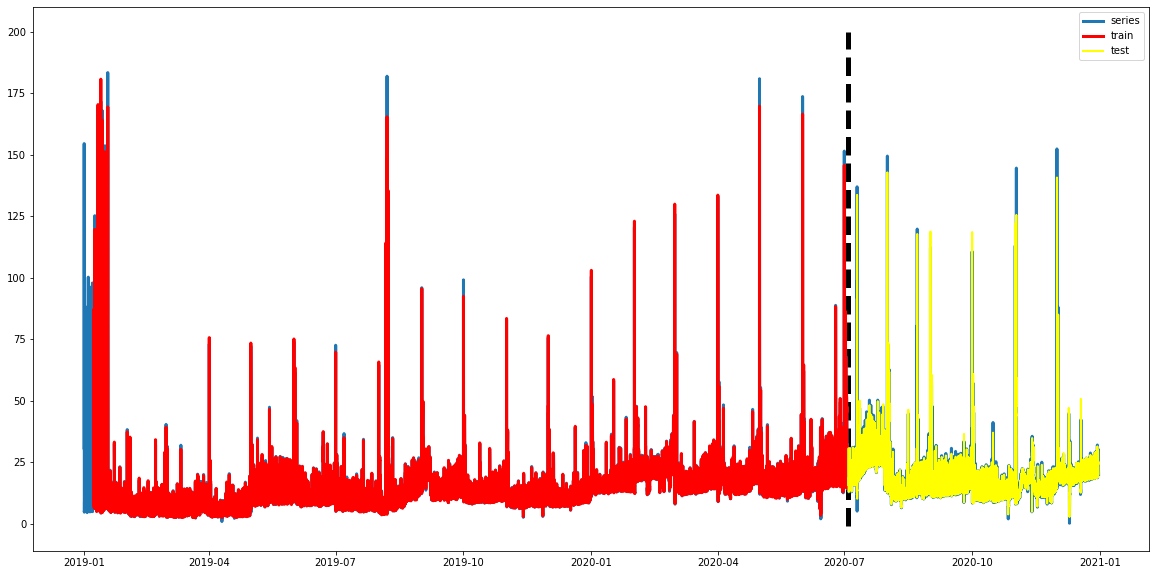

In [24]:
plt.figure(figsize=(20,10))
plt.plot(series,linewidth=3,label='series')
plt.vlines(X.index[-1440*6],-1,200,linestyles = "dashed",linewidth=5)
plt.plot(X.index[:-1440*6],trainpre1,color='red',label='train',linewidth=3)
plt.plot(X.index[-1440*6:],preds1,color='yellow',label='test', linewidth=2)
plt.legend()
plt.show()